In [1]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.python.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from tqdm import tqdm_notebook

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline



from xyz2mol import *

In [2]:
mols = list()
smiles = [i.strip('\n') for i in open('larger_dataset.smi', 'r').readlines()]
for smi in tqdm_notebook(smiles):
    mols.append(Chem.MolFromSmiles(smi))

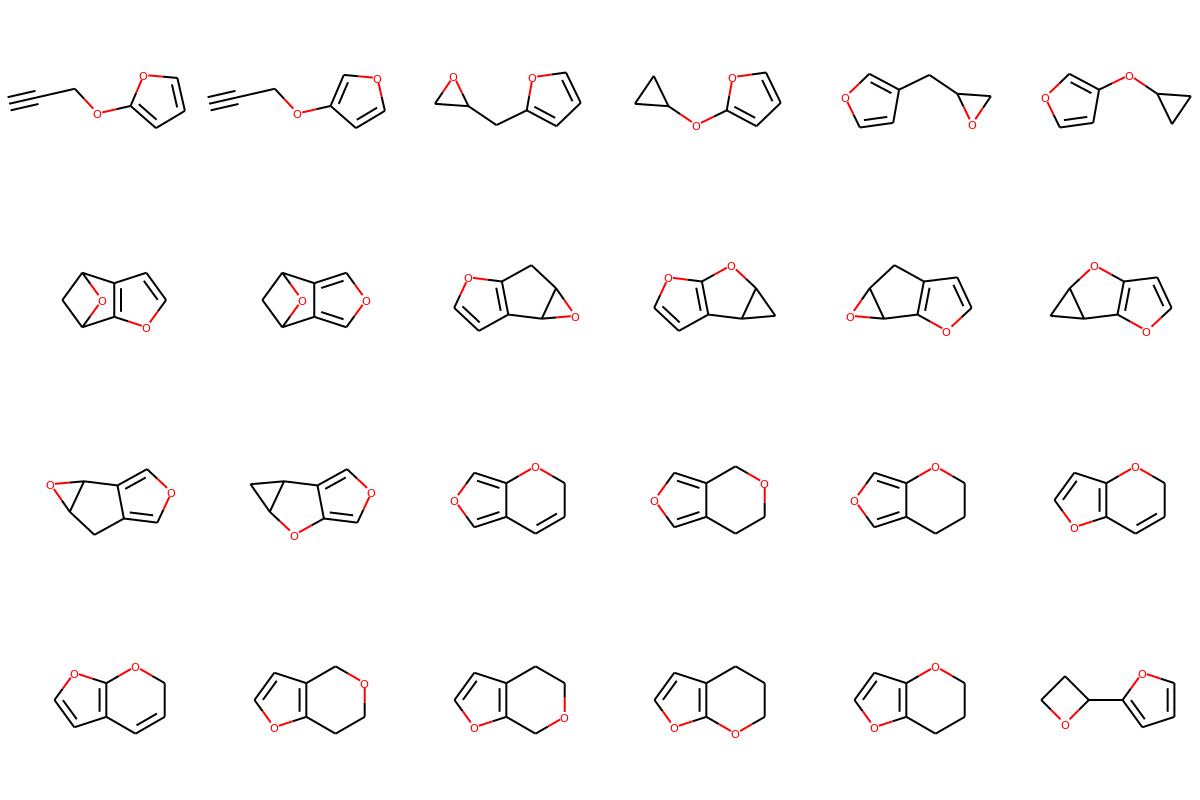

In [3]:
Draw.MolsToGridImage(mols[:24], molsPerRow=6)


In [4]:

def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None
    
def permute_edm(edm, atom_identities, num_permutes=1000):
    edm= squareform(edm)
    idx = np.arange(9)
    edm_list = list()
    atom_list = list()
    
    for _ in range(num_permutes):
        np.random.shuffle(idx)
        edm_copy = edm[idx][:,idx]
        edm_list.append(squareform(edm_copy))
        atom_list.append(atom_identities[idx])
    return edm_list, atom_list

In [5]:
edms = list()
atomidx = list()
for m in tqdm_notebook(np.random.choice(np.array(mols), 2000)):
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        atoms = np.array([i.GetAtomicNum() for i in m.GetAtoms()])-7
        el, al = permute_edm(edm, atoms, num_permutes=10)
        for e, a in zip(el, al):
            edms.append(e)
            atomidx.append(a)

In [6]:
edms = np.array(edms)
data = copy.copy(edms)
##reduce noise using pca?
#pca = PCA(0.99, whiten=True) ##keep 99 percent of variance. 
#data = pca.fit_transform(edms)

#scale to maximum 1:
#maximum = np.max(data)
#print('max is:', maximum)
#data = data/maximum


#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#data = scaler.fit_transform(edms)
#maximum = np.max(np.abs(data))
#print('max is:', maximum)
#data = data/maximum

data = np.log10(edms)
data_mean = np.mean(data)
data = data- np.mean(data)
maximum = np.max(np.abs(data))
print('max is:', maximum)
print('min is:', np.min(data))

#print('Went from:', edms.shape, 'dimensions to:', data.shape)


##Stacking EDMs onto atom identities:

data = np.hstack([data, np.array(atomidx)])

max is: 0.5861777402262047
min is: -0.35470188528894764


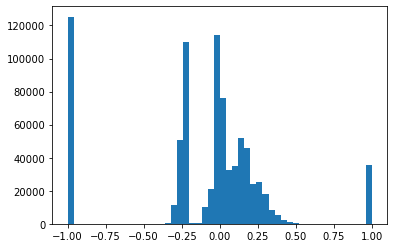

In [7]:
_ = plt.hist(data[:,:].flatten(), bins=50)

# Simple WGAN:

In [23]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop, Nadam
from keras import regularizers
from keras.constraints import Constraint


#https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/
    
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value
 
    # clip model weights to hypercube
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)
 
    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}
    

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    # weight constraint
    const = ClipConstraint(0.01)
    # define model
    model = Sequential()
    #img_shape = (45, 1)
    #model.add(Flatten(input_shape=img_shape))
    #model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(64, kernel_initializer='he_uniform',
                            kernel_constraint=const,
                   input_dim=45))
    ##Learning layers:
    for num in [64, 64]:
            model.add(Dense(num, kernel_initializer='he_uniform',
                            kernel_constraint=const))
                       #kernel_regularizer=regularizers.l2(0.3)))
            model.add(LeakyReLU(alpha=0.2))
            #model.add(Dropout(0.1))
            #model.add(BatchNormalization(momentum=0.8))
    
    
    # scoring, linear activation
    model.add(Dense(1, activation='linear'))
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
                      
    return model


def define_generator(latent_dim=100):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    # define model
    model = Sequential()
    # foundation for 7x7 image
    
    model.add(Dense(64, kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    
    
    for num in [64, 64]:
        model.add(Dense(num, kernel_initializer='he_uniform'))
                    #kernel_regularizer=regularizers.l2(0.3)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.1))
        #model.add(BatchNormalization(momentum=0.2))

    model.add(Dense(45, activation='tanh'))
    return model


def define_gan(generator, critic):
    # make weights in the critic not trainable
    critic.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the critic
    model.add(critic)
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model


def generate_real_samples(data, size):
    # select all of the examples for a given class
    idx = np.random.randint(0, data.shape[0], size)
    X = data[idx]
    labels = -1*np.ones(size)
    return X, labels

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels with 1.0 for 'fake'
    y = np.ones((n_samples, 1))
    return X, y

def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('plot_line_plot_loss.png')
    plt.close()
    
                  
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=64, n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_steps):
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            c1_tmp.append(c_loss1)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            c2_tmp.append(c_loss2)
        # store critic loss
        c1_hist.append(np.mean(c1_tmp))
        c2_hist.append(np.mean(c2_tmp))
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = -np.ones((n_batch, 1))
        # update the generator via the critic's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        g_hist.append(g_loss)
        # summarize loss on this batch
        print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
        if (i+1) % bat_per_epo == 0:
            plot_history(c1_hist, c2_hist, g_hist)
        # evaluate the model performance every 'epoch'
    # line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)

In [ ]:
latent_dim = 50
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)

# train model
train(generator, critic, gan_model, data, latent_dim)

>1, c1=-0.017, c2=0.001 g=-0.000
>2, c1=-0.000, c2=0.001 g=-0.000
>3, c1=-0.000, c2=0.001 g=-0.000
>4, c1=-0.000, c2=0.001 g=-0.000
>5, c1=-0.000, c2=0.000 g=-0.000
>6, c1=-0.000, c2=0.000 g=0.000
>7, c1=-0.000, c2=0.000 g=0.000
>8, c1=-0.000, c2=0.000 g=0.000
>9, c1=-0.001, c2=-0.000 g=0.001
>10, c1=-0.001, c2=-0.000 g=0.001
>11, c1=-0.001, c2=-0.000 g=0.001
>12, c1=-0.001, c2=-0.001 g=0.001
>13, c1=-0.001, c2=-0.001 g=0.002
>14, c1=-0.001, c2=-0.001 g=0.002
>15, c1=-0.001, c2=-0.002 g=0.003
>16, c1=-0.002, c2=-0.002 g=0.003
>17, c1=-0.002, c2=-0.003 g=0.004
>18, c1=-0.003, c2=-0.004 g=0.005
>19, c1=-0.003, c2=-0.004 g=0.006
>20, c1=-0.004, c2=-0.005 g=0.006
>21, c1=-0.004, c2=-0.006 g=0.007
>22, c1=-0.005, c2=-0.007 g=0.008
>23, c1=-0.006, c2=-0.008 g=0.009
>24, c1=-0.007, c2=-0.009 g=0.011
>25, c1=-0.008, c2=-0.011 g=0.012
>26, c1=-0.009, c2=-0.012 g=0.014
>27, c1=-0.011, c2=-0.014 g=0.014
>28, c1=-0.012, c2=-0.015 g=0.017
>29, c1=-0.013, c2=-0.017 g=0.017
>30, c1=-0.015, c2=-0.018 

>248, c1=-0.095, c2=0.009 g=-0.001
>249, c1=-0.092, c2=0.017 g=-0.006
>250, c1=-0.094, c2=0.004 g=-0.020
>251, c1=-0.098, c2=0.008 g=-0.010
>252, c1=-0.084, c2=0.012 g=-0.016
>253, c1=-0.087, c2=0.012 g=-0.017
>254, c1=-0.090, c2=0.020 g=-0.003
>255, c1=-0.090, c2=0.005 g=-0.010
>256, c1=-0.096, c2=0.020 g=-0.007
>257, c1=-0.090, c2=0.032 g=-0.002
>258, c1=-0.096, c2=0.025 g=-0.004
>259, c1=-0.088, c2=0.023 g=-0.023
>260, c1=-0.086, c2=0.025 g=-0.015
>261, c1=-0.091, c2=0.025 g=-0.021
>262, c1=-0.093, c2=0.029 g=-0.015
>263, c1=-0.082, c2=0.023 g=-0.016
>264, c1=-0.087, c2=0.021 g=-0.016
>265, c1=-0.092, c2=0.029 g=-0.019
>266, c1=-0.087, c2=0.025 g=-0.022
>267, c1=-0.088, c2=0.031 g=-0.033
>268, c1=-0.087, c2=0.023 g=-0.022
>269, c1=-0.091, c2=0.029 g=-0.032
>270, c1=-0.086, c2=0.031 g=-0.029
>271, c1=-0.083, c2=0.032 g=-0.047
>272, c1=-0.081, c2=0.033 g=-0.011
>273, c1=-0.082, c2=0.033 g=-0.023
>274, c1=-0.080, c2=0.032 g=-0.015
>275, c1=-0.084, c2=0.031 g=-0.024
>276, c1=-0.085, c2=

>496, c1=0.090, c2=-0.090 g=0.093
>497, c1=0.093, c2=-0.093 g=0.096
>498, c1=0.095, c2=-0.091 g=0.095
>499, c1=0.097, c2=-0.092 g=0.094
>500, c1=0.098, c2=-0.095 g=0.095
>501, c1=0.097, c2=-0.093 g=0.095
>502, c1=0.101, c2=-0.092 g=0.097
>503, c1=0.096, c2=-0.094 g=0.097
>504, c1=0.094, c2=-0.096 g=0.098
>505, c1=0.095, c2=-0.094 g=0.100
>506, c1=0.096, c2=-0.093 g=0.098
>507, c1=0.098, c2=-0.097 g=0.100
>508, c1=0.101, c2=-0.094 g=0.097
>509, c1=0.099, c2=-0.095 g=0.102
>510, c1=0.098, c2=-0.094 g=0.096
>511, c1=0.099, c2=-0.096 g=0.100
>512, c1=0.102, c2=-0.095 g=0.096
>513, c1=0.102, c2=-0.097 g=0.097
>514, c1=0.097, c2=-0.098 g=0.100
>515, c1=0.102, c2=-0.096 g=0.096
>516, c1=0.102, c2=-0.096 g=0.097
>517, c1=0.100, c2=-0.094 g=0.096
>518, c1=0.104, c2=-0.094 g=0.101
>519, c1=0.098, c2=-0.094 g=0.100
>520, c1=0.100, c2=-0.093 g=0.099
>521, c1=0.098, c2=-0.094 g=0.098
>522, c1=0.098, c2=-0.096 g=0.097
>523, c1=0.099, c2=-0.096 g=0.096
>524, c1=0.097, c2=-0.097 g=0.100
>525, c1=0.098

>753, c1=0.061, c2=-0.058 g=0.059
>754, c1=0.061, c2=-0.058 g=0.063
>755, c1=0.061, c2=-0.059 g=0.060
>756, c1=0.062, c2=-0.060 g=0.063
>757, c1=0.062, c2=-0.059 g=0.062
>758, c1=0.061, c2=-0.059 g=0.062
>759, c1=0.061, c2=-0.062 g=0.058
>760, c1=0.063, c2=-0.061 g=0.063
>761, c1=0.063, c2=-0.058 g=0.060
>762, c1=0.062, c2=-0.058 g=0.065
>763, c1=0.063, c2=-0.061 g=0.063
>764, c1=0.062, c2=-0.062 g=0.062
>765, c1=0.063, c2=-0.059 g=0.063
>766, c1=0.063, c2=-0.063 g=0.065
>767, c1=0.063, c2=-0.062 g=0.067
>768, c1=0.064, c2=-0.062 g=0.066
>769, c1=0.064, c2=-0.062 g=0.064
>770, c1=0.064, c2=-0.063 g=0.064
>771, c1=0.061, c2=-0.063 g=0.066
>772, c1=0.063, c2=-0.064 g=0.064
>773, c1=0.063, c2=-0.064 g=0.069
>774, c1=0.066, c2=-0.064 g=0.066
>775, c1=0.064, c2=-0.065 g=0.067
>776, c1=0.064, c2=-0.064 g=0.066
>777, c1=0.063, c2=-0.062 g=0.068
>778, c1=0.063, c2=-0.063 g=0.068
>779, c1=0.064, c2=-0.065 g=0.068
>780, c1=0.066, c2=-0.065 g=0.069
>781, c1=0.065, c2=-0.063 g=0.070
>782, c1=0.063

>1005, c1=0.052, c2=-0.048 g=0.051
>1006, c1=0.053, c2=-0.050 g=0.052
>1007, c1=0.053, c2=-0.050 g=0.053
>1008, c1=0.053, c2=-0.049 g=0.052
>1009, c1=0.053, c2=-0.049 g=0.052
>1010, c1=0.053, c2=-0.051 g=0.055
>1011, c1=0.053, c2=-0.050 g=0.052
>1012, c1=0.053, c2=-0.050 g=0.054
>1013, c1=0.053, c2=-0.050 g=0.053
>1014, c1=0.052, c2=-0.050 g=0.053
>1015, c1=0.053, c2=-0.049 g=0.053
>1016, c1=0.053, c2=-0.051 g=0.055
>1017, c1=0.053, c2=-0.050 g=0.055
>1018, c1=0.053, c2=-0.050 g=0.055
>1019, c1=0.052, c2=-0.050 g=0.053
>1020, c1=0.053, c2=-0.050 g=0.052
>1021, c1=0.053, c2=-0.051 g=0.053
>1022, c1=0.054, c2=-0.050 g=0.054
>1023, c1=0.053, c2=-0.052 g=0.053
>1024, c1=0.054, c2=-0.051 g=0.055
>1025, c1=0.054, c2=-0.052 g=0.053
>1026, c1=0.054, c2=-0.051 g=0.053
>1027, c1=0.054, c2=-0.051 g=0.055
>1028, c1=0.055, c2=-0.052 g=0.053
>1029, c1=0.054, c2=-0.051 g=0.054
>1030, c1=0.054, c2=-0.052 g=0.055
>1031, c1=0.054, c2=-0.052 g=0.053
>1032, c1=0.054, c2=-0.051 g=0.055
>1033, c1=0.054, c2=

>1258, c1=0.045, c2=-0.043 g=0.045
>1259, c1=0.045, c2=-0.043 g=0.046
>1260, c1=0.045, c2=-0.043 g=0.046
>1261, c1=0.045, c2=-0.043 g=0.046
>1262, c1=0.045, c2=-0.043 g=0.045
>1263, c1=0.045, c2=-0.043 g=0.045
>1264, c1=0.045, c2=-0.043 g=0.045
>1265, c1=0.045, c2=-0.043 g=0.045
>1266, c1=0.045, c2=-0.043 g=0.044
>1267, c1=0.045, c2=-0.043 g=0.045
>1268, c1=0.045, c2=-0.043 g=0.045
>1269, c1=0.045, c2=-0.043 g=0.045
>1270, c1=0.045, c2=-0.042 g=0.045
>1271, c1=0.045, c2=-0.042 g=0.045
>1272, c1=0.045, c2=-0.043 g=0.045
>1273, c1=0.045, c2=-0.042 g=0.044
>1274, c1=0.045, c2=-0.042 g=0.045
>1275, c1=0.044, c2=-0.042 g=0.044
>1276, c1=0.045, c2=-0.042 g=0.044
>1277, c1=0.045, c2=-0.042 g=0.045
>1278, c1=0.044, c2=-0.042 g=0.045
>1279, c1=0.044, c2=-0.042 g=0.045
>1280, c1=0.044, c2=-0.042 g=0.044
>1281, c1=0.044, c2=-0.042 g=0.044
>1282, c1=0.044, c2=-0.042 g=0.045
>1283, c1=0.044, c2=-0.042 g=0.045
>1284, c1=0.044, c2=-0.042 g=0.044
>1285, c1=0.044, c2=-0.042 g=0.044
>1286, c1=0.044, c2=

>1509, c1=0.040, c2=-0.039 g=0.041
>1510, c1=0.040, c2=-0.038 g=0.041
>1511, c1=0.041, c2=-0.039 g=0.041
>1512, c1=0.040, c2=-0.039 g=0.041
>1513, c1=0.040, c2=-0.039 g=0.041
>1514, c1=0.040, c2=-0.039 g=0.041
>1515, c1=0.040, c2=-0.039 g=0.040
>1516, c1=0.041, c2=-0.039 g=0.041
>1517, c1=0.040, c2=-0.039 g=0.041
>1518, c1=0.041, c2=-0.038 g=0.041
>1519, c1=0.040, c2=-0.039 g=0.040
>1520, c1=0.041, c2=-0.039 g=0.042
>1521, c1=0.040, c2=-0.038 g=0.041
>1522, c1=0.040, c2=-0.039 g=0.040
>1523, c1=0.040, c2=-0.038 g=0.040
>1524, c1=0.040, c2=-0.038 g=0.040
>1525, c1=0.040, c2=-0.038 g=0.041
>1526, c1=0.040, c2=-0.038 g=0.039
>1527, c1=0.040, c2=-0.038 g=0.040
>1528, c1=0.040, c2=-0.038 g=0.040
>1529, c1=0.040, c2=-0.038 g=0.040
>1530, c1=0.040, c2=-0.038 g=0.040
>1531, c1=0.039, c2=-0.037 g=0.040
>1532, c1=0.039, c2=-0.038 g=0.040
>1533, c1=0.039, c2=-0.038 g=0.040
>1534, c1=0.039, c2=-0.038 g=0.040
>1535, c1=0.039, c2=-0.038 g=0.040
>1536, c1=0.039, c2=-0.038 g=0.040
>1537, c1=0.039, c2=

>1761, c1=0.037, c2=-0.035 g=0.037
>1762, c1=0.037, c2=-0.035 g=0.037
>1763, c1=0.037, c2=-0.035 g=0.037
>1764, c1=0.037, c2=-0.035 g=0.037
>1765, c1=0.037, c2=-0.035 g=0.037
>1766, c1=0.036, c2=-0.035 g=0.037
>1767, c1=0.036, c2=-0.035 g=0.037
>1768, c1=0.037, c2=-0.035 g=0.037
>1769, c1=0.036, c2=-0.035 g=0.037
>1770, c1=0.036, c2=-0.035 g=0.037
>1771, c1=0.037, c2=-0.035 g=0.037
>1772, c1=0.037, c2=-0.035 g=0.037
>1773, c1=0.037, c2=-0.035 g=0.037
>1774, c1=0.037, c2=-0.035 g=0.037
>1775, c1=0.036, c2=-0.035 g=0.037
>1776, c1=0.036, c2=-0.035 g=0.037
>1777, c1=0.036, c2=-0.035 g=0.037
>1778, c1=0.036, c2=-0.035 g=0.037
>1779, c1=0.036, c2=-0.035 g=0.037
>1780, c1=0.036, c2=-0.035 g=0.037
>1781, c1=0.036, c2=-0.034 g=0.037
>1782, c1=0.036, c2=-0.034 g=0.036
>1783, c1=0.036, c2=-0.034 g=0.036
>1784, c1=0.036, c2=-0.034 g=0.037
>1785, c1=0.036, c2=-0.034 g=0.036
>1786, c1=0.035, c2=-0.034 g=0.036
>1787, c1=0.036, c2=-0.034 g=0.036
>1788, c1=0.036, c2=-0.034 g=0.036
>1789, c1=0.036, c2=

>2014, c1=0.033, c2=-0.032 g=0.033
>2015, c1=0.033, c2=-0.031 g=0.033
>2016, c1=0.033, c2=-0.031 g=0.033
>2017, c1=0.033, c2=-0.031 g=0.033
>2018, c1=0.033, c2=-0.031 g=0.033
>2019, c1=0.033, c2=-0.031 g=0.033
>2020, c1=0.033, c2=-0.031 g=0.033
>2021, c1=0.033, c2=-0.031 g=0.033
>2022, c1=0.033, c2=-0.031 g=0.033
>2023, c1=0.033, c2=-0.032 g=0.034
>2024, c1=0.033, c2=-0.032 g=0.034
>2025, c1=0.033, c2=-0.032 g=0.034
>2026, c1=0.033, c2=-0.032 g=0.034
>2027, c1=0.033, c2=-0.032 g=0.034
>2028, c1=0.033, c2=-0.032 g=0.034
>2029, c1=0.034, c2=-0.032 g=0.034
>2030, c1=0.033, c2=-0.032 g=0.033
>2031, c1=0.033, c2=-0.032 g=0.034
>2032, c1=0.034, c2=-0.031 g=0.033
>2033, c1=0.033, c2=-0.032 g=0.033
>2034, c1=0.034, c2=-0.032 g=0.034
>2035, c1=0.034, c2=-0.032 g=0.034
>2036, c1=0.033, c2=-0.031 g=0.034
>2037, c1=0.033, c2=-0.031 g=0.034
>2038, c1=0.033, c2=-0.031 g=0.034
>2039, c1=0.033, c2=-0.032 g=0.033
>2040, c1=0.033, c2=-0.032 g=0.033
>2041, c1=0.033, c2=-0.032 g=0.033
>2042, c1=0.033, c2=

>2262, c1=0.030, c2=-0.029 g=0.031
>2263, c1=0.031, c2=-0.029 g=0.031
>2264, c1=0.030, c2=-0.028 g=0.030
>2265, c1=0.030, c2=-0.028 g=0.031
>2266, c1=0.030, c2=-0.028 g=0.030
>2267, c1=0.030, c2=-0.029 g=0.030
>2268, c1=0.030, c2=-0.029 g=0.030
>2269, c1=0.030, c2=-0.029 g=0.030
>2270, c1=0.030, c2=-0.028 g=0.031
>2271, c1=0.030, c2=-0.028 g=0.030
>2272, c1=0.030, c2=-0.028 g=0.030
>2273, c1=0.030, c2=-0.028 g=0.030
>2274, c1=0.030, c2=-0.028 g=0.031
>2275, c1=0.030, c2=-0.029 g=0.031
>2276, c1=0.030, c2=-0.028 g=0.030
>2277, c1=0.030, c2=-0.029 g=0.031
>2278, c1=0.030, c2=-0.028 g=0.030
>2279, c1=0.030, c2=-0.029 g=0.031
>2280, c1=0.030, c2=-0.028 g=0.030
>2281, c1=0.030, c2=-0.029 g=0.030
>2282, c1=0.030, c2=-0.028 g=0.031
>2283, c1=0.030, c2=-0.028 g=0.030
>2284, c1=0.030, c2=-0.029 g=0.030
>2285, c1=0.030, c2=-0.028 g=0.030
>2286, c1=0.030, c2=-0.028 g=0.031
>2287, c1=0.030, c2=-0.028 g=0.030
>2288, c1=0.030, c2=-0.028 g=0.031
>2289, c1=0.030, c2=-0.029 g=0.030
>2290, c1=0.030, c2=

>2497, c1=0.028, c2=-0.027 g=0.028
>2498, c1=0.028, c2=-0.027 g=0.029
>2499, c1=0.028, c2=-0.026 g=0.028
>2500, c1=0.028, c2=-0.027 g=0.028
>2501, c1=0.028, c2=-0.027 g=0.028
>2502, c1=0.028, c2=-0.027 g=0.028
>2503, c1=0.028, c2=-0.026 g=0.028
>2504, c1=0.028, c2=-0.026 g=0.028
>2505, c1=0.027, c2=-0.026 g=0.028
>2506, c1=0.027, c2=-0.026 g=0.028
>2507, c1=0.028, c2=-0.026 g=0.028
>2508, c1=0.028, c2=-0.026 g=0.028
>2509, c1=0.028, c2=-0.026 g=0.028
>2510, c1=0.028, c2=-0.026 g=0.028
>2511, c1=0.028, c2=-0.026 g=0.028
>2512, c1=0.028, c2=-0.027 g=0.029
>2513, c1=0.028, c2=-0.027 g=0.029
>2514, c1=0.028, c2=-0.027 g=0.029
>2515, c1=0.028, c2=-0.027 g=0.029
>2516, c1=0.028, c2=-0.027 g=0.029
>2517, c1=0.029, c2=-0.027 g=0.029
>2518, c1=0.028, c2=-0.027 g=0.029
>2519, c1=0.028, c2=-0.027 g=0.028
>2520, c1=0.028, c2=-0.026 g=0.029
>2521, c1=0.028, c2=-0.027 g=0.028
>2522, c1=0.028, c2=-0.026 g=0.028
>2523, c1=0.028, c2=-0.027 g=0.028
>2524, c1=0.028, c2=-0.026 g=0.028
>2525, c1=0.027, c2=

>2748, c1=0.024, c2=-0.024 g=0.026
>2749, c1=0.024, c2=-0.024 g=0.025
>2750, c1=0.024, c2=-0.023 g=0.025
>2751, c1=0.024, c2=-0.024 g=0.025
>2752, c1=0.024, c2=-0.023 g=0.026
>2753, c1=0.024, c2=-0.024 g=0.025
>2754, c1=0.024, c2=-0.024 g=0.026
>2755, c1=0.024, c2=-0.023 g=0.025
>2756, c1=0.024, c2=-0.024 g=0.025
>2757, c1=0.024, c2=-0.023 g=0.025
>2758, c1=0.023, c2=-0.023 g=0.025
>2759, c1=0.024, c2=-0.023 g=0.025
>2760, c1=0.024, c2=-0.023 g=0.025
>2761, c1=0.024, c2=-0.023 g=0.025
>2762, c1=0.024, c2=-0.023 g=0.025
>2763, c1=0.024, c2=-0.023 g=0.025
>2764, c1=0.024, c2=-0.023 g=0.026
>2765, c1=0.024, c2=-0.024 g=0.025
>2766, c1=0.024, c2=-0.023 g=0.025
>2767, c1=0.024, c2=-0.024 g=0.025
>2768, c1=0.024, c2=-0.024 g=0.025
>2769, c1=0.024, c2=-0.023 g=0.026
>2770, c1=0.024, c2=-0.024 g=0.026
>2771, c1=0.025, c2=-0.023 g=0.025
>2772, c1=0.024, c2=-0.024 g=0.026
>2773, c1=0.025, c2=-0.024 g=0.026
>2774, c1=0.024, c2=-0.023 g=0.025
>2775, c1=0.025, c2=-0.024 g=0.026
>2776, c1=0.024, c2=

>3000, c1=0.022, c2=-0.020 g=0.022
>3001, c1=0.021, c2=-0.021 g=0.022
>3002, c1=0.022, c2=-0.021 g=0.023
>3003, c1=0.022, c2=-0.021 g=0.023
>3004, c1=0.022, c2=-0.021 g=0.023
>3005, c1=0.022, c2=-0.021 g=0.023
>3006, c1=0.022, c2=-0.021 g=0.023
>3007, c1=0.022, c2=-0.020 g=0.023
>3008, c1=0.021, c2=-0.021 g=0.022
>3009, c1=0.022, c2=-0.021 g=0.023
>3010, c1=0.022, c2=-0.020 g=0.022
>3011, c1=0.021, c2=-0.021 g=0.022
>3012, c1=0.022, c2=-0.020 g=0.022
>3013, c1=0.021, c2=-0.020 g=0.022
>3014, c1=0.021, c2=-0.020 g=0.022
>3015, c1=0.021, c2=-0.020 g=0.022
>3016, c1=0.021, c2=-0.020 g=0.022
>3017, c1=0.022, c2=-0.020 g=0.022
>3018, c1=0.022, c2=-0.020 g=0.022
>3019, c1=0.021, c2=-0.020 g=0.022
>3020, c1=0.021, c2=-0.020 g=0.022
>3021, c1=0.021, c2=-0.020 g=0.022
>3022, c1=0.021, c2=-0.020 g=0.022
>3023, c1=0.022, c2=-0.020 g=0.022
>3024, c1=0.021, c2=-0.020 g=0.022
>3025, c1=0.021, c2=-0.021 g=0.022
>3026, c1=0.022, c2=-0.020 g=0.022
>3027, c1=0.022, c2=-0.021 g=0.022
>3028, c1=0.021, c2=

>3252, c1=0.019, c2=-0.018 g=0.020
>3253, c1=0.019, c2=-0.018 g=0.020
>3254, c1=0.019, c2=-0.018 g=0.020
>3255, c1=0.019, c2=-0.018 g=0.020
>3256, c1=0.019, c2=-0.018 g=0.019
>3257, c1=0.019, c2=-0.018 g=0.021
>3258, c1=0.020, c2=-0.018 g=0.020
>3259, c1=0.019, c2=-0.018 g=0.020
>3260, c1=0.019, c2=-0.018 g=0.021
>3261, c1=0.020, c2=-0.018 g=0.020
>3262, c1=0.020, c2=-0.018 g=0.020
>3263, c1=0.019, c2=-0.018 g=0.020
>3264, c1=0.019, c2=-0.018 g=0.020
>3265, c1=0.019, c2=-0.018 g=0.020
>3266, c1=0.019, c2=-0.018 g=0.020
>3267, c1=0.019, c2=-0.018 g=0.020
>3268, c1=0.019, c2=-0.018 g=0.019
>3269, c1=0.020, c2=-0.018 g=0.019
>3270, c1=0.019, c2=-0.018 g=0.020
>3271, c1=0.019, c2=-0.018 g=0.020
>3272, c1=0.019, c2=-0.018 g=0.020
>3273, c1=0.019, c2=-0.018 g=0.020
>3274, c1=0.019, c2=-0.018 g=0.020
>3275, c1=0.019, c2=-0.018 g=0.020
>3276, c1=0.019, c2=-0.017 g=0.019
>3277, c1=0.019, c2=-0.018 g=0.019
>3278, c1=0.019, c2=-0.018 g=0.020
>3279, c1=0.019, c2=-0.018 g=0.020
>3280, c1=0.019, c2=

>3501, c1=0.016, c2=-0.018 g=0.019
>3502, c1=0.016, c2=-0.017 g=0.019
>3503, c1=0.016, c2=-0.017 g=0.019
>3504, c1=0.016, c2=-0.017 g=0.019
>3505, c1=0.015, c2=-0.017 g=0.018
>3506, c1=0.016, c2=-0.017 g=0.019
>3507, c1=0.016, c2=-0.017 g=0.018
>3508, c1=0.016, c2=-0.017 g=0.019
>3509, c1=0.015, c2=-0.017 g=0.019
>3510, c1=0.016, c2=-0.017 g=0.019
>3511, c1=0.016, c2=-0.017 g=0.018
>3512, c1=0.016, c2=-0.017 g=0.018
>3513, c1=0.016, c2=-0.017 g=0.019
>3514, c1=0.016, c2=-0.017 g=0.019
>3515, c1=0.016, c2=-0.017 g=0.019
>3516, c1=0.016, c2=-0.017 g=0.019
>3517, c1=0.017, c2=-0.017 g=0.019
>3518, c1=0.016, c2=-0.017 g=0.019
>3519, c1=0.016, c2=-0.017 g=0.019
>3520, c1=0.016, c2=-0.017 g=0.019
>3521, c1=0.016, c2=-0.017 g=0.019
>3522, c1=0.016, c2=-0.017 g=0.019
>3523, c1=0.016, c2=-0.017 g=0.019
>3524, c1=0.016, c2=-0.018 g=0.019
>3525, c1=0.016, c2=-0.017 g=0.019
>3526, c1=0.016, c2=-0.017 g=0.019
>3527, c1=0.016, c2=-0.018 g=0.020
>3528, c1=0.016, c2=-0.017 g=0.019
>3529, c1=0.016, c2=

>3758, c1=0.013, c2=-0.014 g=0.015
>3759, c1=0.013, c2=-0.013 g=0.015
>3760, c1=0.013, c2=-0.014 g=0.016
>3761, c1=0.013, c2=-0.014 g=0.015
>3762, c1=0.013, c2=-0.014 g=0.015
>3763, c1=0.013, c2=-0.014 g=0.015
>3764, c1=0.013, c2=-0.013 g=0.016
>3765, c1=0.013, c2=-0.014 g=0.015
>3766, c1=0.013, c2=-0.013 g=0.015
>3767, c1=0.013, c2=-0.014 g=0.015
>3768, c1=0.012, c2=-0.014 g=0.015
>3769, c1=0.012, c2=-0.013 g=0.015
>3770, c1=0.012, c2=-0.013 g=0.015
>3771, c1=0.012, c2=-0.013 g=0.016
>3772, c1=0.012, c2=-0.014 g=0.015
>3773, c1=0.013, c2=-0.013 g=0.015
>3774, c1=0.011, c2=-0.013 g=0.014
>3775, c1=0.013, c2=-0.013 g=0.015
>3776, c1=0.013, c2=-0.014 g=0.015
>3777, c1=0.012, c2=-0.013 g=0.015
>3778, c1=0.012, c2=-0.013 g=0.015
>3779, c1=0.012, c2=-0.013 g=0.015
>3780, c1=0.013, c2=-0.013 g=0.015
>3781, c1=0.012, c2=-0.013 g=0.014
>3782, c1=0.012, c2=-0.013 g=0.015
>3783, c1=0.013, c2=-0.013 g=0.014
>3784, c1=0.012, c2=-0.012 g=0.015
>3785, c1=0.012, c2=-0.013 g=0.014
>3786, c1=0.013, c2=

>4008, c1=0.010, c2=-0.011 g=0.013
>4009, c1=0.010, c2=-0.011 g=0.012
>4010, c1=0.010, c2=-0.011 g=0.012
>4011, c1=0.010, c2=-0.011 g=0.012
>4012, c1=0.010, c2=-0.010 g=0.013
>4013, c1=0.011, c2=-0.011 g=0.012
>4014, c1=0.010, c2=-0.011 g=0.012
>4015, c1=0.009, c2=-0.010 g=0.012
>4016, c1=0.010, c2=-0.011 g=0.012
>4017, c1=0.010, c2=-0.010 g=0.012
>4018, c1=0.010, c2=-0.011 g=0.012
>4019, c1=0.010, c2=-0.010 g=0.012
>4020, c1=0.009, c2=-0.010 g=0.012
>4021, c1=0.010, c2=-0.011 g=0.012
>4022, c1=0.009, c2=-0.010 g=0.012
>4023, c1=0.010, c2=-0.010 g=0.012
>4024, c1=0.009, c2=-0.010 g=0.012
>4025, c1=0.009, c2=-0.010 g=0.012
>4026, c1=0.009, c2=-0.010 g=0.012
>4027, c1=0.009, c2=-0.010 g=0.012
>4028, c1=0.009, c2=-0.010 g=0.012
>4029, c1=0.010, c2=-0.010 g=0.012
>4030, c1=0.009, c2=-0.010 g=0.012
>4031, c1=0.009, c2=-0.010 g=0.011
>4032, c1=0.009, c2=-0.010 g=0.012
>4033, c1=0.009, c2=-0.010 g=0.012
>4034, c1=0.009, c2=-0.010 g=0.012
>4035, c1=0.010, c2=-0.010 g=0.012
>4036, c1=0.009, c2=

>4263, c1=0.003, c2=-0.005 g=0.006
>4264, c1=0.002, c2=-0.005 g=0.006
>4265, c1=0.003, c2=-0.005 g=0.006
>4266, c1=0.004, c2=-0.005 g=0.006
>4267, c1=0.002, c2=-0.005 g=0.006
>4268, c1=0.004, c2=-0.005 g=0.007
>4269, c1=0.002, c2=-0.005 g=0.007
>4270, c1=0.004, c2=-0.005 g=0.007
>4271, c1=0.002, c2=-0.005 g=0.007
>4272, c1=0.003, c2=-0.005 g=0.007
>4273, c1=0.004, c2=-0.005 g=0.006
>4274, c1=0.004, c2=-0.005 g=0.006
>4275, c1=0.003, c2=-0.005 g=0.006
>4276, c1=0.004, c2=-0.005 g=0.006
>4277, c1=0.002, c2=-0.005 g=0.007
>4278, c1=0.003, c2=-0.004 g=0.006
>4279, c1=0.003, c2=-0.005 g=0.007
>4280, c1=0.002, c2=-0.005 g=0.006
>4281, c1=0.004, c2=-0.004 g=0.006
>4282, c1=0.003, c2=-0.004 g=0.006
>4283, c1=0.003, c2=-0.004 g=0.005
>4284, c1=0.002, c2=-0.004 g=0.006
>4285, c1=0.002, c2=-0.004 g=0.005
>4286, c1=0.003, c2=-0.004 g=0.006
>4287, c1=0.002, c2=-0.004 g=0.005
>4288, c1=0.002, c2=-0.004 g=0.005
>4289, c1=0.000, c2=-0.004 g=0.005
>4290, c1=0.002, c2=-0.004 g=0.005
>4291, c1=0.002, c2=

>4516, c1=-0.009, c2=0.007 g=-0.005
>4517, c1=-0.009, c2=0.007 g=-0.007
>4518, c1=-0.009, c2=0.008 g=-0.006
>4519, c1=-0.009, c2=0.008 g=-0.005
>4520, c1=-0.009, c2=0.007 g=-0.006
>4521, c1=-0.009, c2=0.007 g=-0.005
>4522, c1=-0.009, c2=0.008 g=-0.007
>4523, c1=-0.009, c2=0.009 g=-0.005
>4524, c1=-0.009, c2=0.007 g=-0.005
>4525, c1=-0.008, c2=0.008 g=-0.006
>4526, c1=-0.009, c2=0.008 g=-0.006
>4527, c1=-0.010, c2=0.007 g=-0.006
>4528, c1=-0.009, c2=0.009 g=-0.007
>4529, c1=-0.009, c2=0.008 g=-0.007
>4530, c1=-0.009, c2=0.008 g=-0.006
>4531, c1=-0.010, c2=0.008 g=-0.007
>4532, c1=-0.008, c2=0.008 g=-0.007
>4533, c1=-0.009, c2=0.008 g=-0.007
>4534, c1=-0.009, c2=0.008 g=-0.007
>4535, c1=-0.009, c2=0.008 g=-0.006
>4536, c1=-0.009, c2=0.008 g=-0.007
>4537, c1=-0.009, c2=0.008 g=-0.006
>4538, c1=-0.009, c2=0.008 g=-0.006
>4539, c1=-0.008, c2=0.008 g=-0.005
>4540, c1=-0.009, c2=0.009 g=-0.006
>4541, c1=-0.008, c2=0.008 g=-0.005
>4542, c1=-0.009, c2=0.007 g=-0.005
>4543, c1=-0.009, c2=0.008 g

>4744, c1=-0.011, c2=0.011 g=-0.008
>4745, c1=-0.011, c2=0.011 g=-0.009
>4746, c1=-0.011, c2=0.011 g=-0.008
>4747, c1=-0.011, c2=0.011 g=-0.010
>4748, c1=-0.011, c2=0.011 g=-0.009
>4749, c1=-0.010, c2=0.010 g=-0.008
>4750, c1=-0.011, c2=0.012 g=-0.010
>4751, c1=-0.011, c2=0.012 g=-0.009
>4752, c1=-0.011, c2=0.011 g=-0.011
>4753, c1=-0.011, c2=0.012 g=-0.011
>4754, c1=-0.012, c2=0.012 g=-0.010
>4755, c1=-0.012, c2=0.011 g=-0.011
>4756, c1=-0.012, c2=0.012 g=-0.011
>4757, c1=-0.011, c2=0.012 g=-0.010
>4758, c1=-0.012, c2=0.011 g=-0.010
>4759, c1=-0.012, c2=0.013 g=-0.010
>4760, c1=-0.012, c2=0.012 g=-0.010
>4761, c1=-0.012, c2=0.012 g=-0.011
>4762, c1=-0.012, c2=0.012 g=-0.010
>4763, c1=-0.012, c2=0.012 g=-0.011
>4764, c1=-0.011, c2=0.012 g=-0.010
>4765, c1=-0.012, c2=0.012 g=-0.010
>4766, c1=-0.012, c2=0.012 g=-0.012
>4767, c1=-0.013, c2=0.012 g=-0.010
>4768, c1=-0.011, c2=0.012 g=-0.011
>4769, c1=-0.014, c2=0.012 g=-0.011
>4770, c1=-0.013, c2=0.012 g=-0.008
>4771, c1=-0.013, c2=0.012 g

>4976, c1=-0.080, c2=0.061 g=-0.062
>4977, c1=-0.080, c2=0.060 g=-0.063
>4978, c1=-0.079, c2=0.063 g=-0.063
>4979, c1=-0.080, c2=0.061 g=-0.058
>4980, c1=-0.081, c2=0.062 g=-0.063
>4981, c1=-0.081, c2=0.065 g=-0.062
>4982, c1=-0.080, c2=0.064 g=-0.056
>4983, c1=-0.081, c2=0.067 g=-0.061
>4984, c1=-0.080, c2=0.064 g=-0.061
>4985, c1=-0.082, c2=0.062 g=-0.066
>4986, c1=-0.082, c2=0.066 g=-0.067
>4987, c1=-0.082, c2=0.063 g=-0.064
>4988, c1=-0.083, c2=0.066 g=-0.065
>4989, c1=-0.082, c2=0.066 g=-0.067
>4990, c1=-0.083, c2=0.067 g=-0.065
>4991, c1=-0.084, c2=0.065 g=-0.068
>4992, c1=-0.084, c2=0.066 g=-0.064
>4993, c1=-0.083, c2=0.067 g=-0.063
>4994, c1=-0.084, c2=0.065 g=-0.065
>4995, c1=-0.086, c2=0.064 g=-0.062
>4996, c1=-0.086, c2=0.069 g=-0.064
>4997, c1=-0.086, c2=0.069 g=-0.068
>4998, c1=-0.086, c2=0.068 g=-0.066
>4999, c1=-0.086, c2=0.067 g=-0.062
>5000, c1=-0.086, c2=0.071 g=-0.067
>5001, c1=-0.087, c2=0.067 g=-0.064
>5002, c1=-0.087, c2=0.068 g=-0.066
>5003, c1=-0.087, c2=0.070 g

>5205, c1=-0.113, c2=0.084 g=-0.080
>5206, c1=-0.113, c2=0.083 g=-0.077
>5207, c1=-0.113, c2=0.083 g=-0.086
>5208, c1=-0.114, c2=0.083 g=-0.077
>5209, c1=-0.116, c2=0.080 g=-0.085
>5210, c1=-0.115, c2=0.080 g=-0.080
>5211, c1=-0.115, c2=0.087 g=-0.082
>5212, c1=-0.114, c2=0.087 g=-0.083
>5213, c1=-0.115, c2=0.085 g=-0.080
>5214, c1=-0.115, c2=0.083 g=-0.080
>5215, c1=-0.115, c2=0.084 g=-0.081
>5216, c1=-0.115, c2=0.083 g=-0.085
>5217, c1=-0.114, c2=0.084 g=-0.081
>5218, c1=-0.114, c2=0.085 g=-0.080
>5219, c1=-0.115, c2=0.085 g=-0.080
>5220, c1=-0.116, c2=0.083 g=-0.080
>5221, c1=-0.115, c2=0.085 g=-0.084
>5222, c1=-0.114, c2=0.081 g=-0.081
>5223, c1=-0.115, c2=0.085 g=-0.085
>5224, c1=-0.116, c2=0.084 g=-0.084
>5225, c1=-0.116, c2=0.083 g=-0.083
>5226, c1=-0.117, c2=0.084 g=-0.089
>5227, c1=-0.116, c2=0.087 g=-0.073
>5228, c1=-0.115, c2=0.079 g=-0.086
>5229, c1=-0.114, c2=0.083 g=-0.081
>5230, c1=-0.116, c2=0.081 g=-0.078
>5231, c1=-0.117, c2=0.080 g=-0.084
>5232, c1=-0.116, c2=0.081 g

>5443, c1=-0.147, c2=0.117 g=-0.118
>5444, c1=-0.146, c2=0.114 g=-0.113
>5445, c1=-0.145, c2=0.121 g=-0.115
>5446, c1=-0.146, c2=0.113 g=-0.113
>5447, c1=-0.146, c2=0.116 g=-0.111
>5448, c1=-0.146, c2=0.117 g=-0.109
>5449, c1=-0.147, c2=0.117 g=-0.115
>5450, c1=-0.146, c2=0.115 g=-0.109
>5451, c1=-0.146, c2=0.119 g=-0.116
>5452, c1=-0.147, c2=0.115 g=-0.113
>5453, c1=-0.146, c2=0.112 g=-0.110
>5454, c1=-0.147, c2=0.113 g=-0.114
>5455, c1=-0.146, c2=0.120 g=-0.121
>5456, c1=-0.148, c2=0.119 g=-0.116
>5457, c1=-0.147, c2=0.119 g=-0.112
>5458, c1=-0.148, c2=0.117 g=-0.117
>5459, c1=-0.148, c2=0.120 g=-0.117
>5460, c1=-0.149, c2=0.120 g=-0.121
>5461, c1=-0.149, c2=0.121 g=-0.116
>5462, c1=-0.148, c2=0.117 g=-0.117
>5463, c1=-0.148, c2=0.122 g=-0.118
>5464, c1=-0.147, c2=0.122 g=-0.116
>5465, c1=-0.147, c2=0.118 g=-0.112
>5466, c1=-0.149, c2=0.118 g=-0.112
>5467, c1=-0.150, c2=0.122 g=-0.119
>5468, c1=-0.149, c2=0.122 g=-0.121
>5469, c1=-0.149, c2=0.120 g=-0.125
>5470, c1=-0.149, c2=0.120 g

>5692, c1=-0.182, c2=0.144 g=-0.132
>5693, c1=-0.182, c2=0.142 g=-0.136
>5694, c1=-0.182, c2=0.140 g=-0.130
>5695, c1=-0.182, c2=0.135 g=-0.131
>5696, c1=-0.181, c2=0.139 g=-0.133
>5697, c1=-0.182, c2=0.144 g=-0.137
>5698, c1=-0.182, c2=0.140 g=-0.134
>5699, c1=-0.182, c2=0.135 g=-0.132
>5700, c1=-0.180, c2=0.138 g=-0.125
>5701, c1=-0.182, c2=0.131 g=-0.126
>5702, c1=-0.183, c2=0.136 g=-0.140
>5703, c1=-0.181, c2=0.136 g=-0.131
>5704, c1=-0.182, c2=0.142 g=-0.134
>5705, c1=-0.181, c2=0.142 g=-0.136
>5706, c1=-0.181, c2=0.143 g=-0.138
>5707, c1=-0.182, c2=0.136 g=-0.135
>5708, c1=-0.183, c2=0.134 g=-0.135
>5709, c1=-0.183, c2=0.133 g=-0.134
>5710, c1=-0.183, c2=0.141 g=-0.134
>5711, c1=-0.183, c2=0.135 g=-0.138
>5712, c1=-0.182, c2=0.134 g=-0.140
>5713, c1=-0.184, c2=0.140 g=-0.145
>5714, c1=-0.184, c2=0.136 g=-0.135
>5715, c1=-0.183, c2=0.136 g=-0.140
>5716, c1=-0.182, c2=0.131 g=-0.138
>5717, c1=-0.183, c2=0.140 g=-0.131
>5718, c1=-0.183, c2=0.142 g=-0.141
>5719, c1=-0.182, c2=0.136 g

>5937, c1=-0.192, c2=0.137 g=-0.144
>5938, c1=-0.192, c2=0.139 g=-0.132
>5939, c1=-0.191, c2=0.141 g=-0.135
>5940, c1=-0.192, c2=0.141 g=-0.130
>5941, c1=-0.192, c2=0.137 g=-0.134
>5942, c1=-0.190, c2=0.136 g=-0.129
>5943, c1=-0.190, c2=0.140 g=-0.142
>5944, c1=-0.192, c2=0.136 g=-0.128
>5945, c1=-0.191, c2=0.142 g=-0.137
>5946, c1=-0.191, c2=0.140 g=-0.145
>5947, c1=-0.191, c2=0.139 g=-0.142
>5948, c1=-0.192, c2=0.146 g=-0.136
>5949, c1=-0.191, c2=0.141 g=-0.125
>5950, c1=-0.191, c2=0.142 g=-0.138
>5951, c1=-0.191, c2=0.139 g=-0.127
>5952, c1=-0.193, c2=0.143 g=-0.144
>5953, c1=-0.193, c2=0.143 g=-0.139
>5954, c1=-0.191, c2=0.138 g=-0.147
>5955, c1=-0.192, c2=0.142 g=-0.134
>5956, c1=-0.191, c2=0.144 g=-0.130
>5957, c1=-0.193, c2=0.150 g=-0.132
>5958, c1=-0.192, c2=0.146 g=-0.130
>5959, c1=-0.193, c2=0.150 g=-0.124
>5960, c1=-0.193, c2=0.146 g=-0.147
>5961, c1=-0.192, c2=0.143 g=-0.141
>5962, c1=-0.192, c2=0.143 g=-0.136
>5963, c1=-0.193, c2=0.140 g=-0.137
>5964, c1=-0.193, c2=0.143 g

>6166, c1=-0.195, c2=0.144 g=-0.140
>6167, c1=-0.195, c2=0.142 g=-0.120
>6168, c1=-0.197, c2=0.140 g=-0.136
>6169, c1=-0.195, c2=0.135 g=-0.132
>6170, c1=-0.196, c2=0.146 g=-0.145
>6171, c1=-0.197, c2=0.137 g=-0.144
>6172, c1=-0.195, c2=0.149 g=-0.143
>6173, c1=-0.197, c2=0.146 g=-0.148
>6174, c1=-0.196, c2=0.141 g=-0.144
>6175, c1=-0.195, c2=0.134 g=-0.137
>6176, c1=-0.196, c2=0.148 g=-0.150
>6177, c1=-0.195, c2=0.142 g=-0.134
>6178, c1=-0.193, c2=0.151 g=-0.128
>6179, c1=-0.198, c2=0.142 g=-0.133
>6180, c1=-0.195, c2=0.143 g=-0.141
>6181, c1=-0.197, c2=0.148 g=-0.132
>6182, c1=-0.196, c2=0.140 g=-0.149
>6183, c1=-0.197, c2=0.142 g=-0.145
>6184, c1=-0.197, c2=0.145 g=-0.149
>6185, c1=-0.196, c2=0.144 g=-0.140
>6186, c1=-0.195, c2=0.149 g=-0.139
>6187, c1=-0.195, c2=0.145 g=-0.138
>6188, c1=-0.196, c2=0.139 g=-0.148
>6189, c1=-0.195, c2=0.144 g=-0.143
>6190, c1=-0.195, c2=0.150 g=-0.145
>6191, c1=-0.196, c2=0.143 g=-0.143
>6192, c1=-0.196, c2=0.141 g=-0.139
>6193, c1=-0.196, c2=0.142 g

>6403, c1=-0.200, c2=0.147 g=-0.150
>6404, c1=-0.198, c2=0.150 g=-0.143
>6405, c1=-0.199, c2=0.150 g=-0.147
>6406, c1=-0.196, c2=0.141 g=-0.144
>6407, c1=-0.199, c2=0.148 g=-0.147
>6408, c1=-0.199, c2=0.138 g=-0.140
>6409, c1=-0.200, c2=0.148 g=-0.142
>6410, c1=-0.197, c2=0.145 g=-0.129
>6411, c1=-0.197, c2=0.148 g=-0.132
>6412, c1=-0.198, c2=0.147 g=-0.153
>6413, c1=-0.198, c2=0.140 g=-0.155
>6414, c1=-0.200, c2=0.143 g=-0.139
>6415, c1=-0.197, c2=0.149 g=-0.136
>6416, c1=-0.198, c2=0.141 g=-0.152
>6417, c1=-0.200, c2=0.145 g=-0.144
>6418, c1=-0.199, c2=0.148 g=-0.134
>6419, c1=-0.199, c2=0.148 g=-0.146
>6420, c1=-0.198, c2=0.145 g=-0.146
>6421, c1=-0.199, c2=0.155 g=-0.138
>6422, c1=-0.200, c2=0.140 g=-0.138
>6423, c1=-0.201, c2=0.142 g=-0.140
>6424, c1=-0.198, c2=0.146 g=-0.130
>6425, c1=-0.201, c2=0.142 g=-0.140
>6426, c1=-0.200, c2=0.139 g=-0.129
>6427, c1=-0.198, c2=0.136 g=-0.150
>6428, c1=-0.200, c2=0.146 g=-0.141
>6429, c1=-0.197, c2=0.148 g=-0.148
>6430, c1=-0.199, c2=0.144 g

>6654, c1=-0.206, c2=0.155 g=-0.146
>6655, c1=-0.204, c2=0.149 g=-0.142
>6656, c1=-0.204, c2=0.150 g=-0.135
>6657, c1=-0.204, c2=0.143 g=-0.155
>6658, c1=-0.204, c2=0.149 g=-0.136
>6659, c1=-0.205, c2=0.155 g=-0.143
>6660, c1=-0.204, c2=0.146 g=-0.139
>6661, c1=-0.204, c2=0.152 g=-0.141
>6662, c1=-0.202, c2=0.155 g=-0.143
>6663, c1=-0.204, c2=0.153 g=-0.144
>6664, c1=-0.203, c2=0.149 g=-0.152
>6665, c1=-0.203, c2=0.160 g=-0.153
>6666, c1=-0.205, c2=0.153 g=-0.150
>6667, c1=-0.203, c2=0.150 g=-0.143
>6668, c1=-0.200, c2=0.149 g=-0.137
>6669, c1=-0.203, c2=0.145 g=-0.150
>6670, c1=-0.203, c2=0.152 g=-0.137
>6671, c1=-0.204, c2=0.157 g=-0.141
>6672, c1=-0.204, c2=0.140 g=-0.139
>6673, c1=-0.202, c2=0.155 g=-0.148
>6674, c1=-0.203, c2=0.149 g=-0.157
>6675, c1=-0.204, c2=0.151 g=-0.147
>6676, c1=-0.204, c2=0.146 g=-0.154
>6677, c1=-0.206, c2=0.144 g=-0.150
>6678, c1=-0.203, c2=0.147 g=-0.156
>6679, c1=-0.203, c2=0.148 g=-0.139
>6680, c1=-0.202, c2=0.149 g=-0.147
>6681, c1=-0.202, c2=0.155 g

>6903, c1=-0.207, c2=0.153 g=-0.122
>6904, c1=-0.206, c2=0.142 g=-0.145
>6905, c1=-0.207, c2=0.142 g=-0.134
>6906, c1=-0.208, c2=0.135 g=-0.124
>6907, c1=-0.207, c2=0.145 g=-0.148
>6908, c1=-0.208, c2=0.125 g=-0.135
>6909, c1=-0.207, c2=0.136 g=-0.143
>6910, c1=-0.207, c2=0.136 g=-0.139
>6911, c1=-0.209, c2=0.146 g=-0.146
>6912, c1=-0.207, c2=0.138 g=-0.137
>6913, c1=-0.207, c2=0.139 g=-0.145
>6914, c1=-0.208, c2=0.130 g=-0.145
>6915, c1=-0.207, c2=0.139 g=-0.124
>6916, c1=-0.207, c2=0.136 g=-0.124
>6917, c1=-0.209, c2=0.139 g=-0.138
>6918, c1=-0.207, c2=0.136 g=-0.135
>6919, c1=-0.208, c2=0.140 g=-0.144
>6920, c1=-0.208, c2=0.137 g=-0.132
>6921, c1=-0.206, c2=0.138 g=-0.130
>6922, c1=-0.209, c2=0.139 g=-0.120
>6923, c1=-0.205, c2=0.141 g=-0.131
>6924, c1=-0.209, c2=0.134 g=-0.125
>6925, c1=-0.208, c2=0.135 g=-0.132
>6926, c1=-0.207, c2=0.132 g=-0.125
>6927, c1=-0.208, c2=0.138 g=-0.131
>6928, c1=-0.207, c2=0.123 g=-0.133
>6929, c1=-0.208, c2=0.133 g=-0.129
>6930, c1=-0.208, c2=0.137 g

>7134, c1=-0.210, c2=0.147 g=-0.136
>7135, c1=-0.213, c2=0.149 g=-0.150
>7136, c1=-0.210, c2=0.158 g=-0.152
>7137, c1=-0.212, c2=0.150 g=-0.144
>7138, c1=-0.208, c2=0.152 g=-0.151
>7139, c1=-0.212, c2=0.152 g=-0.139
>7140, c1=-0.211, c2=0.139 g=-0.138
>7141, c1=-0.212, c2=0.152 g=-0.154
>7142, c1=-0.209, c2=0.162 g=-0.141
>7143, c1=-0.211, c2=0.156 g=-0.124
>7144, c1=-0.211, c2=0.139 g=-0.154
>7145, c1=-0.212, c2=0.147 g=-0.137
>7146, c1=-0.213, c2=0.153 g=-0.145
>7147, c1=-0.212, c2=0.148 g=-0.151
>7148, c1=-0.209, c2=0.153 g=-0.149
>7149, c1=-0.210, c2=0.151 g=-0.143
>7150, c1=-0.210, c2=0.158 g=-0.161
>7151, c1=-0.210, c2=0.158 g=-0.155
>7152, c1=-0.207, c2=0.162 g=-0.145
>7153, c1=-0.211, c2=0.146 g=-0.157
>7154, c1=-0.210, c2=0.155 g=-0.155
>7155, c1=-0.211, c2=0.142 g=-0.140
>7156, c1=-0.209, c2=0.153 g=-0.140
>7157, c1=-0.212, c2=0.158 g=-0.148
>7158, c1=-0.209, c2=0.156 g=-0.140
>7159, c1=-0.211, c2=0.158 g=-0.145
>7160, c1=-0.209, c2=0.158 g=-0.156
>7161, c1=-0.210, c2=0.158 g

>7385, c1=-0.210, c2=0.172 g=-0.155
>7386, c1=-0.207, c2=0.165 g=-0.168
>7387, c1=-0.210, c2=0.169 g=-0.169
>7388, c1=-0.209, c2=0.168 g=-0.171
>7389, c1=-0.207, c2=0.174 g=-0.159
>7390, c1=-0.210, c2=0.169 g=-0.166
>7391, c1=-0.212, c2=0.164 g=-0.164
>7392, c1=-0.209, c2=0.172 g=-0.164
>7393, c1=-0.212, c2=0.177 g=-0.160
>7394, c1=-0.209, c2=0.165 g=-0.159
>7395, c1=-0.212, c2=0.175 g=-0.175
>7396, c1=-0.210, c2=0.172 g=-0.166
>7397, c1=-0.213, c2=0.164 g=-0.158
>7398, c1=-0.211, c2=0.174 g=-0.156
>7399, c1=-0.211, c2=0.170 g=-0.176
>7400, c1=-0.211, c2=0.174 g=-0.172
>7401, c1=-0.210, c2=0.171 g=-0.156
>7402, c1=-0.209, c2=0.168 g=-0.167
>7403, c1=-0.209, c2=0.170 g=-0.157
>7404, c1=-0.211, c2=0.173 g=-0.162
>7405, c1=-0.209, c2=0.171 g=-0.172
>7406, c1=-0.208, c2=0.168 g=-0.165
>7407, c1=-0.210, c2=0.173 g=-0.162
>7408, c1=-0.211, c2=0.169 g=-0.167
>7409, c1=-0.207, c2=0.177 g=-0.162
>7410, c1=-0.209, c2=0.173 g=-0.169
>7411, c1=-0.209, c2=0.164 g=-0.166
>7412, c1=-0.209, c2=0.165 g

>7638, c1=-0.214, c2=0.173 g=-0.166
>7639, c1=-0.212, c2=0.179 g=-0.168
>7640, c1=-0.211, c2=0.168 g=-0.173
>7641, c1=-0.212, c2=0.169 g=-0.168
>7642, c1=-0.213, c2=0.174 g=-0.171
>7643, c1=-0.213, c2=0.183 g=-0.155
>7644, c1=-0.212, c2=0.174 g=-0.174
>7645, c1=-0.212, c2=0.175 g=-0.161
>7646, c1=-0.215, c2=0.182 g=-0.171
>7647, c1=-0.215, c2=0.172 g=-0.163
>7648, c1=-0.213, c2=0.173 g=-0.171
>7649, c1=-0.213, c2=0.175 g=-0.169
>7650, c1=-0.216, c2=0.173 g=-0.171
>7651, c1=-0.214, c2=0.170 g=-0.178
>7652, c1=-0.211, c2=0.174 g=-0.169
>7653, c1=-0.214, c2=0.178 g=-0.167
>7654, c1=-0.215, c2=0.171 g=-0.175
>7655, c1=-0.214, c2=0.167 g=-0.160
>7656, c1=-0.213, c2=0.167 g=-0.174
>7657, c1=-0.211, c2=0.169 g=-0.170
>7658, c1=-0.211, c2=0.176 g=-0.167
>7659, c1=-0.213, c2=0.170 g=-0.160
>7660, c1=-0.214, c2=0.171 g=-0.156
>7661, c1=-0.213, c2=0.173 g=-0.171
>7662, c1=-0.214, c2=0.180 g=-0.161
>7663, c1=-0.213, c2=0.176 g=-0.166
>7664, c1=-0.213, c2=0.174 g=-0.167
>7665, c1=-0.214, c2=0.167 g

>7889, c1=-0.207, c2=0.153 g=-0.152
>7890, c1=-0.206, c2=0.155 g=-0.151
>7891, c1=-0.208, c2=0.147 g=-0.138
>7892, c1=-0.209, c2=0.145 g=-0.140
>7893, c1=-0.207, c2=0.146 g=-0.125
>7894, c1=-0.205, c2=0.151 g=-0.151
>7895, c1=-0.208, c2=0.156 g=-0.147
>7896, c1=-0.207, c2=0.150 g=-0.140
>7897, c1=-0.206, c2=0.154 g=-0.135
>7898, c1=-0.205, c2=0.153 g=-0.144
>7899, c1=-0.207, c2=0.155 g=-0.144
>7900, c1=-0.207, c2=0.150 g=-0.135
>7901, c1=-0.207, c2=0.159 g=-0.140
>7902, c1=-0.206, c2=0.151 g=-0.142
>7903, c1=-0.204, c2=0.154 g=-0.138
>7904, c1=-0.207, c2=0.142 g=-0.126
>7905, c1=-0.206, c2=0.147 g=-0.138
>7906, c1=-0.208, c2=0.150 g=-0.141
>7907, c1=-0.206, c2=0.136 g=-0.146
>7908, c1=-0.207, c2=0.150 g=-0.133
>7909, c1=-0.205, c2=0.151 g=-0.152
>7910, c1=-0.206, c2=0.158 g=-0.140
>7911, c1=-0.206, c2=0.144 g=-0.147
>7912, c1=-0.206, c2=0.154 g=-0.139
>7913, c1=-0.205, c2=0.157 g=-0.145
>7914, c1=-0.205, c2=0.142 g=-0.156
>7915, c1=-0.208, c2=0.148 g=-0.149
>7916, c1=-0.206, c2=0.150 g

>8141, c1=-0.203, c2=0.158 g=-0.165
>8142, c1=-0.201, c2=0.161 g=-0.152
>8143, c1=-0.202, c2=0.163 g=-0.156
>8144, c1=-0.199, c2=0.169 g=-0.159
>8145, c1=-0.202, c2=0.162 g=-0.159
>8146, c1=-0.199, c2=0.162 g=-0.144
>8147, c1=-0.204, c2=0.164 g=-0.157
>8148, c1=-0.202, c2=0.164 g=-0.154
>8149, c1=-0.202, c2=0.170 g=-0.174
>8150, c1=-0.203, c2=0.169 g=-0.156
>8151, c1=-0.202, c2=0.163 g=-0.153
>8152, c1=-0.202, c2=0.168 g=-0.165
>8153, c1=-0.199, c2=0.165 g=-0.155
>8154, c1=-0.200, c2=0.164 g=-0.162
>8155, c1=-0.204, c2=0.167 g=-0.166
>8156, c1=-0.203, c2=0.166 g=-0.161
>8157, c1=-0.205, c2=0.164 g=-0.156
>8158, c1=-0.206, c2=0.166 g=-0.164
>8159, c1=-0.204, c2=0.171 g=-0.162
>8160, c1=-0.202, c2=0.164 g=-0.157
>8161, c1=-0.203, c2=0.172 g=-0.161
>8162, c1=-0.203, c2=0.172 g=-0.151
>8163, c1=-0.203, c2=0.165 g=-0.148
>8164, c1=-0.204, c2=0.171 g=-0.161
>8165, c1=-0.200, c2=0.160 g=-0.156
>8166, c1=-0.201, c2=0.164 g=-0.153
>8167, c1=-0.203, c2=0.167 g=-0.170
>8168, c1=-0.202, c2=0.170 g

>8371, c1=-0.207, c2=0.157 g=-0.176
>8372, c1=-0.209, c2=0.170 g=-0.165
>8373, c1=-0.209, c2=0.168 g=-0.153
>8374, c1=-0.209, c2=0.165 g=-0.154
>8375, c1=-0.207, c2=0.163 g=-0.155
>8376, c1=-0.209, c2=0.163 g=-0.149
>8377, c1=-0.210, c2=0.160 g=-0.164
>8378, c1=-0.208, c2=0.166 g=-0.157
>8379, c1=-0.210, c2=0.156 g=-0.161
>8380, c1=-0.209, c2=0.161 g=-0.160
>8381, c1=-0.209, c2=0.154 g=-0.155
>8382, c1=-0.210, c2=0.162 g=-0.157
>8383, c1=-0.209, c2=0.162 g=-0.163
>8384, c1=-0.208, c2=0.164 g=-0.159
>8385, c1=-0.209, c2=0.157 g=-0.164
>8386, c1=-0.206, c2=0.168 g=-0.143
>8387, c1=-0.205, c2=0.166 g=-0.156
>8388, c1=-0.209, c2=0.160 g=-0.148
>8389, c1=-0.210, c2=0.171 g=-0.144
>8390, c1=-0.207, c2=0.170 g=-0.146
>8391, c1=-0.210, c2=0.162 g=-0.140
>8392, c1=-0.208, c2=0.161 g=-0.156
>8393, c1=-0.208, c2=0.164 g=-0.156
>8394, c1=-0.210, c2=0.169 g=-0.161
>8395, c1=-0.213, c2=0.167 g=-0.165
>8396, c1=-0.209, c2=0.168 g=-0.155
>8397, c1=-0.212, c2=0.163 g=-0.162
>8398, c1=-0.212, c2=0.164 g

>8607, c1=-0.213, c2=0.168 g=-0.166
>8608, c1=-0.216, c2=0.176 g=-0.170
>8609, c1=-0.211, c2=0.158 g=-0.172
>8610, c1=-0.214, c2=0.163 g=-0.163
>8611, c1=-0.214, c2=0.176 g=-0.159
>8612, c1=-0.213, c2=0.176 g=-0.142
>8613, c1=-0.214, c2=0.166 g=-0.147
>8614, c1=-0.212, c2=0.169 g=-0.156
>8615, c1=-0.215, c2=0.178 g=-0.162
>8616, c1=-0.212, c2=0.165 g=-0.158
>8617, c1=-0.213, c2=0.161 g=-0.157
>8618, c1=-0.213, c2=0.165 g=-0.152
>8619, c1=-0.214, c2=0.156 g=-0.147
>8620, c1=-0.211, c2=0.165 g=-0.153
>8621, c1=-0.213, c2=0.171 g=-0.173
>8622, c1=-0.214, c2=0.164 g=-0.163
>8623, c1=-0.215, c2=0.169 g=-0.161
>8624, c1=-0.212, c2=0.166 g=-0.164
>8625, c1=-0.212, c2=0.168 g=-0.158
>8626, c1=-0.212, c2=0.167 g=-0.161
>8627, c1=-0.211, c2=0.172 g=-0.167
>8628, c1=-0.211, c2=0.167 g=-0.159
>8629, c1=-0.212, c2=0.172 g=-0.159
>8630, c1=-0.212, c2=0.160 g=-0.149
>8631, c1=-0.213, c2=0.167 g=-0.155
>8632, c1=-0.211, c2=0.177 g=-0.159
>8633, c1=-0.213, c2=0.168 g=-0.155
>8634, c1=-0.213, c2=0.160 g

>8856, c1=-0.209, c2=0.160 g=-0.157
>8857, c1=-0.205, c2=0.151 g=-0.150
>8858, c1=-0.209, c2=0.171 g=-0.148
>8859, c1=-0.206, c2=0.152 g=-0.149
>8860, c1=-0.208, c2=0.153 g=-0.154
>8861, c1=-0.211, c2=0.158 g=-0.155
>8862, c1=-0.211, c2=0.160 g=-0.152
>8863, c1=-0.211, c2=0.147 g=-0.138
>8864, c1=-0.210, c2=0.153 g=-0.134
>8865, c1=-0.212, c2=0.155 g=-0.154
>8866, c1=-0.212, c2=0.155 g=-0.126
>8867, c1=-0.209, c2=0.159 g=-0.159
>8868, c1=-0.209, c2=0.159 g=-0.157
>8869, c1=-0.207, c2=0.145 g=-0.138
>8870, c1=-0.210, c2=0.164 g=-0.137
>8871, c1=-0.211, c2=0.152 g=-0.132
>8872, c1=-0.207, c2=0.156 g=-0.150
>8873, c1=-0.207, c2=0.152 g=-0.139
>8874, c1=-0.206, c2=0.160 g=-0.144
>8875, c1=-0.209, c2=0.153 g=-0.147
>8876, c1=-0.208, c2=0.161 g=-0.148
>8877, c1=-0.206, c2=0.149 g=-0.147
>8878, c1=-0.210, c2=0.152 g=-0.151
>8879, c1=-0.206, c2=0.151 g=-0.143
>8880, c1=-0.207, c2=0.152 g=-0.128
>8881, c1=-0.208, c2=0.153 g=-0.153
>8882, c1=-0.212, c2=0.148 g=-0.147
>8883, c1=-0.207, c2=0.155 g

>9085, c1=-0.205, c2=0.146 g=-0.149
>9086, c1=-0.208, c2=0.153 g=-0.153
>9087, c1=-0.202, c2=0.150 g=-0.142
>9088, c1=-0.208, c2=0.151 g=-0.140
>9089, c1=-0.206, c2=0.157 g=-0.140
>9090, c1=-0.207, c2=0.149 g=-0.145
>9091, c1=-0.206, c2=0.155 g=-0.157
>9092, c1=-0.206, c2=0.146 g=-0.127
>9093, c1=-0.208, c2=0.160 g=-0.140
>9094, c1=-0.210, c2=0.144 g=-0.142
>9095, c1=-0.202, c2=0.158 g=-0.144
>9096, c1=-0.203, c2=0.158 g=-0.136
>9097, c1=-0.207, c2=0.156 g=-0.147
>9098, c1=-0.209, c2=0.158 g=-0.144
>9099, c1=-0.205, c2=0.159 g=-0.134
>9100, c1=-0.207, c2=0.154 g=-0.142
>9101, c1=-0.202, c2=0.158 g=-0.140
>9102, c1=-0.204, c2=0.156 g=-0.156
>9103, c1=-0.206, c2=0.158 g=-0.138
>9104, c1=-0.205, c2=0.157 g=-0.152
>9105, c1=-0.206, c2=0.157 g=-0.131
>9106, c1=-0.210, c2=0.162 g=-0.138
>9107, c1=-0.208, c2=0.148 g=-0.153
>9108, c1=-0.208, c2=0.148 g=-0.158
>9109, c1=-0.206, c2=0.150 g=-0.146
>9110, c1=-0.208, c2=0.146 g=-0.139
>9111, c1=-0.203, c2=0.152 g=-0.149
>9112, c1=-0.207, c2=0.157 g

>9337, c1=-0.210, c2=0.143 g=-0.144
>9338, c1=-0.204, c2=0.163 g=-0.147
>9339, c1=-0.209, c2=0.160 g=-0.144
>9340, c1=-0.210, c2=0.160 g=-0.145
>9341, c1=-0.212, c2=0.169 g=-0.153
>9342, c1=-0.206, c2=0.160 g=-0.149
>9343, c1=-0.207, c2=0.151 g=-0.147
>9344, c1=-0.206, c2=0.164 g=-0.151
>9345, c1=-0.209, c2=0.156 g=-0.140
>9346, c1=-0.209, c2=0.157 g=-0.146
>9347, c1=-0.208, c2=0.153 g=-0.163
>9348, c1=-0.208, c2=0.152 g=-0.153
>9349, c1=-0.208, c2=0.155 g=-0.151
>9350, c1=-0.208, c2=0.154 g=-0.137
>9351, c1=-0.206, c2=0.150 g=-0.143
>9352, c1=-0.210, c2=0.161 g=-0.140
>9353, c1=-0.207, c2=0.162 g=-0.130
>9354, c1=-0.211, c2=0.163 g=-0.150
>9355, c1=-0.208, c2=0.167 g=-0.147
>9356, c1=-0.209, c2=0.160 g=-0.156
>9357, c1=-0.209, c2=0.163 g=-0.152
>9358, c1=-0.206, c2=0.164 g=-0.157
>9359, c1=-0.208, c2=0.147 g=-0.152
>9360, c1=-0.210, c2=0.156 g=-0.153
>9361, c1=-0.211, c2=0.156 g=-0.155
>9362, c1=-0.209, c2=0.157 g=-0.162
>9363, c1=-0.208, c2=0.157 g=-0.156
>9364, c1=-0.208, c2=0.137 g

>9585, c1=-0.213, c2=0.162 g=-0.147
>9586, c1=-0.212, c2=0.169 g=-0.163
>9587, c1=-0.210, c2=0.171 g=-0.164
>9588, c1=-0.214, c2=0.165 g=-0.154
>9589, c1=-0.213, c2=0.163 g=-0.151
>9590, c1=-0.212, c2=0.161 g=-0.162
>9591, c1=-0.211, c2=0.152 g=-0.163
>9592, c1=-0.211, c2=0.165 g=-0.166
>9593, c1=-0.213, c2=0.161 g=-0.150
>9594, c1=-0.213, c2=0.159 g=-0.157
>9595, c1=-0.209, c2=0.156 g=-0.153
>9596, c1=-0.207, c2=0.154 g=-0.158
>9597, c1=-0.210, c2=0.167 g=-0.142
>9598, c1=-0.209, c2=0.153 g=-0.150
>9599, c1=-0.211, c2=0.158 g=-0.146
>9600, c1=-0.209, c2=0.163 g=-0.152
>9601, c1=-0.208, c2=0.156 g=-0.162
>9602, c1=-0.204, c2=0.152 g=-0.154
>9603, c1=-0.208, c2=0.159 g=-0.142
>9604, c1=-0.210, c2=0.158 g=-0.146
>9605, c1=-0.210, c2=0.155 g=-0.153
>9606, c1=-0.209, c2=0.156 g=-0.138
>9607, c1=-0.210, c2=0.156 g=-0.156
>9608, c1=-0.210, c2=0.147 g=-0.146
>9609, c1=-0.214, c2=0.151 g=-0.149
>9610, c1=-0.208, c2=0.156 g=-0.153
>9611, c1=-0.208, c2=0.156 g=-0.157
>9612, c1=-0.210, c2=0.168 g

>9819, c1=-0.214, c2=0.179 g=-0.181
>9820, c1=-0.213, c2=0.168 g=-0.173
>9821, c1=-0.216, c2=0.174 g=-0.168
>9822, c1=-0.219, c2=0.163 g=-0.171
>9823, c1=-0.215, c2=0.173 g=-0.161
>9824, c1=-0.209, c2=0.173 g=-0.158
>9825, c1=-0.212, c2=0.164 g=-0.164
>9826, c1=-0.215, c2=0.171 g=-0.174
>9827, c1=-0.217, c2=0.175 g=-0.165
>9828, c1=-0.209, c2=0.175 g=-0.160
>9829, c1=-0.215, c2=0.185 g=-0.172
>9830, c1=-0.208, c2=0.175 g=-0.181
>9831, c1=-0.214, c2=0.174 g=-0.175
>9832, c1=-0.214, c2=0.182 g=-0.166
>9833, c1=-0.214, c2=0.174 g=-0.158
>9834, c1=-0.215, c2=0.168 g=-0.161
>9835, c1=-0.214, c2=0.173 g=-0.161
>9836, c1=-0.214, c2=0.178 g=-0.167
>9837, c1=-0.216, c2=0.171 g=-0.167
>9838, c1=-0.215, c2=0.175 g=-0.171
>9839, c1=-0.217, c2=0.175 g=-0.166
>9840, c1=-0.216, c2=0.174 g=-0.146
>9841, c1=-0.214, c2=0.183 g=-0.153
>9842, c1=-0.216, c2=0.179 g=-0.176
>9843, c1=-0.218, c2=0.182 g=-0.162
>9844, c1=-0.212, c2=0.180 g=-0.165
>9845, c1=-0.214, c2=0.175 g=-0.180
>9846, c1=-0.220, c2=0.183 g

>10070, c1=-0.213, c2=0.172 g=-0.184
>10071, c1=-0.205, c2=0.173 g=-0.147
>10072, c1=-0.210, c2=0.164 g=-0.142
>10073, c1=-0.205, c2=0.167 g=-0.153
>10074, c1=-0.207, c2=0.167 g=-0.156
>10075, c1=-0.206, c2=0.170 g=-0.160
>10076, c1=-0.208, c2=0.171 g=-0.166
>10077, c1=-0.211, c2=0.175 g=-0.162
>10078, c1=-0.208, c2=0.161 g=-0.160
>10079, c1=-0.212, c2=0.172 g=-0.153
>10080, c1=-0.211, c2=0.162 g=-0.155
>10081, c1=-0.207, c2=0.169 g=-0.161
>10082, c1=-0.207, c2=0.165 g=-0.168
>10083, c1=-0.208, c2=0.169 g=-0.159
>10084, c1=-0.208, c2=0.171 g=-0.150
>10085, c1=-0.212, c2=0.172 g=-0.141
>10086, c1=-0.207, c2=0.169 g=-0.167
>10087, c1=-0.213, c2=0.173 g=-0.158
>10088, c1=-0.210, c2=0.162 g=-0.169
>10089, c1=-0.211, c2=0.157 g=-0.159
>10090, c1=-0.208, c2=0.159 g=-0.167
>10091, c1=-0.210, c2=0.165 g=-0.166
>10092, c1=-0.208, c2=0.161 g=-0.157
>10093, c1=-0.207, c2=0.169 g=-0.150
>10094, c1=-0.210, c2=0.170 g=-0.157
>10095, c1=-0.206, c2=0.174 g=-0.163
>10096, c1=-0.208, c2=0.175 g=-0.169
>

>10305, c1=-0.215, c2=0.183 g=-0.188
>10306, c1=-0.219, c2=0.181 g=-0.186
>10307, c1=-0.215, c2=0.181 g=-0.171
>10308, c1=-0.223, c2=0.187 g=-0.173
>10309, c1=-0.223, c2=0.185 g=-0.169
>10310, c1=-0.221, c2=0.190 g=-0.191
>10311, c1=-0.218, c2=0.191 g=-0.174
>10312, c1=-0.215, c2=0.193 g=-0.188
>10313, c1=-0.219, c2=0.189 g=-0.178
>10314, c1=-0.221, c2=0.189 g=-0.169
>10315, c1=-0.218, c2=0.194 g=-0.181
>10316, c1=-0.218, c2=0.193 g=-0.181
>10317, c1=-0.220, c2=0.191 g=-0.190
>10318, c1=-0.218, c2=0.186 g=-0.189
>10319, c1=-0.221, c2=0.194 g=-0.178
>10320, c1=-0.219, c2=0.194 g=-0.189
>10321, c1=-0.215, c2=0.186 g=-0.183
>10322, c1=-0.220, c2=0.188 g=-0.173
>10323, c1=-0.215, c2=0.190 g=-0.177
>10324, c1=-0.223, c2=0.193 g=-0.173
>10325, c1=-0.218, c2=0.193 g=-0.181
>10326, c1=-0.220, c2=0.188 g=-0.192
>10327, c1=-0.217, c2=0.183 g=-0.175
>10328, c1=-0.220, c2=0.187 g=-0.176
>10329, c1=-0.217, c2=0.188 g=-0.179
>10330, c1=-0.221, c2=0.192 g=-0.177
>10331, c1=-0.220, c2=0.192 g=-0.191
>

>10530, c1=-0.213, c2=0.171 g=-0.168
>10531, c1=-0.212, c2=0.166 g=-0.153
>10532, c1=-0.207, c2=0.161 g=-0.157
>10533, c1=-0.210, c2=0.160 g=-0.164
>10534, c1=-0.210, c2=0.164 g=-0.166
>10535, c1=-0.206, c2=0.151 g=-0.162
>10536, c1=-0.206, c2=0.164 g=-0.157
>10537, c1=-0.211, c2=0.170 g=-0.153
>10538, c1=-0.210, c2=0.162 g=-0.174
>10539, c1=-0.210, c2=0.160 g=-0.151
>10540, c1=-0.208, c2=0.152 g=-0.159
>10541, c1=-0.212, c2=0.165 g=-0.154
>10542, c1=-0.208, c2=0.163 g=-0.152
>10543, c1=-0.211, c2=0.157 g=-0.161
>10544, c1=-0.207, c2=0.163 g=-0.137
>10545, c1=-0.211, c2=0.161 g=-0.151
>10546, c1=-0.209, c2=0.152 g=-0.140
>10547, c1=-0.208, c2=0.154 g=-0.154
>10548, c1=-0.208, c2=0.159 g=-0.154
>10549, c1=-0.208, c2=0.153 g=-0.140
>10550, c1=-0.209, c2=0.160 g=-0.151
>10551, c1=-0.208, c2=0.158 g=-0.157
>10552, c1=-0.208, c2=0.152 g=-0.142
>10553, c1=-0.209, c2=0.152 g=-0.151
>10554, c1=-0.208, c2=0.146 g=-0.133
>10555, c1=-0.207, c2=0.151 g=-0.135
>10556, c1=-0.205, c2=0.150 g=-0.161
>

>10756, c1=-0.203, c2=0.148 g=-0.150
>10757, c1=-0.201, c2=0.153 g=-0.138
>10758, c1=-0.201, c2=0.147 g=-0.129
>10759, c1=-0.199, c2=0.155 g=-0.145
>10760, c1=-0.204, c2=0.145 g=-0.137
>10761, c1=-0.203, c2=0.145 g=-0.159
>10762, c1=-0.200, c2=0.147 g=-0.155
>10763, c1=-0.206, c2=0.149 g=-0.138
>10764, c1=-0.199, c2=0.146 g=-0.149
>10765, c1=-0.200, c2=0.151 g=-0.147
>10766, c1=-0.200, c2=0.151 g=-0.145
>10767, c1=-0.204, c2=0.145 g=-0.139
>10768, c1=-0.203, c2=0.152 g=-0.129
>10769, c1=-0.196, c2=0.152 g=-0.140
>10770, c1=-0.202, c2=0.154 g=-0.133
>10771, c1=-0.200, c2=0.138 g=-0.137
>10772, c1=-0.201, c2=0.148 g=-0.151
>10773, c1=-0.203, c2=0.143 g=-0.142
>10774, c1=-0.199, c2=0.139 g=-0.148
>10775, c1=-0.201, c2=0.152 g=-0.156
>10776, c1=-0.199, c2=0.145 g=-0.124
>10777, c1=-0.202, c2=0.149 g=-0.131
>10778, c1=-0.203, c2=0.147 g=-0.136
>10779, c1=-0.204, c2=0.150 g=-0.129
>10780, c1=-0.202, c2=0.147 g=-0.135
>10781, c1=-0.198, c2=0.156 g=-0.140
>10782, c1=-0.199, c2=0.152 g=-0.136
>

>10987, c1=-0.194, c2=0.156 g=-0.151
>10988, c1=-0.194, c2=0.150 g=-0.149
>10989, c1=-0.193, c2=0.155 g=-0.134
>10990, c1=-0.195, c2=0.151 g=-0.151
>10991, c1=-0.190, c2=0.142 g=-0.144
>10992, c1=-0.193, c2=0.151 g=-0.141
>10993, c1=-0.197, c2=0.145 g=-0.147
>10994, c1=-0.193, c2=0.144 g=-0.139
>10995, c1=-0.190, c2=0.142 g=-0.134
>10996, c1=-0.193, c2=0.141 g=-0.152
>10997, c1=-0.194, c2=0.155 g=-0.140
>10998, c1=-0.193, c2=0.153 g=-0.131
>10999, c1=-0.194, c2=0.145 g=-0.131
>11000, c1=-0.194, c2=0.162 g=-0.127
>11001, c1=-0.195, c2=0.153 g=-0.153
>11002, c1=-0.189, c2=0.155 g=-0.144
>11003, c1=-0.191, c2=0.152 g=-0.144
>11004, c1=-0.194, c2=0.154 g=-0.156
>11005, c1=-0.191, c2=0.143 g=-0.135
>11006, c1=-0.190, c2=0.153 g=-0.145
>11007, c1=-0.191, c2=0.151 g=-0.144
>11008, c1=-0.191, c2=0.151 g=-0.135
>11009, c1=-0.192, c2=0.145 g=-0.127
>11010, c1=-0.187, c2=0.143 g=-0.146
>11011, c1=-0.190, c2=0.145 g=-0.128
>11012, c1=-0.189, c2=0.151 g=-0.142
>11013, c1=-0.189, c2=0.143 g=-0.143
>

>11212, c1=-0.175, c2=0.147 g=-0.139
>11213, c1=-0.175, c2=0.153 g=-0.148
>11214, c1=-0.174, c2=0.151 g=-0.149
>11215, c1=-0.173, c2=0.152 g=-0.145
>11216, c1=-0.176, c2=0.151 g=-0.145
>11217, c1=-0.172, c2=0.144 g=-0.149
>11218, c1=-0.175, c2=0.151 g=-0.144
>11219, c1=-0.175, c2=0.147 g=-0.154
>11220, c1=-0.173, c2=0.150 g=-0.144
>11221, c1=-0.172, c2=0.146 g=-0.144
>11222, c1=-0.172, c2=0.148 g=-0.140
>11223, c1=-0.176, c2=0.154 g=-0.134
>11224, c1=-0.173, c2=0.151 g=-0.140
>11225, c1=-0.174, c2=0.152 g=-0.143
>11226, c1=-0.176, c2=0.147 g=-0.143
>11227, c1=-0.172, c2=0.145 g=-0.138
>11228, c1=-0.172, c2=0.144 g=-0.144
>11229, c1=-0.173, c2=0.148 g=-0.126
>11230, c1=-0.170, c2=0.146 g=-0.143
>11231, c1=-0.170, c2=0.152 g=-0.144
>11232, c1=-0.174, c2=0.143 g=-0.150
>11233, c1=-0.172, c2=0.146 g=-0.149
>11234, c1=-0.175, c2=0.146 g=-0.149
>11235, c1=-0.173, c2=0.153 g=-0.153
>11236, c1=-0.175, c2=0.148 g=-0.145
>11237, c1=-0.171, c2=0.152 g=-0.145
>11238, c1=-0.174, c2=0.148 g=-0.151
>

>11440, c1=-0.168, c2=0.126 g=-0.120
>11441, c1=-0.171, c2=0.133 g=-0.118
>11442, c1=-0.167, c2=0.136 g=-0.126
>11443, c1=-0.168, c2=0.128 g=-0.129
>11444, c1=-0.166, c2=0.131 g=-0.135
>11445, c1=-0.167, c2=0.140 g=-0.122
>11446, c1=-0.168, c2=0.135 g=-0.119
>11447, c1=-0.171, c2=0.139 g=-0.130
>11448, c1=-0.168, c2=0.136 g=-0.142
>11449, c1=-0.171, c2=0.138 g=-0.136
>11450, c1=-0.168, c2=0.135 g=-0.132
>11451, c1=-0.165, c2=0.135 g=-0.133
>11452, c1=-0.166, c2=0.126 g=-0.133
>11453, c1=-0.171, c2=0.132 g=-0.133
>11454, c1=-0.172, c2=0.141 g=-0.113
>11455, c1=-0.171, c2=0.129 g=-0.131
>11456, c1=-0.167, c2=0.140 g=-0.122
>11457, c1=-0.165, c2=0.133 g=-0.130
>11458, c1=-0.168, c2=0.136 g=-0.131
>11459, c1=-0.166, c2=0.135 g=-0.132
>11460, c1=-0.168, c2=0.126 g=-0.137
>11461, c1=-0.169, c2=0.135 g=-0.126
>11462, c1=-0.170, c2=0.137 g=-0.125
>11463, c1=-0.173, c2=0.135 g=-0.117
>11464, c1=-0.172, c2=0.143 g=-0.132
>11465, c1=-0.168, c2=0.143 g=-0.132
>11466, c1=-0.167, c2=0.126 g=-0.123
>

>11684, c1=-0.156, c2=0.110 g=-0.102
>11685, c1=-0.156, c2=0.118 g=-0.103
>11686, c1=-0.160, c2=0.103 g=-0.103
>11687, c1=-0.156, c2=0.112 g=-0.115
>11688, c1=-0.151, c2=0.111 g=-0.097
>11689, c1=-0.154, c2=0.113 g=-0.107
>11690, c1=-0.153, c2=0.107 g=-0.096
>11691, c1=-0.153, c2=0.104 g=-0.118
>11692, c1=-0.157, c2=0.103 g=-0.100
>11693, c1=-0.158, c2=0.109 g=-0.098
>11694, c1=-0.151, c2=0.104 g=-0.091
>11695, c1=-0.156, c2=0.101 g=-0.097
>11696, c1=-0.155, c2=0.109 g=-0.109
>11697, c1=-0.152, c2=0.112 g=-0.096
>11698, c1=-0.156, c2=0.118 g=-0.101
>11699, c1=-0.153, c2=0.105 g=-0.098
>11700, c1=-0.153, c2=0.112 g=-0.096
>11701, c1=-0.160, c2=0.111 g=-0.075
>11702, c1=-0.153, c2=0.120 g=-0.094
>11703, c1=-0.155, c2=0.112 g=-0.092
>11704, c1=-0.157, c2=0.107 g=-0.108
>11705, c1=-0.150, c2=0.106 g=-0.097
>11706, c1=-0.156, c2=0.104 g=-0.115
>11707, c1=-0.157, c2=0.107 g=-0.100
>11708, c1=-0.154, c2=0.116 g=-0.102
>11709, c1=-0.157, c2=0.113 g=-0.097
>11710, c1=-0.156, c2=0.108 g=-0.103
>

>11918, c1=-0.134, c2=0.105 g=-0.091
>11919, c1=-0.134, c2=0.101 g=-0.093
>11920, c1=-0.137, c2=0.100 g=-0.089
>11921, c1=-0.136, c2=0.103 g=-0.099
>11922, c1=-0.135, c2=0.097 g=-0.097
>11923, c1=-0.135, c2=0.096 g=-0.094
>11924, c1=-0.135, c2=0.098 g=-0.096
>11925, c1=-0.134, c2=0.098 g=-0.100
>11926, c1=-0.137, c2=0.106 g=-0.084
>11927, c1=-0.137, c2=0.101 g=-0.089
>11928, c1=-0.137, c2=0.099 g=-0.104
>11929, c1=-0.139, c2=0.096 g=-0.094
>11930, c1=-0.134, c2=0.100 g=-0.095
>11931, c1=-0.139, c2=0.098 g=-0.090
>11932, c1=-0.133, c2=0.104 g=-0.089
>11933, c1=-0.135, c2=0.104 g=-0.100
>11934, c1=-0.139, c2=0.105 g=-0.088
>11935, c1=-0.135, c2=0.107 g=-0.086
>11936, c1=-0.134, c2=0.092 g=-0.100
>11937, c1=-0.132, c2=0.101 g=-0.089
>11938, c1=-0.141, c2=0.097 g=-0.097
>11939, c1=-0.136, c2=0.100 g=-0.084
>11940, c1=-0.140, c2=0.097 g=-0.096
>11941, c1=-0.131, c2=0.101 g=-0.085
>11942, c1=-0.134, c2=0.097 g=-0.081
>11943, c1=-0.137, c2=0.094 g=-0.080
>11944, c1=-0.137, c2=0.097 g=-0.086
>

>12163, c1=-0.126, c2=0.089 g=-0.087
>12164, c1=-0.124, c2=0.094 g=-0.091
>12165, c1=-0.126, c2=0.094 g=-0.089
>12166, c1=-0.121, c2=0.080 g=-0.074
>12167, c1=-0.129, c2=0.100 g=-0.068
>12168, c1=-0.125, c2=0.098 g=-0.087
>12169, c1=-0.122, c2=0.097 g=-0.082
>12170, c1=-0.128, c2=0.097 g=-0.090
>12171, c1=-0.123, c2=0.095 g=-0.081
>12172, c1=-0.124, c2=0.089 g=-0.101
>12173, c1=-0.128, c2=0.099 g=-0.089
>12174, c1=-0.125, c2=0.093 g=-0.078
>12175, c1=-0.125, c2=0.091 g=-0.073
>12176, c1=-0.120, c2=0.094 g=-0.085
>12177, c1=-0.127, c2=0.084 g=-0.086
>12178, c1=-0.130, c2=0.093 g=-0.091
>12179, c1=-0.124, c2=0.091 g=-0.079
>12180, c1=-0.126, c2=0.092 g=-0.078
>12181, c1=-0.126, c2=0.086 g=-0.097
>12182, c1=-0.119, c2=0.097 g=-0.081
>12183, c1=-0.124, c2=0.097 g=-0.089
>12184, c1=-0.129, c2=0.092 g=-0.089
>12185, c1=-0.126, c2=0.093 g=-0.083
>12186, c1=-0.126, c2=0.087 g=-0.088
>12187, c1=-0.126, c2=0.086 g=-0.084
>12188, c1=-0.121, c2=0.095 g=-0.078
>12189, c1=-0.120, c2=0.086 g=-0.085
>

>12403, c1=-0.115, c2=0.093 g=-0.082
>12404, c1=-0.115, c2=0.094 g=-0.086
>12405, c1=-0.110, c2=0.089 g=-0.078
>12406, c1=-0.112, c2=0.093 g=-0.084
>12407, c1=-0.113, c2=0.090 g=-0.092
>12408, c1=-0.110, c2=0.095 g=-0.090
>12409, c1=-0.113, c2=0.094 g=-0.077
>12410, c1=-0.109, c2=0.095 g=-0.085
>12411, c1=-0.113, c2=0.092 g=-0.091
>12412, c1=-0.111, c2=0.077 g=-0.085
>12413, c1=-0.114, c2=0.093 g=-0.084
>12414, c1=-0.113, c2=0.097 g=-0.088
>12415, c1=-0.112, c2=0.095 g=-0.089
>12416, c1=-0.113, c2=0.092 g=-0.095
>12417, c1=-0.109, c2=0.093 g=-0.074
>12418, c1=-0.109, c2=0.087 g=-0.088
>12419, c1=-0.115, c2=0.099 g=-0.070
>12420, c1=-0.111, c2=0.091 g=-0.086
>12421, c1=-0.111, c2=0.094 g=-0.075
>12422, c1=-0.113, c2=0.094 g=-0.095
>12423, c1=-0.107, c2=0.097 g=-0.094
>12424, c1=-0.115, c2=0.090 g=-0.080
>12425, c1=-0.111, c2=0.100 g=-0.083
>12426, c1=-0.112, c2=0.091 g=-0.075
>12427, c1=-0.113, c2=0.092 g=-0.083
>12428, c1=-0.108, c2=0.085 g=-0.081
>12429, c1=-0.110, c2=0.091 g=-0.100
>

>12632, c1=-0.109, c2=0.091 g=-0.078
>12633, c1=-0.109, c2=0.089 g=-0.076
>12634, c1=-0.112, c2=0.088 g=-0.077
>12635, c1=-0.106, c2=0.080 g=-0.079
>12636, c1=-0.110, c2=0.084 g=-0.084
>12637, c1=-0.109, c2=0.084 g=-0.071
>12638, c1=-0.108, c2=0.087 g=-0.067
>12639, c1=-0.106, c2=0.090 g=-0.083
>12640, c1=-0.108, c2=0.090 g=-0.076
>12641, c1=-0.110, c2=0.087 g=-0.074
>12642, c1=-0.108, c2=0.088 g=-0.087
>12643, c1=-0.109, c2=0.089 g=-0.076
>12644, c1=-0.108, c2=0.086 g=-0.074
>12645, c1=-0.107, c2=0.082 g=-0.069
>12646, c1=-0.111, c2=0.076 g=-0.081
>12647, c1=-0.111, c2=0.089 g=-0.076
>12648, c1=-0.107, c2=0.086 g=-0.065
>12649, c1=-0.107, c2=0.092 g=-0.079
>12650, c1=-0.112, c2=0.087 g=-0.079
>12651, c1=-0.111, c2=0.080 g=-0.083
>12652, c1=-0.108, c2=0.089 g=-0.088
>12653, c1=-0.106, c2=0.092 g=-0.069
>12654, c1=-0.107, c2=0.082 g=-0.080
>12655, c1=-0.105, c2=0.091 g=-0.082
>12656, c1=-0.109, c2=0.078 g=-0.063
>12657, c1=-0.105, c2=0.087 g=-0.076
>12658, c1=-0.106, c2=0.080 g=-0.063
>

>12860, c1=-0.096, c2=0.070 g=-0.062
>12861, c1=-0.093, c2=0.067 g=-0.066
>12862, c1=-0.096, c2=0.064 g=-0.065
>12863, c1=-0.092, c2=0.064 g=-0.059
>12864, c1=-0.102, c2=0.059 g=-0.066
>12865, c1=-0.093, c2=0.063 g=-0.049
>12866, c1=-0.096, c2=0.066 g=-0.069
>12867, c1=-0.094, c2=0.060 g=-0.055
>12868, c1=-0.096, c2=0.069 g=-0.067
>12869, c1=-0.093, c2=0.068 g=-0.050
>12870, c1=-0.092, c2=0.068 g=-0.056
>12871, c1=-0.096, c2=0.068 g=-0.044
>12872, c1=-0.097, c2=0.074 g=-0.055
>12873, c1=-0.091, c2=0.063 g=-0.057
>12874, c1=-0.096, c2=0.063 g=-0.059
>12875, c1=-0.095, c2=0.065 g=-0.061
>12876, c1=-0.096, c2=0.059 g=-0.064
>12877, c1=-0.094, c2=0.068 g=-0.072
>12878, c1=-0.094, c2=0.065 g=-0.070
>12879, c1=-0.098, c2=0.075 g=-0.061
>12880, c1=-0.096, c2=0.065 g=-0.069
>12881, c1=-0.091, c2=0.062 g=-0.071
>12882, c1=-0.096, c2=0.067 g=-0.066
>12883, c1=-0.087, c2=0.068 g=-0.070
>12884, c1=-0.095, c2=0.071 g=-0.066
>12885, c1=-0.095, c2=0.074 g=-0.047
>12886, c1=-0.093, c2=0.070 g=-0.065
>

>13082, c1=-0.083, c2=0.059 g=-0.032
>13083, c1=-0.087, c2=0.057 g=-0.045
>13084, c1=-0.087, c2=0.061 g=-0.047
>13085, c1=-0.086, c2=0.059 g=-0.052
>13086, c1=-0.085, c2=0.059 g=-0.054
>13087, c1=-0.082, c2=0.058 g=-0.026
>13088, c1=-0.083, c2=0.058 g=-0.065
>13089, c1=-0.087, c2=0.063 g=-0.045
>13090, c1=-0.083, c2=0.060 g=-0.050
>13091, c1=-0.082, c2=0.059 g=-0.047
>13092, c1=-0.083, c2=0.058 g=-0.046
>13093, c1=-0.086, c2=0.059 g=-0.051
>13094, c1=-0.085, c2=0.057 g=-0.063
>13095, c1=-0.086, c2=0.051 g=-0.041
>13096, c1=-0.087, c2=0.061 g=-0.056
>13097, c1=-0.083, c2=0.058 g=-0.051
>13098, c1=-0.082, c2=0.050 g=-0.054
>13099, c1=-0.083, c2=0.056 g=-0.048
>13100, c1=-0.084, c2=0.056 g=-0.050
>13101, c1=-0.085, c2=0.066 g=-0.053
>13102, c1=-0.083, c2=0.060 g=-0.051
>13103, c1=-0.087, c2=0.056 g=-0.045
>13104, c1=-0.078, c2=0.065 g=-0.046
>13105, c1=-0.087, c2=0.067 g=-0.044
>13106, c1=-0.082, c2=0.062 g=-0.052
>13107, c1=-0.081, c2=0.054 g=-0.048
>13108, c1=-0.089, c2=0.058 g=-0.047
>

>13327, c1=-0.084, c2=0.058 g=-0.046
>13328, c1=-0.082, c2=0.053 g=-0.050
>13329, c1=-0.082, c2=0.061 g=-0.049
>13330, c1=-0.082, c2=0.055 g=-0.046
>13331, c1=-0.082, c2=0.060 g=-0.052
>13332, c1=-0.083, c2=0.053 g=-0.041
>13333, c1=-0.085, c2=0.055 g=-0.043
>13334, c1=-0.084, c2=0.065 g=-0.043
>13335, c1=-0.082, c2=0.057 g=-0.056
>13336, c1=-0.087, c2=0.058 g=-0.047
>13337, c1=-0.086, c2=0.058 g=-0.050
>13338, c1=-0.082, c2=0.058 g=-0.042
>13339, c1=-0.084, c2=0.056 g=-0.046
>13340, c1=-0.082, c2=0.056 g=-0.045
>13341, c1=-0.080, c2=0.055 g=-0.047
>13342, c1=-0.084, c2=0.058 g=-0.052
>13343, c1=-0.087, c2=0.050 g=-0.057
>13344, c1=-0.084, c2=0.060 g=-0.056
>13345, c1=-0.083, c2=0.061 g=-0.056
>13346, c1=-0.084, c2=0.059 g=-0.053
>13347, c1=-0.082, c2=0.058 g=-0.038
>13348, c1=-0.084, c2=0.053 g=-0.056
>13349, c1=-0.083, c2=0.054 g=-0.053
>13350, c1=-0.086, c2=0.054 g=-0.052
>13351, c1=-0.087, c2=0.059 g=-0.052
>13352, c1=-0.087, c2=0.066 g=-0.047
>13353, c1=-0.088, c2=0.060 g=-0.051
>

>13575, c1=-0.071, c2=0.054 g=-0.051
>13576, c1=-0.078, c2=0.060 g=-0.055
>13577, c1=-0.071, c2=0.058 g=-0.042
>13578, c1=-0.072, c2=0.052 g=-0.043
>13579, c1=-0.075, c2=0.052 g=-0.057
>13580, c1=-0.076, c2=0.062 g=-0.055
>13581, c1=-0.072, c2=0.054 g=-0.042
>13582, c1=-0.074, c2=0.052 g=-0.037
>13583, c1=-0.073, c2=0.057 g=-0.042
>13584, c1=-0.077, c2=0.053 g=-0.046
>13585, c1=-0.077, c2=0.055 g=-0.054
>13586, c1=-0.075, c2=0.063 g=-0.056
>13587, c1=-0.077, c2=0.050 g=-0.047
>13588, c1=-0.075, c2=0.060 g=-0.056
>13589, c1=-0.074, c2=0.055 g=-0.057
>13590, c1=-0.072, c2=0.053 g=-0.058
>13591, c1=-0.076, c2=0.056 g=-0.044
>13592, c1=-0.075, c2=0.055 g=-0.046
>13593, c1=-0.072, c2=0.051 g=-0.047
>13594, c1=-0.077, c2=0.055 g=-0.044
>13595, c1=-0.075, c2=0.053 g=-0.046
>13596, c1=-0.075, c2=0.057 g=-0.053
>13597, c1=-0.072, c2=0.053 g=-0.051
>13598, c1=-0.075, c2=0.058 g=-0.052
>13599, c1=-0.075, c2=0.060 g=-0.061
>13600, c1=-0.073, c2=0.058 g=-0.050
>13601, c1=-0.074, c2=0.044 g=-0.041
>

>13803, c1=-0.069, c2=0.058 g=-0.060
>13804, c1=-0.067, c2=0.052 g=-0.051
>13805, c1=-0.064, c2=0.057 g=-0.051
>13806, c1=-0.067, c2=0.059 g=-0.045
>13807, c1=-0.064, c2=0.050 g=-0.048
>13808, c1=-0.068, c2=0.056 g=-0.042
>13809, c1=-0.066, c2=0.053 g=-0.045
>13810, c1=-0.069, c2=0.048 g=-0.052
>13811, c1=-0.066, c2=0.054 g=-0.044
>13812, c1=-0.065, c2=0.052 g=-0.041
>13813, c1=-0.071, c2=0.053 g=-0.045
>13814, c1=-0.072, c2=0.056 g=-0.036
>13815, c1=-0.070, c2=0.050 g=-0.053
>13816, c1=-0.071, c2=0.053 g=-0.037
>13817, c1=-0.068, c2=0.053 g=-0.046
>13818, c1=-0.065, c2=0.051 g=-0.053
>13819, c1=-0.072, c2=0.053 g=-0.049
>13820, c1=-0.069, c2=0.043 g=-0.041
>13821, c1=-0.071, c2=0.057 g=-0.050
>13822, c1=-0.067, c2=0.054 g=-0.045
>13823, c1=-0.067, c2=0.055 g=-0.052
>13824, c1=-0.071, c2=0.054 g=-0.049
>13825, c1=-0.073, c2=0.055 g=-0.045
>13826, c1=-0.070, c2=0.056 g=-0.046
>13827, c1=-0.073, c2=0.054 g=-0.047
>13828, c1=-0.072, c2=0.052 g=-0.039
>13829, c1=-0.067, c2=0.049 g=-0.042
>

>14027, c1=-0.054, c2=0.049 g=-0.032
>14028, c1=-0.054, c2=0.041 g=-0.042
>14029, c1=-0.052, c2=0.042 g=-0.035
>14030, c1=-0.053, c2=0.046 g=-0.036
>14031, c1=-0.052, c2=0.049 g=-0.040
>14032, c1=-0.054, c2=0.049 g=-0.047
>14033, c1=-0.051, c2=0.046 g=-0.047
>14034, c1=-0.057, c2=0.040 g=-0.040
>14035, c1=-0.056, c2=0.047 g=-0.039
>14036, c1=-0.055, c2=0.043 g=-0.030
>14037, c1=-0.059, c2=0.042 g=-0.039
>14038, c1=-0.056, c2=0.044 g=-0.037
>14039, c1=-0.055, c2=0.043 g=-0.039
>14040, c1=-0.056, c2=0.044 g=-0.041
>14041, c1=-0.054, c2=0.046 g=-0.026
>14042, c1=-0.056, c2=0.045 g=-0.038
>14043, c1=-0.054, c2=0.045 g=-0.036
>14044, c1=-0.058, c2=0.048 g=-0.036
>14045, c1=-0.055, c2=0.043 g=-0.035
>14046, c1=-0.054, c2=0.043 g=-0.038
>14047, c1=-0.056, c2=0.044 g=-0.038
>14048, c1=-0.053, c2=0.047 g=-0.026
>14049, c1=-0.054, c2=0.045 g=-0.034
>14050, c1=-0.054, c2=0.049 g=-0.040
>14051, c1=-0.055, c2=0.042 g=-0.035
>14052, c1=-0.057, c2=0.052 g=-0.031
>14053, c1=-0.055, c2=0.044 g=-0.031
>

>14256, c1=-0.054, c2=0.036 g=-0.033
>14257, c1=-0.052, c2=0.042 g=-0.022
>14258, c1=-0.059, c2=0.041 g=-0.031
>14259, c1=-0.054, c2=0.041 g=-0.036
>14260, c1=-0.052, c2=0.042 g=-0.034
>14261, c1=-0.050, c2=0.037 g=-0.022
>14262, c1=-0.055, c2=0.031 g=-0.029
>14263, c1=-0.048, c2=0.034 g=-0.024
>14264, c1=-0.049, c2=0.037 g=-0.032
>14265, c1=-0.054, c2=0.040 g=-0.037
>14266, c1=-0.053, c2=0.032 g=-0.027
>14267, c1=-0.053, c2=0.035 g=-0.040
>14268, c1=-0.050, c2=0.040 g=-0.021
>14269, c1=-0.053, c2=0.039 g=-0.031
>14270, c1=-0.051, c2=0.040 g=-0.036
>14271, c1=-0.052, c2=0.039 g=-0.028
>14272, c1=-0.055, c2=0.038 g=-0.038
>14273, c1=-0.053, c2=0.034 g=-0.031
>14274, c1=-0.051, c2=0.038 g=-0.033
>14275, c1=-0.050, c2=0.045 g=-0.039
>14276, c1=-0.056, c2=0.038 g=-0.039
>14277, c1=-0.055, c2=0.038 g=-0.027
>14278, c1=-0.051, c2=0.035 g=-0.045
>14279, c1=-0.052, c2=0.036 g=-0.033
>14280, c1=-0.053, c2=0.037 g=-0.038
>14281, c1=-0.055, c2=0.038 g=-0.027
>14282, c1=-0.054, c2=0.038 g=-0.031
>

>14491, c1=-0.046, c2=0.041 g=-0.022
>14492, c1=-0.044, c2=0.035 g=-0.027
>14493, c1=-0.043, c2=0.034 g=-0.014
>14494, c1=-0.046, c2=0.032 g=-0.028
>14495, c1=-0.043, c2=0.032 g=-0.020
>14496, c1=-0.043, c2=0.031 g=-0.032
>14497, c1=-0.045, c2=0.033 g=-0.030
>14498, c1=-0.045, c2=0.028 g=-0.024
>14499, c1=-0.047, c2=0.033 g=-0.027
>14500, c1=-0.045, c2=0.037 g=-0.027
>14501, c1=-0.045, c2=0.035 g=-0.030
>14502, c1=-0.043, c2=0.035 g=-0.027
>14503, c1=-0.046, c2=0.033 g=-0.025
>14504, c1=-0.044, c2=0.033 g=-0.026
>14505, c1=-0.045, c2=0.034 g=-0.030
>14506, c1=-0.046, c2=0.031 g=-0.031
>14507, c1=-0.044, c2=0.035 g=-0.032
>14508, c1=-0.045, c2=0.035 g=-0.028
>14509, c1=-0.044, c2=0.041 g=-0.021
>14510, c1=-0.047, c2=0.031 g=-0.032
>14511, c1=-0.045, c2=0.036 g=-0.029
>14512, c1=-0.044, c2=0.037 g=-0.027
>14513, c1=-0.048, c2=0.031 g=-0.018
>14514, c1=-0.047, c2=0.033 g=-0.028
>14515, c1=-0.050, c2=0.033 g=-0.031
>14516, c1=-0.049, c2=0.035 g=-0.018
>14517, c1=-0.046, c2=0.030 g=-0.033
>

>14714, c1=-0.041, c2=0.023 g=-0.021
>14715, c1=-0.039, c2=0.026 g=-0.017
>14716, c1=-0.037, c2=0.027 g=-0.019
>14717, c1=-0.036, c2=0.023 g=-0.014
>14718, c1=-0.038, c2=0.022 g=-0.014
>14719, c1=-0.038, c2=0.027 g=-0.017
>14720, c1=-0.036, c2=0.024 g=-0.015
>14721, c1=-0.037, c2=0.025 g=-0.020
>14722, c1=-0.038, c2=0.027 g=-0.016
>14723, c1=-0.036, c2=0.023 g=-0.025
>14724, c1=-0.037, c2=0.023 g=-0.021
>14725, c1=-0.038, c2=0.024 g=-0.018
>14726, c1=-0.037, c2=0.026 g=-0.018
>14727, c1=-0.039, c2=0.026 g=-0.012
>14728, c1=-0.037, c2=0.027 g=-0.019
>14729, c1=-0.035, c2=0.026 g=-0.022
>14730, c1=-0.040, c2=0.028 g=-0.014
>14731, c1=-0.037, c2=0.027 g=-0.015
>14732, c1=-0.039, c2=0.022 g=-0.020
>14733, c1=-0.036, c2=0.027 g=-0.012
>14734, c1=-0.034, c2=0.023 g=-0.022
>14735, c1=-0.037, c2=0.021 g=-0.015
>14736, c1=-0.039, c2=0.021 g=-0.012
>14737, c1=-0.034, c2=0.022 g=-0.012
>14738, c1=-0.035, c2=0.023 g=-0.019
>14739, c1=-0.036, c2=0.023 g=-0.015
>14740, c1=-0.036, c2=0.029 g=-0.024
>

>14944, c1=-0.029, c2=0.020 g=-0.011
>14945, c1=-0.026, c2=0.018 g=-0.008
>14946, c1=-0.031, c2=0.018 g=-0.011
>14947, c1=-0.029, c2=0.022 g=-0.015
>14948, c1=-0.028, c2=0.019 g=-0.019
>14949, c1=-0.031, c2=0.019 g=-0.011
>14950, c1=-0.032, c2=0.024 g=-0.013
>14951, c1=-0.029, c2=0.013 g=-0.004
>14952, c1=-0.029, c2=0.017 g=-0.012
>14953, c1=-0.026, c2=0.016 g=-0.021
>14954, c1=-0.024, c2=0.015 g=-0.015
>14955, c1=-0.028, c2=0.014 g=-0.007
>14956, c1=-0.027, c2=0.018 g=-0.017
>14957, c1=-0.029, c2=0.016 g=-0.015
>14958, c1=-0.025, c2=0.015 g=-0.015
>14959, c1=-0.024, c2=0.018 g=-0.017
>14960, c1=-0.025, c2=0.021 g=-0.005
>14961, c1=-0.027, c2=0.019 g=-0.012
>14962, c1=-0.026, c2=0.021 g=-0.019
>14963, c1=-0.027, c2=0.015 g=-0.015
>14964, c1=-0.026, c2=0.019 g=-0.021
>14965, c1=-0.029, c2=0.019 g=-0.013
>14966, c1=-0.028, c2=0.015 g=-0.010
>14967, c1=-0.027, c2=0.024 g=-0.005
>14968, c1=-0.029, c2=0.019 g=-0.012
>14969, c1=-0.029, c2=0.021 g=-0.018
>14970, c1=-0.026, c2=0.022 g=-0.010
>

>15170, c1=-0.021, c2=0.014 g=-0.011
>15171, c1=-0.021, c2=0.012 g=-0.007
>15172, c1=-0.021, c2=0.014 g=-0.005
>15173, c1=-0.020, c2=0.011 g=-0.014
>15174, c1=-0.023, c2=0.012 g=-0.004
>15175, c1=-0.021, c2=0.015 g=-0.001
>15176, c1=-0.021, c2=0.012 g=-0.002
>15177, c1=-0.019, c2=0.010 g=-0.010
>15178, c1=-0.021, c2=0.014 g=-0.013
>15179, c1=-0.020, c2=0.017 g=-0.004
>15180, c1=-0.021, c2=0.010 g=-0.010
>15181, c1=-0.021, c2=0.017 g=-0.006
>15182, c1=-0.022, c2=0.013 g=-0.000
>15183, c1=-0.021, c2=0.012 g=-0.016
>15184, c1=-0.020, c2=0.011 g=-0.013
>15185, c1=-0.021, c2=0.012 g=-0.001
>15186, c1=-0.021, c2=0.009 g=-0.007
>15187, c1=-0.022, c2=0.010 g=0.002
>15188, c1=-0.019, c2=0.008 g=-0.005
>15189, c1=-0.017, c2=0.014 g=0.001
>15190, c1=-0.020, c2=0.017 g=-0.002
>15191, c1=-0.019, c2=0.006 g=-0.002
>15192, c1=-0.022, c2=0.013 g=-0.006
>15193, c1=-0.022, c2=0.014 g=-0.006
>15194, c1=-0.015, c2=0.016 g=0.001
>15195, c1=-0.019, c2=0.013 g=0.000
>15196, c1=-0.020, c2=0.014 g=0.002
>15197

>15399, c1=-0.011, c2=0.003 g=0.004
>15400, c1=-0.009, c2=0.008 g=0.002
>15401, c1=-0.014, c2=0.010 g=0.005
>15402, c1=-0.011, c2=0.003 g=-0.000
>15403, c1=-0.008, c2=0.007 g=-0.004
>15404, c1=-0.012, c2=0.004 g=-0.002
>15405, c1=-0.009, c2=0.007 g=0.003
>15406, c1=-0.007, c2=0.002 g=0.002
>15407, c1=-0.005, c2=0.005 g=0.004
>15408, c1=-0.014, c2=0.005 g=0.003
>15409, c1=-0.010, c2=0.003 g=0.001
>15410, c1=-0.012, c2=0.004 g=0.004
>15411, c1=-0.008, c2=0.006 g=0.010
>15412, c1=-0.008, c2=0.004 g=0.000
>15413, c1=-0.009, c2=-0.002 g=-0.000
>15414, c1=-0.011, c2=0.002 g=0.006
>15415, c1=-0.010, c2=-0.004 g=0.007
>15416, c1=-0.006, c2=-0.000 g=0.007
>15417, c1=-0.011, c2=0.001 g=0.004
>15418, c1=-0.008, c2=-0.003 g=0.011
>15419, c1=-0.008, c2=0.001 g=0.003
>15420, c1=-0.009, c2=0.002 g=0.008
>15421, c1=-0.012, c2=0.002 g=0.004
>15422, c1=-0.011, c2=0.001 g=0.012
>15423, c1=-0.010, c2=0.001 g=0.010
>15424, c1=-0.010, c2=0.004 g=0.009
>15425, c1=-0.009, c2=-0.001 g=0.013
>15426, c1=-0.010, 

>15625, c1=-0.002, c2=-0.004 g=0.015
>15626, c1=-0.004, c2=-0.003 g=0.020
>15627, c1=-0.002, c2=-0.005 g=0.011
>15628, c1=-0.001, c2=-0.003 g=0.015
>15629, c1=-0.003, c2=-0.009 g=0.018
>15630, c1=-0.002, c2=-0.009 g=0.016
>15631, c1=-0.003, c2=-0.007 g=0.010
>15632, c1=-0.003, c2=-0.005 g=0.012
>15633, c1=-0.006, c2=-0.005 g=0.010
>15634, c1=-0.006, c2=-0.010 g=0.010
>15635, c1=-0.004, c2=-0.012 g=0.015
>15636, c1=-0.006, c2=-0.005 g=0.007
>15637, c1=-0.001, c2=-0.005 g=0.016
>15638, c1=-0.008, c2=-0.006 g=0.010
>15639, c1=-0.001, c2=-0.009 g=0.011
>15640, c1=-0.006, c2=-0.009 g=0.010
>15641, c1=0.000, c2=-0.010 g=0.011
>15642, c1=-0.005, c2=-0.007 g=0.017
>15643, c1=-0.002, c2=-0.003 g=0.011
>15644, c1=-0.005, c2=-0.007 g=0.015
>15645, c1=-0.002, c2=-0.003 g=0.010
>15646, c1=-0.002, c2=-0.003 g=0.008
>15647, c1=-0.003, c2=-0.006 g=0.013
>15648, c1=-0.008, c2=-0.003 g=0.006
>15649, c1=-0.005, c2=-0.004 g=0.016
>15650, c1=-0.005, c2=-0.005 g=0.010
>15651, c1=-0.002, c2=-0.007 g=0.008
>1

>15860, c1=-0.011, c2=0.001 g=0.006
>15861, c1=-0.011, c2=0.003 g=0.009
>15862, c1=-0.012, c2=0.009 g=-0.001
>15863, c1=-0.012, c2=0.007 g=-0.001
>15864, c1=-0.010, c2=0.007 g=0.001
>15865, c1=-0.009, c2=0.005 g=0.006
>15866, c1=-0.010, c2=0.005 g=0.005
>15867, c1=-0.011, c2=0.004 g=0.000
>15868, c1=-0.007, c2=0.004 g=0.001
>15869, c1=-0.012, c2=0.008 g=0.006
>15870, c1=-0.012, c2=0.007 g=0.007
>15871, c1=-0.012, c2=0.006 g=-0.002
>15872, c1=-0.012, c2=0.009 g=-0.000
>15873, c1=-0.011, c2=0.007 g=0.001
>15874, c1=-0.011, c2=0.006 g=0.002
>15875, c1=-0.009, c2=0.003 g=0.004
>15876, c1=-0.013, c2=0.007 g=-0.002
>15877, c1=-0.009, c2=0.006 g=0.001
>15878, c1=-0.010, c2=0.005 g=0.003
>15879, c1=-0.013, c2=0.001 g=-0.000
>15880, c1=-0.010, c2=0.002 g=-0.003
>15881, c1=-0.011, c2=0.005 g=0.004
>15882, c1=-0.013, c2=-0.001 g=0.004
>15883, c1=-0.011, c2=-0.001 g=0.004
>15884, c1=-0.008, c2=0.002 g=0.009
>15885, c1=-0.011, c2=0.005 g=0.003
>15886, c1=-0.009, c2=0.007 g=0.004
>15887, c1=-0.011, 

>16111, c1=-0.011, c2=0.006 g=0.007
>16112, c1=-0.012, c2=0.002 g=0.004
>16113, c1=-0.013, c2=0.002 g=0.006
>16114, c1=-0.012, c2=0.005 g=0.007
>16115, c1=-0.010, c2=0.002 g=0.001
>16116, c1=-0.014, c2=0.004 g=0.001
>16117, c1=-0.013, c2=0.005 g=0.006
>16118, c1=-0.011, c2=0.005 g=0.009
>16119, c1=-0.015, c2=0.004 g=0.004
>16120, c1=-0.013, c2=0.004 g=0.004
>16121, c1=-0.011, c2=0.003 g=0.000
>16122, c1=-0.013, c2=-0.000 g=0.005
>16123, c1=-0.013, c2=0.004 g=0.002
>16124, c1=-0.012, c2=0.005 g=0.005
>16125, c1=-0.011, c2=0.005 g=0.003
>16126, c1=-0.012, c2=0.001 g=0.006
>16127, c1=-0.013, c2=0.004 g=0.004
>16128, c1=-0.010, c2=0.003 g=0.011
>16129, c1=-0.012, c2=0.001 g=0.000
>16130, c1=-0.011, c2=0.005 g=0.006
>16131, c1=-0.011, c2=0.002 g=-0.001
>16132, c1=-0.013, c2=0.005 g=0.007
>16133, c1=-0.012, c2=0.002 g=-0.001
>16134, c1=-0.011, c2=0.004 g=-0.002
>16135, c1=-0.010, c2=0.004 g=0.007
>16136, c1=-0.011, c2=0.004 g=0.002
>16137, c1=-0.008, c2=0.005 g=0.004
>16138, c1=-0.011, c2=0.

>16340, c1=-0.016, c2=0.010 g=0.001
>16341, c1=-0.015, c2=0.010 g=-0.001
>16342, c1=-0.015, c2=0.006 g=-0.002
>16343, c1=-0.016, c2=0.009 g=0.000
>16344, c1=-0.016, c2=0.009 g=-0.006
>16345, c1=-0.017, c2=0.008 g=-0.003
>16346, c1=-0.015, c2=0.006 g=-0.002
>16347, c1=-0.016, c2=0.008 g=-0.003
>16348, c1=-0.015, c2=0.005 g=-0.003
>16349, c1=-0.017, c2=0.009 g=-0.002
>16350, c1=-0.017, c2=0.006 g=0.002
>16351, c1=-0.017, c2=0.009 g=0.001
>16352, c1=-0.016, c2=0.011 g=-0.004
>16353, c1=-0.016, c2=0.008 g=-0.000
>16354, c1=-0.016, c2=0.009 g=0.003
>16355, c1=-0.015, c2=0.007 g=-0.003
>16356, c1=-0.017, c2=0.009 g=0.003
>16357, c1=-0.016, c2=0.007 g=0.000
>16358, c1=-0.017, c2=0.008 g=-0.002
>16359, c1=-0.017, c2=0.006 g=-0.002
>16360, c1=-0.016, c2=0.008 g=-0.007
>16361, c1=-0.017, c2=0.008 g=-0.001
>16362, c1=-0.016, c2=0.009 g=-0.000
>16363, c1=-0.018, c2=0.010 g=-0.003
>16364, c1=-0.018, c2=0.008 g=0.000
>16365, c1=-0.017, c2=0.011 g=-0.003
>16366, c1=-0.017, c2=0.008 g=-0.003
>16367, c

>16564, c1=-0.017, c2=0.006 g=0.004
>16565, c1=-0.017, c2=0.005 g=0.001
>16566, c1=-0.016, c2=0.005 g=-0.001
>16567, c1=-0.017, c2=0.007 g=-0.000
>16568, c1=-0.016, c2=0.006 g=0.001
>16569, c1=-0.017, c2=0.005 g=-0.001
>16570, c1=-0.016, c2=0.006 g=-0.001
>16571, c1=-0.017, c2=0.006 g=0.006
>16572, c1=-0.015, c2=0.005 g=0.000
>16573, c1=-0.016, c2=0.005 g=0.002
>16574, c1=-0.016, c2=0.007 g=0.003
>16575, c1=-0.016, c2=0.006 g=0.002
>16576, c1=-0.016, c2=0.002 g=0.000
>16577, c1=-0.015, c2=0.007 g=0.003
>16578, c1=-0.016, c2=0.005 g=-0.002
>16579, c1=-0.016, c2=0.006 g=0.003
>16580, c1=-0.016, c2=0.004 g=0.001
>16581, c1=-0.016, c2=0.005 g=-0.000
>16582, c1=-0.015, c2=0.005 g=-0.000
>16583, c1=-0.016, c2=0.008 g=0.002
>16584, c1=-0.015, c2=0.006 g=0.000
>16585, c1=-0.015, c2=0.006 g=0.003
>16586, c1=-0.015, c2=0.003 g=0.001
>16587, c1=-0.015, c2=0.004 g=0.003
>16588, c1=-0.015, c2=0.004 g=0.005
>16589, c1=-0.015, c2=0.005 g=0.002
>16590, c1=-0.015, c2=0.006 g=0.000
>16591, c1=-0.014, c2

>16792, c1=-0.001, c2=-0.009 g=0.015
>16793, c1=-0.001, c2=-0.008 g=0.018
>16794, c1=-0.000, c2=-0.008 g=0.018
>16795, c1=0.000, c2=-0.009 g=0.014
>16796, c1=-0.000, c2=-0.010 g=0.015
>16797, c1=-0.000, c2=-0.009 g=0.016
>16798, c1=-0.000, c2=-0.009 g=0.014
>16799, c1=-0.000, c2=-0.009 g=0.017
>16800, c1=-0.000, c2=-0.008 g=0.014
>16801, c1=0.001, c2=-0.008 g=0.016
>16802, c1=-0.000, c2=-0.008 g=0.015
>16803, c1=0.000, c2=-0.010 g=0.016
>16804, c1=0.000, c2=-0.010 g=0.016
>16805, c1=0.000, c2=-0.008 g=0.017
>16806, c1=0.000, c2=-0.009 g=0.016
>16807, c1=0.001, c2=-0.010 g=0.020
>16808, c1=0.000, c2=-0.010 g=0.023
>16809, c1=0.000, c2=-0.011 g=0.016
>16810, c1=0.001, c2=-0.010 g=0.018
>16811, c1=0.000, c2=-0.009 g=0.016
>16812, c1=0.001, c2=-0.011 g=0.019
>16813, c1=0.001, c2=-0.009 g=0.014
>16814, c1=0.001, c2=-0.010 g=0.019
>16815, c1=0.000, c2=-0.012 g=0.015
>16816, c1=0.001, c2=-0.011 g=0.014
>16817, c1=0.001, c2=-0.010 g=0.019
>16818, c1=0.001, c2=-0.012 g=0.016
>16819, c1=0.001, c

>17020, c1=0.014, c2=-0.023 g=0.025
>17021, c1=0.014, c2=-0.024 g=0.031
>17022, c1=0.014, c2=-0.022 g=0.027
>17023, c1=0.014, c2=-0.023 g=0.027
>17024, c1=0.014, c2=-0.023 g=0.031
>17025, c1=0.014, c2=-0.022 g=0.033
>17026, c1=0.014, c2=-0.022 g=0.029
>17027, c1=0.014, c2=-0.023 g=0.028
>17028, c1=0.015, c2=-0.024 g=0.028
>17029, c1=0.014, c2=-0.022 g=0.030
>17030, c1=0.014, c2=-0.023 g=0.034
>17031, c1=0.015, c2=-0.022 g=0.030
>17032, c1=0.015, c2=-0.022 g=0.032
>17033, c1=0.015, c2=-0.024 g=0.030
>17034, c1=0.015, c2=-0.023 g=0.030
>17035, c1=0.015, c2=-0.023 g=0.029
>17036, c1=0.014, c2=-0.024 g=0.029
>17037, c1=0.015, c2=-0.022 g=0.032
>17038, c1=0.015, c2=-0.024 g=0.028
>17039, c1=0.015, c2=-0.022 g=0.028
>17040, c1=0.015, c2=-0.023 g=0.033
>17041, c1=0.016, c2=-0.023 g=0.031
>17042, c1=0.015, c2=-0.024 g=0.031
>17043, c1=0.015, c2=-0.021 g=0.030
>17044, c1=0.015, c2=-0.023 g=0.028
>17045, c1=0.016, c2=-0.023 g=0.029
>17046, c1=0.015, c2=-0.024 g=0.033
>17047, c1=0.016, c2=-0.025 

>17252, c1=0.028, c2=-0.036 g=0.040
>17253, c1=0.029, c2=-0.036 g=0.045
>17254, c1=0.029, c2=-0.037 g=0.043
>17255, c1=0.028, c2=-0.035 g=0.044
>17256, c1=0.029, c2=-0.037 g=0.043
>17257, c1=0.029, c2=-0.037 g=0.042
>17258, c1=0.029, c2=-0.038 g=0.043
>17259, c1=0.029, c2=-0.036 g=0.043
>17260, c1=0.029, c2=-0.037 g=0.043
>17261, c1=0.030, c2=-0.037 g=0.044
>17262, c1=0.029, c2=-0.035 g=0.045
>17263, c1=0.029, c2=-0.037 g=0.044
>17264, c1=0.030, c2=-0.037 g=0.043
>17265, c1=0.029, c2=-0.037 g=0.043
>17266, c1=0.029, c2=-0.037 g=0.044
>17267, c1=0.030, c2=-0.038 g=0.042
>17268, c1=0.030, c2=-0.038 g=0.046
>17269, c1=0.030, c2=-0.038 g=0.043
>17270, c1=0.030, c2=-0.039 g=0.045
>17271, c1=0.030, c2=-0.036 g=0.044
>17272, c1=0.030, c2=-0.038 g=0.044
>17273, c1=0.030, c2=-0.037 g=0.043
>17274, c1=0.030, c2=-0.038 g=0.044
>17275, c1=0.030, c2=-0.037 g=0.047
>17276, c1=0.030, c2=-0.037 g=0.045
>17277, c1=0.031, c2=-0.037 g=0.042
>17278, c1=0.031, c2=-0.037 g=0.045
>17279, c1=0.030, c2=-0.040 

>17505, c1=0.045, c2=-0.052 g=0.057
>17506, c1=0.045, c2=-0.051 g=0.057
>17507, c1=0.045, c2=-0.054 g=0.058
>17508, c1=0.045, c2=-0.053 g=0.058
>17509, c1=0.045, c2=-0.052 g=0.059
>17510, c1=0.046, c2=-0.052 g=0.059
>17511, c1=0.045, c2=-0.052 g=0.059
>17512, c1=0.045, c2=-0.053 g=0.058
>17513, c1=0.046, c2=-0.053 g=0.061
>17514, c1=0.046, c2=-0.053 g=0.058
>17515, c1=0.046, c2=-0.053 g=0.059
>17516, c1=0.045, c2=-0.051 g=0.059
>17517, c1=0.046, c2=-0.052 g=0.058
>17518, c1=0.045, c2=-0.052 g=0.060
>17519, c1=0.046, c2=-0.052 g=0.058
>17520, c1=0.046, c2=-0.052 g=0.058
>17521, c1=0.046, c2=-0.054 g=0.056
>17522, c1=0.046, c2=-0.052 g=0.059
>17523, c1=0.046, c2=-0.053 g=0.060
>17524, c1=0.046, c2=-0.052 g=0.062
>17525, c1=0.046, c2=-0.053 g=0.063
>17526, c1=0.046, c2=-0.054 g=0.062
>17527, c1=0.046, c2=-0.052 g=0.058
>17528, c1=0.046, c2=-0.052 g=0.062
>17529, c1=0.047, c2=-0.053 g=0.062
>17530, c1=0.047, c2=-0.054 g=0.060
>17531, c1=0.047, c2=-0.053 g=0.061
>17532, c1=0.046, c2=-0.054 

>17735, c1=0.060, c2=-0.065 g=0.073
>17736, c1=0.060, c2=-0.064 g=0.070
>17737, c1=0.060, c2=-0.066 g=0.074
>17738, c1=0.060, c2=-0.066 g=0.073
>17739, c1=0.060, c2=-0.066 g=0.073
>17740, c1=0.059, c2=-0.066 g=0.071
>17741, c1=0.059, c2=-0.067 g=0.072
>17742, c1=0.060, c2=-0.068 g=0.071
>17743, c1=0.060, c2=-0.066 g=0.071
>17744, c1=0.060, c2=-0.066 g=0.072
>17745, c1=0.061, c2=-0.066 g=0.072
>17746, c1=0.060, c2=-0.068 g=0.072
>17747, c1=0.061, c2=-0.066 g=0.072
>17748, c1=0.060, c2=-0.067 g=0.073
>17749, c1=0.060, c2=-0.067 g=0.073
>17750, c1=0.061, c2=-0.067 g=0.074
>17751, c1=0.061, c2=-0.067 g=0.076
>17752, c1=0.061, c2=-0.067 g=0.074
>17753, c1=0.061, c2=-0.067 g=0.073
>17754, c1=0.061, c2=-0.068 g=0.076
>17755, c1=0.061, c2=-0.067 g=0.075
>17756, c1=0.062, c2=-0.068 g=0.072
>17757, c1=0.061, c2=-0.067 g=0.071
>17758, c1=0.061, c2=-0.067 g=0.073
>17759, c1=0.061, c2=-0.068 g=0.074
>17760, c1=0.062, c2=-0.067 g=0.074
>17761, c1=0.062, c2=-0.066 g=0.074
>17762, c1=0.062, c2=-0.068 

>17983, c1=0.076, c2=-0.083 g=0.087
>17984, c1=0.077, c2=-0.082 g=0.087
>17985, c1=0.077, c2=-0.085 g=0.087
>17986, c1=0.076, c2=-0.080 g=0.090
>17987, c1=0.077, c2=-0.081 g=0.087
>17988, c1=0.077, c2=-0.083 g=0.089
>17989, c1=0.077, c2=-0.082 g=0.091
>17990, c1=0.077, c2=-0.082 g=0.088
>17991, c1=0.077, c2=-0.082 g=0.088
>17992, c1=0.077, c2=-0.082 g=0.089
>17993, c1=0.077, c2=-0.083 g=0.088
>17994, c1=0.077, c2=-0.081 g=0.092
>17995, c1=0.077, c2=-0.082 g=0.089
>17996, c1=0.077, c2=-0.083 g=0.090
>17997, c1=0.077, c2=-0.083 g=0.089
>17998, c1=0.078, c2=-0.083 g=0.091
>17999, c1=0.077, c2=-0.082 g=0.092
>18000, c1=0.078, c2=-0.083 g=0.088
>18001, c1=0.078, c2=-0.083 g=0.089
>18002, c1=0.078, c2=-0.083 g=0.090
>18003, c1=0.078, c2=-0.085 g=0.091
>18004, c1=0.078, c2=-0.083 g=0.089
>18005, c1=0.078, c2=-0.082 g=0.089
>18006, c1=0.078, c2=-0.083 g=0.089
>18007, c1=0.078, c2=-0.085 g=0.090
>18008, c1=0.078, c2=-0.083 g=0.091
>18009, c1=0.078, c2=-0.083 g=0.090
>18010, c1=0.079, c2=-0.083 

>18213, c1=0.092, c2=-0.097 g=0.104
>18214, c1=0.092, c2=-0.096 g=0.106
>18215, c1=0.092, c2=-0.098 g=0.103
>18216, c1=0.093, c2=-0.097 g=0.105
>18217, c1=0.093, c2=-0.096 g=0.104
>18218, c1=0.092, c2=-0.096 g=0.104
>18219, c1=0.092, c2=-0.097 g=0.103
>18220, c1=0.092, c2=-0.098 g=0.103
>18221, c1=0.093, c2=-0.098 g=0.103
>18222, c1=0.092, c2=-0.097 g=0.105
>18223, c1=0.093, c2=-0.098 g=0.105
>18224, c1=0.093, c2=-0.099 g=0.105
>18225, c1=0.094, c2=-0.098 g=0.103
>18226, c1=0.093, c2=-0.098 g=0.103
>18227, c1=0.093, c2=-0.098 g=0.103
>18228, c1=0.093, c2=-0.097 g=0.105
>18229, c1=0.094, c2=-0.099 g=0.105
>18230, c1=0.093, c2=-0.099 g=0.107
>18231, c1=0.094, c2=-0.098 g=0.106
>18232, c1=0.093, c2=-0.098 g=0.105
>18233, c1=0.093, c2=-0.098 g=0.106
>18234, c1=0.094, c2=-0.099 g=0.104
>18235, c1=0.094, c2=-0.098 g=0.106
>18236, c1=0.093, c2=-0.099 g=0.108
>18237, c1=0.094, c2=-0.099 g=0.108
>18238, c1=0.094, c2=-0.098 g=0.106
>18239, c1=0.094, c2=-0.099 g=0.106
>18240, c1=0.094, c2=-0.099 

>18466, c1=0.109, c2=-0.113 g=0.121
>18467, c1=0.110, c2=-0.113 g=0.121
>18468, c1=0.110, c2=-0.114 g=0.122
>18469, c1=0.109, c2=-0.113 g=0.119
>18470, c1=0.109, c2=-0.113 g=0.119
>18471, c1=0.109, c2=-0.113 g=0.120
>18472, c1=0.110, c2=-0.114 g=0.120
>18473, c1=0.110, c2=-0.114 g=0.123
>18474, c1=0.109, c2=-0.113 g=0.122
>18475, c1=0.111, c2=-0.114 g=0.120
>18476, c1=0.110, c2=-0.115 g=0.120
>18477, c1=0.110, c2=-0.115 g=0.123
>18478, c1=0.110, c2=-0.113 g=0.122
>18479, c1=0.110, c2=-0.115 g=0.120
>18480, c1=0.110, c2=-0.114 g=0.122
>18481, c1=0.111, c2=-0.114 g=0.121
>18482, c1=0.111, c2=-0.115 g=0.120
>18483, c1=0.111, c2=-0.116 g=0.122
>18484, c1=0.111, c2=-0.115 g=0.121
>18485, c1=0.111, c2=-0.114 g=0.119
>18486, c1=0.110, c2=-0.116 g=0.122
>18487, c1=0.111, c2=-0.115 g=0.121
>18488, c1=0.111, c2=-0.114 g=0.121
>18489, c1=0.111, c2=-0.114 g=0.120
>18490, c1=0.112, c2=-0.116 g=0.121
>18491, c1=0.112, c2=-0.115 g=0.122
>18492, c1=0.111, c2=-0.116 g=0.123
>18493, c1=0.111, c2=-0.115 

>18694, c1=0.126, c2=-0.128 g=0.136
>18695, c1=0.125, c2=-0.129 g=0.137
>18696, c1=0.125, c2=-0.129 g=0.136
>18697, c1=0.126, c2=-0.129 g=0.136
>18698, c1=0.126, c2=-0.129 g=0.136
>18699, c1=0.126, c2=-0.128 g=0.134
>18700, c1=0.126, c2=-0.129 g=0.139
>18701, c1=0.125, c2=-0.130 g=0.135
>18702, c1=0.126, c2=-0.129 g=0.137
>18703, c1=0.126, c2=-0.130 g=0.137
>18704, c1=0.127, c2=-0.130 g=0.137
>18705, c1=0.126, c2=-0.129 g=0.137
>18706, c1=0.127, c2=-0.130 g=0.138
>18707, c1=0.126, c2=-0.131 g=0.136
>18708, c1=0.126, c2=-0.130 g=0.136
>18709, c1=0.126, c2=-0.131 g=0.139
>18710, c1=0.127, c2=-0.130 g=0.139
>18711, c1=0.126, c2=-0.129 g=0.136
>18712, c1=0.127, c2=-0.131 g=0.139
>18713, c1=0.127, c2=-0.130 g=0.138
>18714, c1=0.126, c2=-0.131 g=0.136
>18715, c1=0.127, c2=-0.130 g=0.139
>18716, c1=0.127, c2=-0.130 g=0.138
>18717, c1=0.127, c2=-0.131 g=0.139
>18718, c1=0.127, c2=-0.131 g=0.137
>18719, c1=0.128, c2=-0.131 g=0.138
>18720, c1=0.127, c2=-0.130 g=0.137
>18721, c1=0.127, c2=-0.132 

>18925, c1=0.143, c2=-0.146 g=0.156
>18926, c1=0.142, c2=-0.144 g=0.154
>18927, c1=0.143, c2=-0.146 g=0.154
>18928, c1=0.143, c2=-0.145 g=0.153
>18929, c1=0.142, c2=-0.147 g=0.152
>18930, c1=0.143, c2=-0.145 g=0.152
>18931, c1=0.143, c2=-0.146 g=0.154
>18932, c1=0.143, c2=-0.148 g=0.154
>18933, c1=0.143, c2=-0.147 g=0.153
>18934, c1=0.143, c2=-0.146 g=0.153
>18935, c1=0.143, c2=-0.146 g=0.153
>18936, c1=0.143, c2=-0.146 g=0.154
>18937, c1=0.144, c2=-0.146 g=0.154
>18938, c1=0.144, c2=-0.147 g=0.156
>18939, c1=0.144, c2=-0.147 g=0.156
>18940, c1=0.144, c2=-0.147 g=0.154
>18941, c1=0.144, c2=-0.148 g=0.153
>18942, c1=0.144, c2=-0.146 g=0.155
>18943, c1=0.144, c2=-0.146 g=0.153
>18944, c1=0.144, c2=-0.146 g=0.152
>18945, c1=0.144, c2=-0.148 g=0.153
>18946, c1=0.144, c2=-0.147 g=0.154
>18947, c1=0.144, c2=-0.148 g=0.154
>18948, c1=0.145, c2=-0.147 g=0.156
>18949, c1=0.144, c2=-0.147 g=0.156
>18950, c1=0.144, c2=-0.147 g=0.155
>18951, c1=0.145, c2=-0.147 g=0.154
>18952, c1=0.144, c2=-0.147 

>19156, c1=0.158, c2=-0.161 g=0.166
>19157, c1=0.158, c2=-0.161 g=0.167
>19158, c1=0.158, c2=-0.160 g=0.167
>19159, c1=0.158, c2=-0.161 g=0.168
>19160, c1=0.158, c2=-0.160 g=0.170
>19161, c1=0.158, c2=-0.162 g=0.167
>19162, c1=0.158, c2=-0.159 g=0.168
>19163, c1=0.158, c2=-0.162 g=0.168
>19164, c1=0.158, c2=-0.161 g=0.167
>19165, c1=0.158, c2=-0.161 g=0.168
>19166, c1=0.158, c2=-0.160 g=0.167
>19167, c1=0.159, c2=-0.159 g=0.167
>19168, c1=0.159, c2=-0.160 g=0.171
>19169, c1=0.159, c2=-0.162 g=0.170
>19170, c1=0.159, c2=-0.161 g=0.169
>19171, c1=0.159, c2=-0.162 g=0.168
>19172, c1=0.159, c2=-0.162 g=0.168
>19173, c1=0.159, c2=-0.162 g=0.169
>19174, c1=0.159, c2=-0.162 g=0.169
>19175, c1=0.159, c2=-0.160 g=0.167
>19176, c1=0.159, c2=-0.161 g=0.168
>19177, c1=0.159, c2=-0.162 g=0.170
>19178, c1=0.160, c2=-0.163 g=0.170
>19179, c1=0.160, c2=-0.162 g=0.168
>19180, c1=0.159, c2=-0.162 g=0.169
>19181, c1=0.159, c2=-0.162 g=0.169
>19182, c1=0.160, c2=-0.162 g=0.170
>19183, c1=0.160, c2=-0.162 

>19384, c1=0.175, c2=-0.178 g=0.183
>19385, c1=0.175, c2=-0.177 g=0.185
>19386, c1=0.175, c2=-0.177 g=0.186
>19387, c1=0.175, c2=-0.178 g=0.186
>19388, c1=0.176, c2=-0.178 g=0.182
>19389, c1=0.175, c2=-0.177 g=0.186
>19390, c1=0.176, c2=-0.177 g=0.186
>19391, c1=0.176, c2=-0.178 g=0.185
>19392, c1=0.176, c2=-0.178 g=0.186
>19393, c1=0.176, c2=-0.179 g=0.187
>19394, c1=0.176, c2=-0.178 g=0.185
>19395, c1=0.176, c2=-0.177 g=0.185
>19396, c1=0.176, c2=-0.178 g=0.185
>19397, c1=0.176, c2=-0.179 g=0.184
>19398, c1=0.176, c2=-0.179 g=0.186
>19399, c1=0.176, c2=-0.177 g=0.186
>19400, c1=0.176, c2=-0.178 g=0.186
>19401, c1=0.177, c2=-0.178 g=0.186
>19402, c1=0.176, c2=-0.178 g=0.185
>19403, c1=0.176, c2=-0.179 g=0.188
>19404, c1=0.177, c2=-0.180 g=0.184
>19405, c1=0.177, c2=-0.179 g=0.186
>19406, c1=0.177, c2=-0.178 g=0.185
>19407, c1=0.177, c2=-0.179 g=0.185
>19408, c1=0.177, c2=-0.179 g=0.185
>19409, c1=0.176, c2=-0.179 g=0.185
>19410, c1=0.176, c2=-0.179 g=0.187
>19411, c1=0.177, c2=-0.178 

>19635, c1=0.192, c2=-0.195 g=0.201
>19636, c1=0.192, c2=-0.193 g=0.200
>19637, c1=0.193, c2=-0.194 g=0.200
>19638, c1=0.193, c2=-0.195 g=0.200
>19639, c1=0.192, c2=-0.195 g=0.201
>19640, c1=0.193, c2=-0.194 g=0.202
>19641, c1=0.193, c2=-0.194 g=0.201
>19642, c1=0.193, c2=-0.196 g=0.201
>19643, c1=0.193, c2=-0.194 g=0.203
>19644, c1=0.193, c2=-0.195 g=0.199
>19645, c1=0.193, c2=-0.195 g=0.200
>19646, c1=0.193, c2=-0.194 g=0.200
>19647, c1=0.193, c2=-0.195 g=0.201
>19648, c1=0.194, c2=-0.196 g=0.201
>19649, c1=0.193, c2=-0.195 g=0.202
>19650, c1=0.194, c2=-0.195 g=0.201
>19651, c1=0.193, c2=-0.195 g=0.203
>19652, c1=0.193, c2=-0.196 g=0.204
>19653, c1=0.194, c2=-0.195 g=0.201
>19654, c1=0.193, c2=-0.194 g=0.203
>19655, c1=0.194, c2=-0.196 g=0.202
>19656, c1=0.194, c2=-0.197 g=0.203
>19657, c1=0.194, c2=-0.197 g=0.203
>19658, c1=0.194, c2=-0.197 g=0.203
>19659, c1=0.194, c2=-0.197 g=0.202
>19660, c1=0.194, c2=-0.196 g=0.204
>19661, c1=0.195, c2=-0.195 g=0.202
>19662, c1=0.194, c2=-0.198 

>19888, c1=0.209, c2=-0.211 g=0.218
>19889, c1=0.210, c2=-0.211 g=0.218
>19890, c1=0.210, c2=-0.211 g=0.218
>19891, c1=0.210, c2=-0.213 g=0.218
>19892, c1=0.209, c2=-0.212 g=0.220
>19893, c1=0.210, c2=-0.211 g=0.218
>19894, c1=0.209, c2=-0.212 g=0.218
>19895, c1=0.210, c2=-0.212 g=0.217
>19896, c1=0.210, c2=-0.211 g=0.219
>19897, c1=0.210, c2=-0.211 g=0.219
>19898, c1=0.210, c2=-0.212 g=0.218
>19899, c1=0.210, c2=-0.212 g=0.219
>19900, c1=0.210, c2=-0.211 g=0.218
>19901, c1=0.210, c2=-0.211 g=0.217
>19902, c1=0.210, c2=-0.212 g=0.220
>19903, c1=0.210, c2=-0.211 g=0.218
>19904, c1=0.210, c2=-0.211 g=0.217
>19905, c1=0.210, c2=-0.211 g=0.219
>19906, c1=0.210, c2=-0.213 g=0.219
>19907, c1=0.211, c2=-0.212 g=0.218
>19908, c1=0.210, c2=-0.212 g=0.219
>19909, c1=0.211, c2=-0.212 g=0.218
>19910, c1=0.210, c2=-0.211 g=0.219
>19911, c1=0.211, c2=-0.212 g=0.220
>19912, c1=0.211, c2=-0.212 g=0.218
>19913, c1=0.211, c2=-0.212 g=0.218
>19914, c1=0.210, c2=-0.212 g=0.218
>19915, c1=0.211, c2=-0.212 

>20141, c1=0.225, c2=-0.226 g=0.232
>20142, c1=0.225, c2=-0.227 g=0.231
>20143, c1=0.224, c2=-0.226 g=0.234
>20144, c1=0.225, c2=-0.227 g=0.232
>20145, c1=0.225, c2=-0.227 g=0.235
>20146, c1=0.225, c2=-0.227 g=0.234
>20147, c1=0.226, c2=-0.226 g=0.233
>20148, c1=0.225, c2=-0.226 g=0.233
>20149, c1=0.225, c2=-0.224 g=0.234
>20150, c1=0.225, c2=-0.226 g=0.233
>20151, c1=0.225, c2=-0.226 g=0.234
>20152, c1=0.225, c2=-0.226 g=0.235
>20153, c1=0.226, c2=-0.227 g=0.234
>20154, c1=0.226, c2=-0.228 g=0.234
>20155, c1=0.226, c2=-0.227 g=0.234
>20156, c1=0.225, c2=-0.227 g=0.234
>20157, c1=0.225, c2=-0.228 g=0.236
>20158, c1=0.226, c2=-0.227 g=0.235
>20159, c1=0.226, c2=-0.228 g=0.236
>20160, c1=0.226, c2=-0.227 g=0.234
>20161, c1=0.226, c2=-0.227 g=0.235
>20162, c1=0.226, c2=-0.228 g=0.232
>20163, c1=0.226, c2=-0.226 g=0.233
>20164, c1=0.227, c2=-0.228 g=0.236
>20165, c1=0.226, c2=-0.228 g=0.236
>20166, c1=0.227, c2=-0.226 g=0.235
>20167, c1=0.227, c2=-0.227 g=0.234
>20168, c1=0.227, c2=-0.227 

>20394, c1=0.243, c2=-0.243 g=0.251
>20395, c1=0.243, c2=-0.244 g=0.250
>20396, c1=0.243, c2=-0.243 g=0.251
>20397, c1=0.243, c2=-0.243 g=0.250
>20398, c1=0.243, c2=-0.244 g=0.250
>20399, c1=0.243, c2=-0.245 g=0.252
>20400, c1=0.243, c2=-0.245 g=0.250
>20401, c1=0.243, c2=-0.245 g=0.251
>20402, c1=0.243, c2=-0.244 g=0.249
>20403, c1=0.243, c2=-0.244 g=0.251
>20404, c1=0.243, c2=-0.243 g=0.251
>20405, c1=0.244, c2=-0.244 g=0.252
>20406, c1=0.244, c2=-0.244 g=0.250
>20407, c1=0.243, c2=-0.243 g=0.251
>20408, c1=0.244, c2=-0.244 g=0.251
>20409, c1=0.243, c2=-0.244 g=0.251
>20410, c1=0.244, c2=-0.244 g=0.252
>20411, c1=0.244, c2=-0.244 g=0.250
>20412, c1=0.244, c2=-0.245 g=0.250
>20413, c1=0.244, c2=-0.244 g=0.250
>20414, c1=0.244, c2=-0.245 g=0.252
>20415, c1=0.244, c2=-0.245 g=0.252
>20416, c1=0.244, c2=-0.244 g=0.250
>20417, c1=0.244, c2=-0.246 g=0.252
>20418, c1=0.243, c2=-0.244 g=0.252
>20419, c1=0.244, c2=-0.246 g=0.252
>20420, c1=0.244, c2=-0.245 g=0.252
>20421, c1=0.245, c2=-0.244 

>20627, c1=0.257, c2=-0.257 g=0.265
>20628, c1=0.257, c2=-0.258 g=0.266
>20629, c1=0.257, c2=-0.258 g=0.263
>20630, c1=0.257, c2=-0.257 g=0.264
>20631, c1=0.258, c2=-0.259 g=0.263
>20632, c1=0.258, c2=-0.259 g=0.265
>20633, c1=0.258, c2=-0.258 g=0.265
>20634, c1=0.258, c2=-0.258 g=0.263
>20635, c1=0.257, c2=-0.259 g=0.268
>20636, c1=0.258, c2=-0.258 g=0.266
>20637, c1=0.258, c2=-0.259 g=0.265
>20638, c1=0.258, c2=-0.258 g=0.265
>20639, c1=0.258, c2=-0.258 g=0.266
>20640, c1=0.258, c2=-0.258 g=0.265
>20641, c1=0.259, c2=-0.258 g=0.267
>20642, c1=0.258, c2=-0.258 g=0.268
>20643, c1=0.259, c2=-0.259 g=0.265
>20644, c1=0.259, c2=-0.259 g=0.265
>20645, c1=0.259, c2=-0.261 g=0.267
>20646, c1=0.259, c2=-0.260 g=0.266
>20647, c1=0.259, c2=-0.259 g=0.267
>20648, c1=0.259, c2=-0.260 g=0.266
>20649, c1=0.259, c2=-0.259 g=0.267
>20650, c1=0.259, c2=-0.259 g=0.268
>20651, c1=0.259, c2=-0.259 g=0.265
>20652, c1=0.259, c2=-0.259 g=0.268
>20653, c1=0.259, c2=-0.260 g=0.267
>20654, c1=0.260, c2=-0.260 

>20856, c1=0.272, c2=-0.271 g=0.280
>20857, c1=0.271, c2=-0.271 g=0.278
>20858, c1=0.272, c2=-0.271 g=0.280
>20859, c1=0.272, c2=-0.271 g=0.278
>20860, c1=0.272, c2=-0.273 g=0.280
>20861, c1=0.272, c2=-0.271 g=0.280
>20862, c1=0.272, c2=-0.272 g=0.280
>20863, c1=0.272, c2=-0.273 g=0.280
>20864, c1=0.272, c2=-0.273 g=0.280
>20865, c1=0.273, c2=-0.272 g=0.281
>20866, c1=0.273, c2=-0.273 g=0.279
>20867, c1=0.273, c2=-0.272 g=0.281
>20868, c1=0.272, c2=-0.272 g=0.280
>20869, c1=0.272, c2=-0.273 g=0.279
>20870, c1=0.273, c2=-0.273 g=0.279
>20871, c1=0.272, c2=-0.273 g=0.280
>20872, c1=0.273, c2=-0.273 g=0.278
>20873, c1=0.273, c2=-0.273 g=0.280
>20874, c1=0.272, c2=-0.274 g=0.281
>20875, c1=0.273, c2=-0.273 g=0.282
>20876, c1=0.273, c2=-0.273 g=0.278
>20877, c1=0.272, c2=-0.273 g=0.279
>20878, c1=0.273, c2=-0.273 g=0.279
>20879, c1=0.273, c2=-0.273 g=0.279
>20880, c1=0.273, c2=-0.274 g=0.279
>20881, c1=0.274, c2=-0.273 g=0.280
>20882, c1=0.273, c2=-0.274 g=0.279
>20883, c1=0.273, c2=-0.274 

>21108, c1=0.283, c2=-0.283 g=0.292
>21109, c1=0.283, c2=-0.283 g=0.290
>21110, c1=0.284, c2=-0.284 g=0.289
>21111, c1=0.283, c2=-0.284 g=0.290
>21112, c1=0.283, c2=-0.283 g=0.290
>21113, c1=0.283, c2=-0.283 g=0.292
>21114, c1=0.284, c2=-0.283 g=0.290
>21115, c1=0.284, c2=-0.284 g=0.290
>21116, c1=0.284, c2=-0.283 g=0.290
>21117, c1=0.284, c2=-0.283 g=0.291
>21118, c1=0.284, c2=-0.284 g=0.291
>21119, c1=0.284, c2=-0.283 g=0.291
>21120, c1=0.284, c2=-0.283 g=0.291
>21121, c1=0.284, c2=-0.283 g=0.290
>21122, c1=0.284, c2=-0.284 g=0.291
>21123, c1=0.284, c2=-0.283 g=0.289
>21124, c1=0.284, c2=-0.283 g=0.295
>21125, c1=0.284, c2=-0.284 g=0.291
>21126, c1=0.283, c2=-0.284 g=0.289
>21127, c1=0.284, c2=-0.283 g=0.290
>21128, c1=0.284, c2=-0.284 g=0.292
>21129, c1=0.284, c2=-0.284 g=0.293
>21130, c1=0.284, c2=-0.284 g=0.291
>21131, c1=0.285, c2=-0.285 g=0.291
>21132, c1=0.284, c2=-0.285 g=0.292
>21133, c1=0.284, c2=-0.284 g=0.292
>21134, c1=0.284, c2=-0.284 g=0.291
>21135, c1=0.284, c2=-0.284 

>21337, c1=0.287, c2=-0.287 g=0.292
>21338, c1=0.287, c2=-0.287 g=0.295
>21339, c1=0.287, c2=-0.288 g=0.293
>21340, c1=0.287, c2=-0.287 g=0.296
>21341, c1=0.287, c2=-0.287 g=0.294
>21342, c1=0.286, c2=-0.287 g=0.293
>21343, c1=0.287, c2=-0.287 g=0.295
>21344, c1=0.287, c2=-0.287 g=0.293
>21345, c1=0.287, c2=-0.287 g=0.293
>21346, c1=0.287, c2=-0.288 g=0.294
>21347, c1=0.287, c2=-0.287 g=0.294
>21348, c1=0.287, c2=-0.287 g=0.294
>21349, c1=0.287, c2=-0.287 g=0.294
>21350, c1=0.287, c2=-0.287 g=0.294
>21351, c1=0.287, c2=-0.287 g=0.294
>21352, c1=0.287, c2=-0.287 g=0.294
>21353, c1=0.287, c2=-0.286 g=0.293
>21354, c1=0.287, c2=-0.287 g=0.294
>21355, c1=0.287, c2=-0.287 g=0.293
>21356, c1=0.287, c2=-0.287 g=0.294
>21357, c1=0.287, c2=-0.287 g=0.293
>21358, c1=0.287, c2=-0.287 g=0.294
>21359, c1=0.287, c2=-0.286 g=0.295
>21360, c1=0.287, c2=-0.286 g=0.295
>21361, c1=0.288, c2=-0.287 g=0.294
>21362, c1=0.288, c2=-0.288 g=0.294
>21363, c1=0.288, c2=-0.287 g=0.294
>21364, c1=0.287, c2=-0.287 

>21586, c1=0.288, c2=-0.288 g=0.295
>21587, c1=0.288, c2=-0.288 g=0.295
>21588, c1=0.289, c2=-0.288 g=0.293
>21589, c1=0.289, c2=-0.288 g=0.295
>21590, c1=0.288, c2=-0.289 g=0.294
>21591, c1=0.288, c2=-0.286 g=0.295
>21592, c1=0.288, c2=-0.288 g=0.295
>21593, c1=0.288, c2=-0.288 g=0.294
>21594, c1=0.288, c2=-0.288 g=0.294
>21595, c1=0.288, c2=-0.287 g=0.293
>21596, c1=0.289, c2=-0.287 g=0.295
>21597, c1=0.288, c2=-0.288 g=0.295
>21598, c1=0.288, c2=-0.288 g=0.294
>21599, c1=0.289, c2=-0.288 g=0.295
>21600, c1=0.288, c2=-0.287 g=0.295
>21601, c1=0.289, c2=-0.289 g=0.296
>21602, c1=0.288, c2=-0.288 g=0.295
>21603, c1=0.289, c2=-0.288 g=0.296
>21604, c1=0.289, c2=-0.288 g=0.294
>21605, c1=0.288, c2=-0.290 g=0.294
>21606, c1=0.289, c2=-0.288 g=0.295
>21607, c1=0.289, c2=-0.288 g=0.293
>21608, c1=0.288, c2=-0.289 g=0.296
>21609, c1=0.289, c2=-0.288 g=0.295
>21610, c1=0.288, c2=-0.288 g=0.295
>21611, c1=0.288, c2=-0.288 g=0.296
>21612, c1=0.288, c2=-0.287 g=0.294
>21613, c1=0.288, c2=-0.288 

>21817, c1=0.290, c2=-0.289 g=0.296
>21818, c1=0.290, c2=-0.289 g=0.297
>21819, c1=0.289, c2=-0.289 g=0.297
>21820, c1=0.290, c2=-0.288 g=0.296
>21821, c1=0.289, c2=-0.289 g=0.296
>21822, c1=0.290, c2=-0.289 g=0.297
>21823, c1=0.290, c2=-0.288 g=0.297
>21824, c1=0.290, c2=-0.289 g=0.295
>21825, c1=0.290, c2=-0.289 g=0.296
>21826, c1=0.289, c2=-0.289 g=0.294
>21827, c1=0.289, c2=-0.289 g=0.295
>21828, c1=0.289, c2=-0.289 g=0.296
>21829, c1=0.290, c2=-0.288 g=0.297
>21830, c1=0.290, c2=-0.289 g=0.296
>21831, c1=0.290, c2=-0.288 g=0.296
>21832, c1=0.290, c2=-0.290 g=0.298
>21833, c1=0.289, c2=-0.289 g=0.297
>21834, c1=0.290, c2=-0.289 g=0.296
>21835, c1=0.290, c2=-0.289 g=0.296
>21836, c1=0.290, c2=-0.290 g=0.297
>21837, c1=0.290, c2=-0.289 g=0.297
>21838, c1=0.290, c2=-0.289 g=0.296
>21839, c1=0.290, c2=-0.289 g=0.295
>21840, c1=0.289, c2=-0.289 g=0.296
>21841, c1=0.290, c2=-0.289 g=0.296
>21842, c1=0.290, c2=-0.288 g=0.297
>21843, c1=0.289, c2=-0.289 g=0.296
>21844, c1=0.290, c2=-0.290 

>22068, c1=0.290, c2=-0.289 g=0.296
>22069, c1=0.289, c2=-0.288 g=0.294
>22070, c1=0.290, c2=-0.289 g=0.297
>22071, c1=0.290, c2=-0.289 g=0.294
>22072, c1=0.290, c2=-0.290 g=0.295
>22073, c1=0.290, c2=-0.289 g=0.296
>22074, c1=0.290, c2=-0.290 g=0.297
>22075, c1=0.291, c2=-0.289 g=0.295
>22076, c1=0.290, c2=-0.289 g=0.296
>22077, c1=0.290, c2=-0.289 g=0.295
>22078, c1=0.290, c2=-0.289 g=0.295
>22079, c1=0.290, c2=-0.289 g=0.296
>22080, c1=0.291, c2=-0.289 g=0.296
>22081, c1=0.290, c2=-0.289 g=0.298
>22082, c1=0.291, c2=-0.290 g=0.297
>22083, c1=0.291, c2=-0.289 g=0.296
>22084, c1=0.291, c2=-0.289 g=0.297
>22085, c1=0.291, c2=-0.289 g=0.296
>22086, c1=0.290, c2=-0.290 g=0.297
>22087, c1=0.291, c2=-0.290 g=0.296
>22088, c1=0.290, c2=-0.289 g=0.298
>22089, c1=0.292, c2=-0.290 g=0.298
>22090, c1=0.291, c2=-0.291 g=0.297
>22091, c1=0.291, c2=-0.290 g=0.297
>22092, c1=0.290, c2=-0.289 g=0.296
>22093, c1=0.291, c2=-0.290 g=0.297
>22094, c1=0.291, c2=-0.290 g=0.295
>22095, c1=0.291, c2=-0.289 

>22300, c1=0.291, c2=-0.289 g=0.295
>22301, c1=0.290, c2=-0.289 g=0.294
>22302, c1=0.290, c2=-0.289 g=0.296
>22303, c1=0.291, c2=-0.289 g=0.296
>22304, c1=0.290, c2=-0.289 g=0.296
>22305, c1=0.291, c2=-0.289 g=0.297
>22306, c1=0.290, c2=-0.289 g=0.295
>22307, c1=0.290, c2=-0.289 g=0.295
>22308, c1=0.290, c2=-0.289 g=0.296
>22309, c1=0.291, c2=-0.289 g=0.297
>22310, c1=0.291, c2=-0.289 g=0.298
>22311, c1=0.291, c2=-0.290 g=0.296
>22312, c1=0.291, c2=-0.290 g=0.297
>22313, c1=0.290, c2=-0.291 g=0.295
>22314, c1=0.290, c2=-0.289 g=0.296
>22315, c1=0.291, c2=-0.289 g=0.296
>22316, c1=0.291, c2=-0.289 g=0.296
>22317, c1=0.291, c2=-0.289 g=0.295
>22318, c1=0.290, c2=-0.289 g=0.297
>22319, c1=0.290, c2=-0.290 g=0.296
>22320, c1=0.290, c2=-0.289 g=0.296
>22321, c1=0.290, c2=-0.290 g=0.297
>22322, c1=0.291, c2=-0.289 g=0.296
>22323, c1=0.291, c2=-0.290 g=0.296
>22324, c1=0.290, c2=-0.290 g=0.296
>22325, c1=0.290, c2=-0.289 g=0.296
>22326, c1=0.291, c2=-0.289 g=0.296
>22327, c1=0.290, c2=-0.290 

>22528, c1=0.292, c2=-0.291 g=0.296
>22529, c1=0.293, c2=-0.291 g=0.298
>22530, c1=0.292, c2=-0.291 g=0.298
>22531, c1=0.293, c2=-0.290 g=0.298
>22532, c1=0.292, c2=-0.291 g=0.297
>22533, c1=0.293, c2=-0.290 g=0.297
>22534, c1=0.292, c2=-0.290 g=0.298
>22535, c1=0.292, c2=-0.290 g=0.297
>22536, c1=0.292, c2=-0.291 g=0.300
>22537, c1=0.292, c2=-0.290 g=0.297
>22538, c1=0.292, c2=-0.291 g=0.297
>22539, c1=0.292, c2=-0.291 g=0.298
>22540, c1=0.292, c2=-0.290 g=0.298
>22541, c1=0.292, c2=-0.290 g=0.298
>22542, c1=0.292, c2=-0.291 g=0.299
>22543, c1=0.293, c2=-0.291 g=0.298
>22544, c1=0.292, c2=-0.290 g=0.297
>22545, c1=0.292, c2=-0.290 g=0.296
>22546, c1=0.292, c2=-0.290 g=0.296
>22547, c1=0.292, c2=-0.291 g=0.296
>22548, c1=0.292, c2=-0.290 g=0.298
>22549, c1=0.292, c2=-0.290 g=0.297
>22550, c1=0.292, c2=-0.291 g=0.297
>22551, c1=0.291, c2=-0.291 g=0.296
>22552, c1=0.292, c2=-0.291 g=0.297
>22553, c1=0.292, c2=-0.290 g=0.298
>22554, c1=0.292, c2=-0.291 g=0.296
>22555, c1=0.292, c2=-0.290 

>22779, c1=0.293, c2=-0.290 g=0.297
>22780, c1=0.293, c2=-0.290 g=0.298
>22781, c1=0.292, c2=-0.291 g=0.298
>22782, c1=0.293, c2=-0.291 g=0.298
>22783, c1=0.292, c2=-0.291 g=0.297
>22784, c1=0.292, c2=-0.290 g=0.298
>22785, c1=0.292, c2=-0.291 g=0.297
>22786, c1=0.292, c2=-0.291 g=0.295
>22787, c1=0.292, c2=-0.290 g=0.297
>22788, c1=0.291, c2=-0.290 g=0.297
>22789, c1=0.292, c2=-0.291 g=0.299
>22790, c1=0.292, c2=-0.290 g=0.297
>22791, c1=0.292, c2=-0.290 g=0.298
>22792, c1=0.292, c2=-0.290 g=0.298
>22793, c1=0.292, c2=-0.291 g=0.297
>22794, c1=0.292, c2=-0.291 g=0.297
>22795, c1=0.292, c2=-0.290 g=0.297
>22796, c1=0.292, c2=-0.291 g=0.298
>22797, c1=0.293, c2=-0.290 g=0.297
>22798, c1=0.292, c2=-0.291 g=0.299
>22799, c1=0.292, c2=-0.291 g=0.297
>22800, c1=0.292, c2=-0.291 g=0.298
>22801, c1=0.292, c2=-0.290 g=0.298
>22802, c1=0.293, c2=-0.291 g=0.297
>22803, c1=0.293, c2=-0.290 g=0.298
>22804, c1=0.292, c2=-0.291 g=0.299
>22805, c1=0.293, c2=-0.291 g=0.297
>22806, c1=0.292, c2=-0.291 

>23010, c1=0.293, c2=-0.291 g=0.297
>23011, c1=0.293, c2=-0.291 g=0.300
>23012, c1=0.293, c2=-0.292 g=0.298
>23013, c1=0.292, c2=-0.291 g=0.299
>23014, c1=0.292, c2=-0.291 g=0.300
>23015, c1=0.293, c2=-0.291 g=0.298
>23016, c1=0.293, c2=-0.291 g=0.297
>23017, c1=0.293, c2=-0.291 g=0.298
>23018, c1=0.293, c2=-0.291 g=0.298
>23019, c1=0.293, c2=-0.292 g=0.299
>23020, c1=0.293, c2=-0.290 g=0.297
>23021, c1=0.293, c2=-0.291 g=0.298
>23022, c1=0.292, c2=-0.290 g=0.299
>23023, c1=0.293, c2=-0.291 g=0.298
>23024, c1=0.293, c2=-0.291 g=0.297
>23025, c1=0.293, c2=-0.290 g=0.297
>23026, c1=0.293, c2=-0.290 g=0.297
>23027, c1=0.292, c2=-0.291 g=0.297
>23028, c1=0.293, c2=-0.290 g=0.297
>23029, c1=0.293, c2=-0.291 g=0.298
>23030, c1=0.292, c2=-0.290 g=0.297
>23031, c1=0.293, c2=-0.291 g=0.298
>23032, c1=0.293, c2=-0.291 g=0.297
>23033, c1=0.293, c2=-0.291 g=0.297
>23034, c1=0.293, c2=-0.290 g=0.298
>23035, c1=0.293, c2=-0.291 g=0.298
>23036, c1=0.293, c2=-0.291 g=0.297
>23037, c1=0.294, c2=-0.291 

>23262, c1=0.295, c2=-0.293 g=0.299
>23263, c1=0.294, c2=-0.292 g=0.299
>23264, c1=0.294, c2=-0.291 g=0.300
>23265, c1=0.294, c2=-0.292 g=0.299
>23266, c1=0.294, c2=-0.292 g=0.300
>23267, c1=0.294, c2=-0.292 g=0.298
>23268, c1=0.295, c2=-0.292 g=0.299
>23269, c1=0.295, c2=-0.293 g=0.300
>23270, c1=0.295, c2=-0.293 g=0.300
>23271, c1=0.295, c2=-0.293 g=0.299
>23272, c1=0.295, c2=-0.293 g=0.301
>23273, c1=0.295, c2=-0.293 g=0.300
>23274, c1=0.295, c2=-0.292 g=0.299
>23275, c1=0.294, c2=-0.292 g=0.299
>23276, c1=0.294, c2=-0.292 g=0.298
>23277, c1=0.295, c2=-0.292 g=0.300
>23278, c1=0.295, c2=-0.293 g=0.299
>23279, c1=0.295, c2=-0.293 g=0.299
>23280, c1=0.295, c2=-0.292 g=0.300
>23281, c1=0.295, c2=-0.293 g=0.300
>23282, c1=0.295, c2=-0.293 g=0.301
>23283, c1=0.295, c2=-0.293 g=0.301
>23284, c1=0.295, c2=-0.293 g=0.300
>23285, c1=0.295, c2=-0.293 g=0.299
>23286, c1=0.295, c2=-0.293 g=0.299
>23287, c1=0.295, c2=-0.293 g=0.300
>23288, c1=0.295, c2=-0.293 g=0.300
>23289, c1=0.295, c2=-0.292 

>23515, c1=0.294, c2=-0.292 g=0.298
>23516, c1=0.294, c2=-0.292 g=0.300
>23517, c1=0.294, c2=-0.292 g=0.301
>23518, c1=0.295, c2=-0.292 g=0.299
>23519, c1=0.295, c2=-0.292 g=0.298
>23520, c1=0.295, c2=-0.292 g=0.299
>23521, c1=0.295, c2=-0.292 g=0.299
>23522, c1=0.295, c2=-0.292 g=0.299
>23523, c1=0.295, c2=-0.292 g=0.299
>23524, c1=0.295, c2=-0.293 g=0.301
>23525, c1=0.295, c2=-0.292 g=0.299
>23526, c1=0.294, c2=-0.293 g=0.300
>23527, c1=0.295, c2=-0.292 g=0.300
>23528, c1=0.295, c2=-0.292 g=0.299
>23529, c1=0.295, c2=-0.293 g=0.300
>23530, c1=0.295, c2=-0.293 g=0.302
>23531, c1=0.295, c2=-0.293 g=0.300
>23532, c1=0.295, c2=-0.293 g=0.300
>23533, c1=0.295, c2=-0.293 g=0.299
>23534, c1=0.296, c2=-0.293 g=0.298
>23535, c1=0.295, c2=-0.293 g=0.301
>23536, c1=0.294, c2=-0.293 g=0.298
>23537, c1=0.295, c2=-0.292 g=0.300
>23538, c1=0.295, c2=-0.293 g=0.299
>23539, c1=0.295, c2=-0.292 g=0.299
>23540, c1=0.295, c2=-0.293 g=0.298
>23541, c1=0.295, c2=-0.293 g=0.301
>23542, c1=0.294, c2=-0.293 

>23766, c1=0.295, c2=-0.293 g=0.300
>23767, c1=0.295, c2=-0.293 g=0.300
>23768, c1=0.295, c2=-0.292 g=0.300
>23769, c1=0.295, c2=-0.292 g=0.300
>23770, c1=0.295, c2=-0.293 g=0.300
>23771, c1=0.296, c2=-0.293 g=0.299
>23772, c1=0.295, c2=-0.292 g=0.300
>23773, c1=0.295, c2=-0.293 g=0.302
>23774, c1=0.295, c2=-0.293 g=0.300
>23775, c1=0.295, c2=-0.293 g=0.301
>23776, c1=0.295, c2=-0.293 g=0.299
>23777, c1=0.295, c2=-0.293 g=0.300
>23778, c1=0.295, c2=-0.293 g=0.300
>23779, c1=0.296, c2=-0.293 g=0.298
>23780, c1=0.295, c2=-0.293 g=0.299
>23781, c1=0.295, c2=-0.293 g=0.299
>23782, c1=0.295, c2=-0.293 g=0.300
>23783, c1=0.295, c2=-0.292 g=0.299
>23784, c1=0.295, c2=-0.292 g=0.299
>23785, c1=0.295, c2=-0.293 g=0.299
>23786, c1=0.295, c2=-0.292 g=0.300
>23787, c1=0.295, c2=-0.292 g=0.300
>23788, c1=0.296, c2=-0.293 g=0.300
>23789, c1=0.295, c2=-0.293 g=0.298
>23790, c1=0.295, c2=-0.293 g=0.300
>23791, c1=0.295, c2=-0.293 g=0.301
>23792, c1=0.296, c2=-0.293 g=0.300
>23793, c1=0.295, c2=-0.293 

>23995, c1=0.296, c2=-0.293 g=0.300
>23996, c1=0.296, c2=-0.293 g=0.301
>23997, c1=0.295, c2=-0.293 g=0.300
>23998, c1=0.296, c2=-0.293 g=0.302
>23999, c1=0.296, c2=-0.294 g=0.300
>24000, c1=0.295, c2=-0.294 g=0.299
>24001, c1=0.296, c2=-0.293 g=0.301
>24002, c1=0.297, c2=-0.294 g=0.300
>24003, c1=0.296, c2=-0.294 g=0.300
>24004, c1=0.296, c2=-0.293 g=0.301
>24005, c1=0.297, c2=-0.294 g=0.301
>24006, c1=0.297, c2=-0.294 g=0.301
>24007, c1=0.296, c2=-0.294 g=0.300
>24008, c1=0.297, c2=-0.294 g=0.300
>24009, c1=0.297, c2=-0.294 g=0.301
>24010, c1=0.297, c2=-0.294 g=0.300
>24011, c1=0.297, c2=-0.294 g=0.299
>24012, c1=0.297, c2=-0.293 g=0.301
>24013, c1=0.296, c2=-0.294 g=0.302
>24014, c1=0.296, c2=-0.294 g=0.300
>24015, c1=0.297, c2=-0.294 g=0.300
>24016, c1=0.296, c2=-0.294 g=0.303
>24017, c1=0.296, c2=-0.294 g=0.301
>24018, c1=0.297, c2=-0.294 g=0.300
>24019, c1=0.296, c2=-0.294 g=0.299
>24020, c1=0.297, c2=-0.294 g=0.302
>24021, c1=0.297, c2=-0.294 g=0.301
>24022, c1=0.296, c2=-0.294 

>24227, c1=0.297, c2=-0.294 g=0.299
>24228, c1=0.297, c2=-0.294 g=0.300
>24229, c1=0.297, c2=-0.294 g=0.301
>24230, c1=0.297, c2=-0.294 g=0.301
>24231, c1=0.297, c2=-0.294 g=0.300
>24232, c1=0.296, c2=-0.293 g=0.302
>24233, c1=0.297, c2=-0.293 g=0.301
>24234, c1=0.296, c2=-0.294 g=0.302
>24235, c1=0.297, c2=-0.295 g=0.301
>24236, c1=0.297, c2=-0.295 g=0.303
>24237, c1=0.297, c2=-0.295 g=0.301
>24238, c1=0.297, c2=-0.294 g=0.301
>24239, c1=0.297, c2=-0.294 g=0.301
>24240, c1=0.297, c2=-0.294 g=0.302
>24241, c1=0.297, c2=-0.295 g=0.301
>24242, c1=0.297, c2=-0.294 g=0.302
>24243, c1=0.297, c2=-0.294 g=0.300
>24244, c1=0.297, c2=-0.294 g=0.302
>24245, c1=0.298, c2=-0.295 g=0.302
>24246, c1=0.297, c2=-0.295 g=0.300
>24247, c1=0.297, c2=-0.294 g=0.301
>24248, c1=0.297, c2=-0.294 g=0.303
>24249, c1=0.297, c2=-0.294 g=0.301
>24250, c1=0.297, c2=-0.294 g=0.300
>24251, c1=0.297, c2=-0.294 g=0.301
>24252, c1=0.297, c2=-0.294 g=0.301
>24253, c1=0.296, c2=-0.293 g=0.302
>24254, c1=0.297, c2=-0.293 

>24478, c1=0.297, c2=-0.295 g=0.302
>24479, c1=0.297, c2=-0.294 g=0.302
>24480, c1=0.297, c2=-0.294 g=0.303
>24481, c1=0.297, c2=-0.295 g=0.301
>24482, c1=0.297, c2=-0.294 g=0.301
>24483, c1=0.297, c2=-0.295 g=0.302
>24484, c1=0.298, c2=-0.294 g=0.302
>24485, c1=0.297, c2=-0.295 g=0.300
>24486, c1=0.297, c2=-0.294 g=0.302
>24487, c1=0.297, c2=-0.294 g=0.301
>24488, c1=0.297, c2=-0.295 g=0.302
>24489, c1=0.297, c2=-0.295 g=0.301
>24490, c1=0.297, c2=-0.294 g=0.301
>24491, c1=0.297, c2=-0.295 g=0.302
>24492, c1=0.297, c2=-0.295 g=0.301
>24493, c1=0.297, c2=-0.294 g=0.301
>24494, c1=0.296, c2=-0.294 g=0.301
>24495, c1=0.297, c2=-0.294 g=0.301
>24496, c1=0.297, c2=-0.294 g=0.302
>24497, c1=0.297, c2=-0.294 g=0.303
>24498, c1=0.297, c2=-0.294 g=0.301
>24499, c1=0.297, c2=-0.295 g=0.300
>24500, c1=0.298, c2=-0.295 g=0.302
>24501, c1=0.297, c2=-0.294 g=0.300
>24502, c1=0.297, c2=-0.294 g=0.301
>24503, c1=0.297, c2=-0.294 g=0.302
>24504, c1=0.297, c2=-0.294 g=0.301
>24505, c1=0.297, c2=-0.294 

>24707, c1=0.298, c2=-0.295 g=0.302
>24708, c1=0.297, c2=-0.295 g=0.300
>24709, c1=0.298, c2=-0.295 g=0.301
>24710, c1=0.297, c2=-0.295 g=0.302
>24711, c1=0.298, c2=-0.295 g=0.301
>24712, c1=0.298, c2=-0.295 g=0.302
>24713, c1=0.298, c2=-0.295 g=0.303
>24714, c1=0.298, c2=-0.295 g=0.301
>24715, c1=0.297, c2=-0.295 g=0.302
>24716, c1=0.298, c2=-0.295 g=0.302
>24717, c1=0.299, c2=-0.295 g=0.303
>24718, c1=0.298, c2=-0.296 g=0.302
>24719, c1=0.298, c2=-0.296 g=0.303
>24720, c1=0.298, c2=-0.295 g=0.301
>24721, c1=0.298, c2=-0.296 g=0.302
>24722, c1=0.298, c2=-0.295 g=0.301
>24723, c1=0.298, c2=-0.295 g=0.302
>24724, c1=0.298, c2=-0.294 g=0.302
>24725, c1=0.298, c2=-0.295 g=0.302
>24726, c1=0.298, c2=-0.295 g=0.303
>24727, c1=0.299, c2=-0.295 g=0.301
>24728, c1=0.299, c2=-0.296 g=0.302
>24729, c1=0.298, c2=-0.296 g=0.301
>24730, c1=0.299, c2=-0.296 g=0.303
>24731, c1=0.299, c2=-0.296 g=0.303
>24732, c1=0.298, c2=-0.295 g=0.304
>24733, c1=0.299, c2=-0.296 g=0.303
>24734, c1=0.298, c2=-0.295 

>24957, c1=0.299, c2=-0.296 g=0.302
>24958, c1=0.299, c2=-0.296 g=0.304
>24959, c1=0.299, c2=-0.296 g=0.302
>24960, c1=0.299, c2=-0.297 g=0.302
>24961, c1=0.299, c2=-0.296 g=0.303
>24962, c1=0.299, c2=-0.297 g=0.302
>24963, c1=0.299, c2=-0.296 g=0.301
>24964, c1=0.299, c2=-0.295 g=0.303
>24965, c1=0.299, c2=-0.296 g=0.305
>24966, c1=0.299, c2=-0.296 g=0.301
>24967, c1=0.299, c2=-0.296 g=0.303
>24968, c1=0.298, c2=-0.296 g=0.303
>24969, c1=0.299, c2=-0.296 g=0.302
>24970, c1=0.299, c2=-0.296 g=0.302
>24971, c1=0.298, c2=-0.295 g=0.302
>24972, c1=0.298, c2=-0.295 g=0.301
>24973, c1=0.298, c2=-0.295 g=0.300
>24974, c1=0.298, c2=-0.295 g=0.300
>24975, c1=0.298, c2=-0.295 g=0.302
>24976, c1=0.298, c2=-0.295 g=0.302
>24977, c1=0.298, c2=-0.295 g=0.301
>24978, c1=0.298, c2=-0.295 g=0.301
>24979, c1=0.298, c2=-0.295 g=0.301
>24980, c1=0.298, c2=-0.295 g=0.302
>24981, c1=0.298, c2=-0.295 g=0.302
>24982, c1=0.298, c2=-0.295 g=0.302
>24983, c1=0.298, c2=-0.295 g=0.302
>24984, c1=0.298, c2=-0.295 

>25209, c1=0.300, c2=-0.296 g=0.302
>25210, c1=0.300, c2=-0.296 g=0.303
>25211, c1=0.300, c2=-0.296 g=0.301
>25212, c1=0.300, c2=-0.296 g=0.302
>25213, c1=0.299, c2=-0.296 g=0.303
>25214, c1=0.299, c2=-0.296 g=0.302
>25215, c1=0.300, c2=-0.296 g=0.303
>25216, c1=0.299, c2=-0.296 g=0.306
>25217, c1=0.299, c2=-0.296 g=0.302
>25218, c1=0.299, c2=-0.297 g=0.303
>25219, c1=0.299, c2=-0.296 g=0.302
>25220, c1=0.299, c2=-0.296 g=0.302
>25221, c1=0.299, c2=-0.296 g=0.302
>25222, c1=0.300, c2=-0.296 g=0.303
>25223, c1=0.299, c2=-0.296 g=0.303
>25224, c1=0.300, c2=-0.296 g=0.303
>25225, c1=0.299, c2=-0.296 g=0.304
>25226, c1=0.300, c2=-0.297 g=0.303
>25227, c1=0.300, c2=-0.296 g=0.302
>25228, c1=0.300, c2=-0.297 g=0.302
>25229, c1=0.299, c2=-0.297 g=0.303
>25230, c1=0.299, c2=-0.296 g=0.302
>25231, c1=0.300, c2=-0.297 g=0.304
>25232, c1=0.300, c2=-0.296 g=0.304
>25233, c1=0.299, c2=-0.296 g=0.303
>25234, c1=0.299, c2=-0.296 g=0.302
>25235, c1=0.300, c2=-0.296 g=0.303
>25236, c1=0.299, c2=-0.297 

>25450, c1=0.302, c2=-0.298 g=0.304
>25451, c1=0.301, c2=-0.298 g=0.305
>25452, c1=0.301, c2=-0.298 g=0.305
>25453, c1=0.301, c2=-0.298 g=0.303
>25454, c1=0.301, c2=-0.298 g=0.305
>25455, c1=0.302, c2=-0.298 g=0.304
>25456, c1=0.302, c2=-0.298 g=0.304
>25457, c1=0.301, c2=-0.298 g=0.306
>25458, c1=0.302, c2=-0.299 g=0.305
>25459, c1=0.301, c2=-0.298 g=0.303
>25460, c1=0.301, c2=-0.297 g=0.304
>25461, c1=0.301, c2=-0.298 g=0.305
>25462, c1=0.301, c2=-0.299 g=0.304
>25463, c1=0.301, c2=-0.299 g=0.304
>25464, c1=0.301, c2=-0.298 g=0.304
>25465, c1=0.301, c2=-0.297 g=0.304
>25466, c1=0.301, c2=-0.298 g=0.303
>25467, c1=0.301, c2=-0.298 g=0.306
>25468, c1=0.301, c2=-0.298 g=0.305
>25469, c1=0.301, c2=-0.298 g=0.304
>25470, c1=0.301, c2=-0.297 g=0.305
>25471, c1=0.301, c2=-0.298 g=0.304
>25472, c1=0.301, c2=-0.297 g=0.304
>25473, c1=0.301, c2=-0.298 g=0.303
>25474, c1=0.301, c2=-0.298 g=0.303
>25475, c1=0.301, c2=-0.297 g=0.304
>25476, c1=0.301, c2=-0.297 g=0.303
>25477, c1=0.301, c2=-0.298 

>25695, c1=0.303, c2=-0.299 g=0.306
>25696, c1=0.303, c2=-0.300 g=0.306
>25697, c1=0.303, c2=-0.300 g=0.305
>25698, c1=0.304, c2=-0.300 g=0.305
>25699, c1=0.304, c2=-0.300 g=0.306
>25700, c1=0.303, c2=-0.300 g=0.306
>25701, c1=0.303, c2=-0.300 g=0.306
>25702, c1=0.303, c2=-0.300 g=0.305
>25703, c1=0.303, c2=-0.300 g=0.306
>25704, c1=0.303, c2=-0.300 g=0.305
>25705, c1=0.303, c2=-0.299 g=0.306
>25706, c1=0.303, c2=-0.299 g=0.306
>25707, c1=0.303, c2=-0.299 g=0.306
>25708, c1=0.303, c2=-0.300 g=0.305
>25709, c1=0.303, c2=-0.299 g=0.305
>25710, c1=0.303, c2=-0.299 g=0.307
>25711, c1=0.303, c2=-0.300 g=0.306
>25712, c1=0.303, c2=-0.300 g=0.306
>25713, c1=0.302, c2=-0.299 g=0.306
>25714, c1=0.303, c2=-0.300 g=0.306
>25715, c1=0.303, c2=-0.299 g=0.305
>25716, c1=0.303, c2=-0.300 g=0.306
>25717, c1=0.303, c2=-0.300 g=0.306
>25718, c1=0.303, c2=-0.300 g=0.306
>25719, c1=0.303, c2=-0.299 g=0.306
>25720, c1=0.303, c2=-0.300 g=0.308
>25721, c1=0.303, c2=-0.300 g=0.305
>25722, c1=0.303, c2=-0.300 

>25946, c1=0.306, c2=-0.303 g=0.308
>25947, c1=0.306, c2=-0.303 g=0.309
>25948, c1=0.306, c2=-0.303 g=0.308
>25949, c1=0.306, c2=-0.303 g=0.309
>25950, c1=0.307, c2=-0.303 g=0.309
>25951, c1=0.306, c2=-0.303 g=0.308
>25952, c1=0.306, c2=-0.303 g=0.309
>25953, c1=0.307, c2=-0.303 g=0.308
>25954, c1=0.307, c2=-0.303 g=0.308
>25955, c1=0.307, c2=-0.303 g=0.309
>25956, c1=0.306, c2=-0.303 g=0.309
>25957, c1=0.307, c2=-0.303 g=0.308
>25958, c1=0.307, c2=-0.303 g=0.308
>25959, c1=0.307, c2=-0.303 g=0.308
>25960, c1=0.307, c2=-0.303 g=0.308
>25961, c1=0.306, c2=-0.303 g=0.310
>25962, c1=0.307, c2=-0.304 g=0.309
>25963, c1=0.306, c2=-0.303 g=0.308
>25964, c1=0.306, c2=-0.303 g=0.308
>25965, c1=0.306, c2=-0.303 g=0.308
>25966, c1=0.306, c2=-0.303 g=0.308
>25967, c1=0.306, c2=-0.303 g=0.308
>25968, c1=0.306, c2=-0.303 g=0.308
>25969, c1=0.306, c2=-0.303 g=0.308
>25970, c1=0.306, c2=-0.303 g=0.309
>25971, c1=0.306, c2=-0.303 g=0.308
>25972, c1=0.306, c2=-0.303 g=0.308
>25973, c1=0.306, c2=-0.303 

>26195, c1=0.310, c2=-0.307 g=0.312
>26196, c1=0.310, c2=-0.307 g=0.312
>26197, c1=0.310, c2=-0.307 g=0.312
>26198, c1=0.310, c2=-0.307 g=0.312
>26199, c1=0.310, c2=-0.307 g=0.312
>26200, c1=0.310, c2=-0.307 g=0.312
>26201, c1=0.310, c2=-0.307 g=0.312
>26202, c1=0.311, c2=-0.307 g=0.312
>26203, c1=0.310, c2=-0.307 g=0.312
>26204, c1=0.311, c2=-0.307 g=0.312
>26205, c1=0.311, c2=-0.307 g=0.311
>26206, c1=0.311, c2=-0.307 g=0.312
>26207, c1=0.311, c2=-0.307 g=0.312
>26208, c1=0.311, c2=-0.307 g=0.312
>26209, c1=0.311, c2=-0.307 g=0.311
>26210, c1=0.311, c2=-0.307 g=0.312
>26211, c1=0.311, c2=-0.307 g=0.312
>26212, c1=0.311, c2=-0.307 g=0.312
>26213, c1=0.311, c2=-0.308 g=0.313
>26214, c1=0.311, c2=-0.307 g=0.312
>26215, c1=0.310, c2=-0.307 g=0.311
>26216, c1=0.311, c2=-0.307 g=0.312
>26217, c1=0.311, c2=-0.307 g=0.311
>26218, c1=0.311, c2=-0.307 g=0.312
>26219, c1=0.310, c2=-0.307 g=0.312
>26220, c1=0.310, c2=-0.307 g=0.312
>26221, c1=0.310, c2=-0.307 g=0.312
>26222, c1=0.311, c2=-0.307 

>26434, c1=0.315, c2=-0.312 g=0.316
>26435, c1=0.315, c2=-0.312 g=0.316
>26436, c1=0.315, c2=-0.312 g=0.316
>26437, c1=0.315, c2=-0.312 g=0.316
>26438, c1=0.315, c2=-0.312 g=0.316
>26439, c1=0.316, c2=-0.312 g=0.316
>26440, c1=0.316, c2=-0.312 g=0.316
>26441, c1=0.316, c2=-0.312 g=0.316
>26442, c1=0.315, c2=-0.312 g=0.316
>26443, c1=0.316, c2=-0.312 g=0.316
>26444, c1=0.316, c2=-0.312 g=0.316
>26445, c1=0.315, c2=-0.312 g=0.316
>26446, c1=0.316, c2=-0.312 g=0.316
>26447, c1=0.316, c2=-0.313 g=0.316
>26448, c1=0.316, c2=-0.313 g=0.316
>26449, c1=0.316, c2=-0.312 g=0.316
>26450, c1=0.316, c2=-0.313 g=0.316
>26451, c1=0.316, c2=-0.313 g=0.316
>26452, c1=0.316, c2=-0.313 g=0.316
>26453, c1=0.316, c2=-0.313 g=0.316
>26454, c1=0.316, c2=-0.313 g=0.316
>26455, c1=0.316, c2=-0.313 g=0.316
>26456, c1=0.316, c2=-0.313 g=0.316
>26457, c1=0.316, c2=-0.313 g=0.316
>26458, c1=0.316, c2=-0.313 g=0.316
>26459, c1=0.316, c2=-0.313 g=0.316
>26460, c1=0.316, c2=-0.313 g=0.317
>26461, c1=0.316, c2=-0.313 

>26662, c1=0.357, c2=-0.351 g=0.349
>26663, c1=0.354, c2=-0.352 g=0.357
>26664, c1=0.356, c2=-0.351 g=0.357
>26665, c1=0.349, c2=-0.349 g=0.352
>26666, c1=0.362, c2=-0.346 g=0.355
>26667, c1=0.370, c2=-0.344 g=0.349
>26668, c1=0.350, c2=-0.341 g=0.354
>26669, c1=0.363, c2=-0.340 g=0.344
>26670, c1=0.353, c2=-0.338 g=0.342
>26671, c1=0.354, c2=-0.339 g=0.336
>26672, c1=0.351, c2=-0.336 g=0.343
>26673, c1=0.347, c2=-0.335 g=0.339
>26674, c1=0.352, c2=-0.333 g=0.341
>26675, c1=0.344, c2=-0.330 g=0.336
>26676, c1=0.341, c2=-0.329 g=0.332
>26677, c1=0.345, c2=-0.328 g=0.331
>26678, c1=0.341, c2=-0.329 g=0.332
>26679, c1=0.340, c2=-0.325 g=0.332
>26680, c1=0.338, c2=-0.324 g=0.329
>26681, c1=0.333, c2=-0.323 g=0.330
>26682, c1=0.331, c2=-0.322 g=0.325
>26683, c1=0.333, c2=-0.322 g=0.327
>26684, c1=0.329, c2=-0.320 g=0.323
>26685, c1=0.327, c2=-0.321 g=0.325
>26686, c1=0.329, c2=-0.319 g=0.322
>26687, c1=0.325, c2=-0.318 g=0.319
>26688, c1=0.326, c2=-0.318 g=0.321
>26689, c1=0.323, c2=-0.317 

>26913, c1=0.403, c2=-0.346 g=0.357
>26914, c1=0.391, c2=-0.347 g=0.355
>26915, c1=0.390, c2=-0.349 g=0.364
>26916, c1=0.398, c2=-0.341 g=0.352
>26917, c1=0.392, c2=-0.337 g=0.348
>26918, c1=0.381, c2=-0.342 g=0.348
>26919, c1=0.362, c2=-0.334 g=0.346
>26920, c1=0.381, c2=-0.338 g=0.338
>26921, c1=0.374, c2=-0.335 g=0.341
>26922, c1=0.363, c2=-0.330 g=0.335
>26923, c1=0.365, c2=-0.333 g=0.342
>26924, c1=0.356, c2=-0.327 g=0.343
>26925, c1=0.350, c2=-0.329 g=0.331
>26926, c1=0.345, c2=-0.325 g=0.332
>26927, c1=0.351, c2=-0.324 g=0.328
>26928, c1=0.345, c2=-0.327 g=0.325
>26929, c1=0.338, c2=-0.324 g=0.327
>26930, c1=0.342, c2=-0.321 g=0.326
>26931, c1=0.343, c2=-0.321 g=0.324
>26932, c1=0.333, c2=-0.321 g=0.323
>26933, c1=0.333, c2=-0.320 g=0.323
>26934, c1=0.330, c2=-0.318 g=0.321
>26935, c1=0.326, c2=-0.317 g=0.322
>26936, c1=0.325, c2=-0.317 g=0.321
>26937, c1=0.322, c2=-0.316 g=0.319
>26938, c1=0.319, c2=-0.316 g=0.318
>26939, c1=0.317, c2=-0.315 g=0.319
>26940, c1=0.315, c2=-0.315 

>27143, c1=0.446, c2=-0.433 g=0.433
>27144, c1=0.472, c2=-0.441 g=0.466
>27145, c1=0.441, c2=-0.445 g=0.445
>27146, c1=0.482, c2=-0.439 g=0.453
>27147, c1=0.469, c2=-0.436 g=0.435
>27148, c1=0.453, c2=-0.428 g=0.456
>27149, c1=0.480, c2=-0.424 g=0.425
>27150, c1=0.464, c2=-0.420 g=0.433
>27151, c1=0.446, c2=-0.404 g=0.434
>27152, c1=0.444, c2=-0.419 g=0.451
>27153, c1=0.451, c2=-0.406 g=0.426
>27154, c1=0.425, c2=-0.401 g=0.428
>27155, c1=0.451, c2=-0.400 g=0.397
>27156, c1=0.438, c2=-0.406 g=0.400
>27157, c1=0.431, c2=-0.405 g=0.404
>27158, c1=0.431, c2=-0.384 g=0.395
>27159, c1=0.417, c2=-0.388 g=0.408
>27160, c1=0.420, c2=-0.388 g=0.395
>27161, c1=0.431, c2=-0.384 g=0.371
>27162, c1=0.399, c2=-0.392 g=0.382
>27163, c1=0.394, c2=-0.363 g=0.396
>27164, c1=0.411, c2=-0.366 g=0.374
>27165, c1=0.411, c2=-0.371 g=0.391
>27166, c1=0.379, c2=-0.364 g=0.377
>27167, c1=0.390, c2=-0.360 g=0.354
>27168, c1=0.395, c2=-0.352 g=0.365
>27169, c1=0.390, c2=-0.359 g=0.372
>27170, c1=0.399, c2=-0.358 

>27395, c1=0.470, c2=-0.447 g=0.459
>27396, c1=0.457, c2=-0.452 g=0.485
>27397, c1=0.474, c2=-0.453 g=0.464
>27398, c1=0.482, c2=-0.430 g=0.467
>27399, c1=0.445, c2=-0.431 g=0.443
>27400, c1=0.458, c2=-0.437 g=0.459
>27401, c1=0.448, c2=-0.428 g=0.446
>27402, c1=0.470, c2=-0.433 g=0.440
>27403, c1=0.444, c2=-0.425 g=0.442
>27404, c1=0.446, c2=-0.415 g=0.447
>27405, c1=0.459, c2=-0.417 g=0.417
>27406, c1=0.474, c2=-0.430 g=0.447
>27407, c1=0.448, c2=-0.417 g=0.420
>27408, c1=0.458, c2=-0.406 g=0.416
>27409, c1=0.463, c2=-0.432 g=0.440
>27410, c1=0.448, c2=-0.425 g=0.417
>27411, c1=0.444, c2=-0.412 g=0.426
>27412, c1=0.442, c2=-0.413 g=0.411
>27413, c1=0.442, c2=-0.395 g=0.410
>27414, c1=0.442, c2=-0.389 g=0.418
>27415, c1=0.429, c2=-0.403 g=0.410
>27416, c1=0.431, c2=-0.395 g=0.411
>27417, c1=0.445, c2=-0.390 g=0.406
>27418, c1=0.438, c2=-0.392 g=0.404
>27419, c1=0.436, c2=-0.392 g=0.401
>27420, c1=0.409, c2=-0.393 g=0.399
>27421, c1=0.426, c2=-0.379 g=0.398
>27422, c1=0.417, c2=-0.383 

>27648, c1=0.333, c2=-0.329 g=0.333
>27649, c1=0.330, c2=-0.329 g=0.333
>27650, c1=0.329, c2=-0.328 g=0.332
>27651, c1=0.330, c2=-0.329 g=0.332
>27652, c1=0.331, c2=-0.328 g=0.332
>27653, c1=0.327, c2=-0.327 g=0.331
>27654, c1=0.329, c2=-0.327 g=0.329
>27655, c1=0.329, c2=-0.326 g=0.331
>27656, c1=0.329, c2=-0.326 g=0.330
>27657, c1=0.328, c2=-0.326 g=0.330
>27658, c1=0.327, c2=-0.325 g=0.329
>27659, c1=0.327, c2=-0.325 g=0.329
>27660, c1=0.324, c2=-0.325 g=0.328
>27661, c1=0.328, c2=-0.324 g=0.328
>27662, c1=0.326, c2=-0.324 g=0.328
>27663, c1=0.326, c2=-0.324 g=0.327
>27664, c1=0.324, c2=-0.323 g=0.327
>27665, c1=0.323, c2=-0.323 g=0.325
>27666, c1=0.324, c2=-0.321 g=0.325
>27667, c1=0.323, c2=-0.321 g=0.324
>27668, c1=0.324, c2=-0.321 g=0.324
>27669, c1=0.321, c2=-0.320 g=0.324
>27670, c1=0.324, c2=-0.320 g=0.324
>27671, c1=0.318, c2=-0.319 g=0.324
>27672, c1=0.324, c2=-0.320 g=0.323
>27673, c1=0.322, c2=-0.319 g=0.323
>27674, c1=0.321, c2=-0.318 g=0.321
>27675, c1=0.323, c2=-0.318 

>27883, c1=0.336, c2=-0.337 g=0.336
>27884, c1=0.341, c2=-0.327 g=0.339
>27885, c1=0.329, c2=-0.331 g=0.335
>27886, c1=0.320, c2=-0.316 g=0.335
>27887, c1=0.335, c2=-0.325 g=0.344
>27888, c1=0.347, c2=-0.331 g=0.347
>27889, c1=0.348, c2=-0.333 g=0.344
>27890, c1=0.358, c2=-0.336 g=0.341
>27891, c1=0.343, c2=-0.332 g=0.323
>27892, c1=0.326, c2=-0.322 g=0.321
>27893, c1=0.346, c2=-0.331 g=0.338
>27894, c1=0.360, c2=-0.326 g=0.343
>27895, c1=0.365, c2=-0.333 g=0.352
>27896, c1=0.366, c2=-0.338 g=0.356
>27897, c1=0.372, c2=-0.345 g=0.346
>27898, c1=0.358, c2=-0.338 g=0.342
>27899, c1=0.358, c2=-0.345 g=0.344
>27900, c1=0.355, c2=-0.347 g=0.355
>27901, c1=0.356, c2=-0.348 g=0.352
>27902, c1=0.354, c2=-0.348 g=0.347
>27903, c1=0.370, c2=-0.350 g=0.355
>27904, c1=0.360, c2=-0.348 g=0.358
>27905, c1=0.364, c2=-0.352 g=0.360
>27906, c1=0.358, c2=-0.347 g=0.351
>27907, c1=0.370, c2=-0.349 g=0.358
>27908, c1=0.364, c2=-0.352 g=0.358
>27909, c1=0.362, c2=-0.353 g=0.357
>27910, c1=0.367, c2=-0.352 

>28135, c1=0.279, c2=-0.323 g=0.343
>28136, c1=0.268, c2=-0.319 g=0.331
>28137, c1=0.265, c2=-0.318 g=0.340
>28138, c1=0.267, c2=-0.303 g=0.341
>28139, c1=0.268, c2=-0.326 g=0.338
>28140, c1=0.293, c2=-0.317 g=0.334
>28141, c1=0.305, c2=-0.321 g=0.339
>28142, c1=0.279, c2=-0.314 g=0.333
>28143, c1=0.300, c2=-0.318 g=0.348
>28144, c1=0.298, c2=-0.324 g=0.340
>28145, c1=0.284, c2=-0.330 g=0.350
>28146, c1=0.266, c2=-0.328 g=0.360
>28147, c1=0.278, c2=-0.336 g=0.334
>28148, c1=0.301, c2=-0.325 g=0.352
>28149, c1=0.305, c2=-0.339 g=0.349
>28150, c1=0.348, c2=-0.335 g=0.359
>28151, c1=0.314, c2=-0.351 g=0.359
>28152, c1=0.330, c2=-0.353 g=0.366
>28153, c1=0.336, c2=-0.345 g=0.348
>28154, c1=0.325, c2=-0.355 g=0.364
>28155, c1=0.339, c2=-0.348 g=0.359
>28156, c1=0.294, c2=-0.347 g=0.355
>28157, c1=0.326, c2=-0.343 g=0.354
>28158, c1=0.337, c2=-0.350 g=0.359
>28159, c1=0.343, c2=-0.344 g=0.371
>28160, c1=0.299, c2=-0.344 g=0.364
>28161, c1=0.333, c2=-0.354 g=0.358
>28162, c1=0.336, c2=-0.351 

>28365, c1=0.475, c2=-0.447 g=0.455
>28366, c1=0.474, c2=-0.447 g=0.457
>28367, c1=0.473, c2=-0.446 g=0.452
>28368, c1=0.469, c2=-0.444 g=0.449
>28369, c1=0.462, c2=-0.442 g=0.450
>28370, c1=0.468, c2=-0.439 g=0.443
>28371, c1=0.451, c2=-0.436 g=0.443
>28372, c1=0.461, c2=-0.436 g=0.444
>28373, c1=0.463, c2=-0.434 g=0.441
>28374, c1=0.457, c2=-0.432 g=0.440
>28375, c1=0.444, c2=-0.429 g=0.438
>28376, c1=0.443, c2=-0.429 g=0.435
>28377, c1=0.442, c2=-0.427 g=0.430
>28378, c1=0.446, c2=-0.426 g=0.431
>28379, c1=0.442, c2=-0.424 g=0.427
>28380, c1=0.439, c2=-0.423 g=0.425
>28381, c1=0.438, c2=-0.421 g=0.426
>28382, c1=0.434, c2=-0.418 g=0.426
>28383, c1=0.435, c2=-0.416 g=0.421
>28384, c1=0.430, c2=-0.416 g=0.419
>28385, c1=0.431, c2=-0.411 g=0.419
>28386, c1=0.423, c2=-0.412 g=0.417
>28387, c1=0.425, c2=-0.409 g=0.413
>28388, c1=0.422, c2=-0.407 g=0.413
>28389, c1=0.420, c2=-0.405 g=0.410
>28390, c1=0.418, c2=-0.404 g=0.407
>28391, c1=0.415, c2=-0.401 g=0.406
>28392, c1=0.410, c2=-0.400 

>28617, c1=0.401, c2=-0.407 g=0.414
>28618, c1=0.381, c2=-0.407 g=0.414
>28619, c1=0.366, c2=-0.408 g=0.415
>28620, c1=0.395, c2=-0.400 g=0.413
>28621, c1=0.387, c2=-0.408 g=0.416
>28622, c1=0.390, c2=-0.404 g=0.408
>28623, c1=0.370, c2=-0.404 g=0.416
>28624, c1=0.407, c2=-0.406 g=0.415
>28625, c1=0.382, c2=-0.401 g=0.418
>28626, c1=0.372, c2=-0.400 g=0.409
>28627, c1=0.353, c2=-0.409 g=0.414
>28628, c1=0.405, c2=-0.403 g=0.414
>28629, c1=0.395, c2=-0.409 g=0.425
>28630, c1=0.371, c2=-0.407 g=0.423
>28631, c1=0.380, c2=-0.399 g=0.421
>28632, c1=0.376, c2=-0.409 g=0.414
>28633, c1=0.395, c2=-0.414 g=0.420
>28634, c1=0.373, c2=-0.412 g=0.417
>28635, c1=0.371, c2=-0.407 g=0.415
>28636, c1=0.344, c2=-0.401 g=0.415
>28637, c1=0.358, c2=-0.406 g=0.416
>28638, c1=0.333, c2=-0.393 g=0.414
>28639, c1=0.372, c2=-0.405 g=0.407
>28640, c1=0.367, c2=-0.398 g=0.411
>28641, c1=0.360, c2=-0.404 g=0.401
>28642, c1=0.365, c2=-0.403 g=0.415
>28643, c1=0.369, c2=-0.401 g=0.410
>28644, c1=0.357, c2=-0.406 

>28861, c1=0.357, c2=-0.427 g=0.440
>28862, c1=0.372, c2=-0.427 g=0.438
>28863, c1=0.325, c2=-0.427 g=0.438
>28864, c1=0.326, c2=-0.426 g=0.437
>28865, c1=0.326, c2=-0.422 g=0.436
>28866, c1=0.325, c2=-0.423 g=0.436
>28867, c1=0.383, c2=-0.427 g=0.436
>28868, c1=0.324, c2=-0.424 g=0.435
>28869, c1=0.317, c2=-0.419 g=0.433
>28870, c1=0.375, c2=-0.428 g=0.433
>28871, c1=0.316, c2=-0.421 g=0.429
>28872, c1=0.311, c2=-0.426 g=0.437
>28873, c1=0.314, c2=-0.422 g=0.432
>28874, c1=0.322, c2=-0.425 g=0.437
>28875, c1=0.336, c2=-0.424 g=0.439
>28876, c1=0.323, c2=-0.426 g=0.434
>28877, c1=0.323, c2=-0.420 g=0.429
>28878, c1=0.314, c2=-0.425 g=0.426
>28879, c1=0.319, c2=-0.418 g=0.429
>28880, c1=0.309, c2=-0.422 g=0.420
>28881, c1=0.319, c2=-0.418 g=0.431
>28882, c1=0.323, c2=-0.423 g=0.432
>28883, c1=0.319, c2=-0.427 g=0.432
>28884, c1=0.306, c2=-0.417 g=0.438
>28885, c1=0.282, c2=-0.422 g=0.436
>28886, c1=0.279, c2=-0.418 g=0.440
>28887, c1=0.308, c2=-0.419 g=0.436
>28888, c1=0.313, c2=-0.426 

>29096, c1=0.464, c2=-0.558 g=0.567
>29097, c1=0.461, c2=-0.560 g=0.567
>29098, c1=0.502, c2=-0.555 g=0.568
>29099, c1=0.497, c2=-0.565 g=0.569
>29100, c1=0.456, c2=-0.558 g=0.571
>29101, c1=0.505, c2=-0.558 g=0.573
>29102, c1=0.471, c2=-0.558 g=0.558
>29103, c1=0.472, c2=-0.557 g=0.568
>29104, c1=0.477, c2=-0.557 g=0.565
>29105, c1=0.504, c2=-0.560 g=0.573
>29106, c1=0.507, c2=-0.559 g=0.573
>29107, c1=0.484, c2=-0.560 g=0.575
>29108, c1=0.451, c2=-0.560 g=0.568
>29109, c1=0.450, c2=-0.550 g=0.570
>29110, c1=0.498, c2=-0.566 g=0.572
>29111, c1=0.493, c2=-0.557 g=0.573
>29112, c1=0.492, c2=-0.561 g=0.568
>29113, c1=0.469, c2=-0.558 g=0.575
>29114, c1=0.470, c2=-0.546 g=0.571
>29115, c1=0.436, c2=-0.559 g=0.570
>29116, c1=0.453, c2=-0.556 g=0.572
>29117, c1=0.538, c2=-0.556 g=0.575
>29118, c1=0.491, c2=-0.561 g=0.561
>29119, c1=0.468, c2=-0.556 g=0.566
>29120, c1=0.481, c2=-0.554 g=0.566
>29121, c1=0.456, c2=-0.557 g=0.565
>29122, c1=0.460, c2=-0.559 g=0.578
>29123, c1=0.460, c2=-0.560 

>29344, c1=0.558, c2=-0.556 g=0.559
>29345, c1=0.558, c2=-0.555 g=0.559
>29346, c1=0.558, c2=-0.555 g=0.558
>29347, c1=0.559, c2=-0.555 g=0.559
>29348, c1=0.558, c2=-0.555 g=0.558
>29349, c1=0.557, c2=-0.555 g=0.558
>29350, c1=0.556, c2=-0.555 g=0.559
>29351, c1=0.555, c2=-0.555 g=0.559
>29352, c1=0.557, c2=-0.554 g=0.556
>29353, c1=0.555, c2=-0.554 g=0.557
>29354, c1=0.553, c2=-0.553 g=0.557
>29355, c1=0.556, c2=-0.552 g=0.556
>29356, c1=0.552, c2=-0.552 g=0.554
>29357, c1=0.552, c2=-0.550 g=0.555
>29358, c1=0.551, c2=-0.550 g=0.553
>29359, c1=0.548, c2=-0.548 g=0.551
>29360, c1=0.547, c2=-0.548 g=0.551
>29361, c1=0.547, c2=-0.547 g=0.550
>29362, c1=0.546, c2=-0.546 g=0.549
>29363, c1=0.543, c2=-0.546 g=0.548
>29364, c1=0.543, c2=-0.545 g=0.548
>29365, c1=0.542, c2=-0.544 g=0.546
>29366, c1=0.539, c2=-0.542 g=0.546
>29367, c1=0.539, c2=-0.542 g=0.545
>29368, c1=0.538, c2=-0.541 g=0.544
>29369, c1=0.538, c2=-0.540 g=0.544
>29370, c1=0.536, c2=-0.539 g=0.542
>29371, c1=0.530, c2=-0.537 

>29584, c1=0.493, c2=-0.474 g=0.484
>29585, c1=0.489, c2=-0.473 g=0.483
>29586, c1=0.486, c2=-0.475 g=0.485
>29587, c1=0.490, c2=-0.475 g=0.482
>29588, c1=0.496, c2=-0.476 g=0.480
>29589, c1=0.485, c2=-0.478 g=0.486
>29590, c1=0.491, c2=-0.481 g=0.486
>29591, c1=0.490, c2=-0.478 g=0.486
>29592, c1=0.495, c2=-0.481 g=0.487
>29593, c1=0.487, c2=-0.481 g=0.487
>29594, c1=0.492, c2=-0.483 g=0.487
>29595, c1=0.498, c2=-0.483 g=0.492
>29596, c1=0.492, c2=-0.483 g=0.489
>29597, c1=0.494, c2=-0.483 g=0.490
>29598, c1=0.494, c2=-0.485 g=0.493
>29599, c1=0.503, c2=-0.486 g=0.494
>29600, c1=0.501, c2=-0.485 g=0.495
>29601, c1=0.495, c2=-0.489 g=0.495
>29602, c1=0.494, c2=-0.489 g=0.498
>29603, c1=0.495, c2=-0.489 g=0.498
>29604, c1=0.503, c2=-0.489 g=0.493
>29605, c1=0.498, c2=-0.491 g=0.498
>29606, c1=0.499, c2=-0.490 g=0.497
>29607, c1=0.501, c2=-0.491 g=0.495
>29608, c1=0.510, c2=-0.491 g=0.496
>29609, c1=0.505, c2=-0.493 g=0.501
>29610, c1=0.505, c2=-0.495 g=0.503
>29611, c1=0.507, c2=-0.495 

>29836, c1=0.437, c2=-0.426 g=0.438
>29837, c1=0.432, c2=-0.426 g=0.429
>29838, c1=0.439, c2=-0.424 g=0.421
>29839, c1=0.434, c2=-0.426 g=0.424
>29840, c1=0.443, c2=-0.426 g=0.425
>29841, c1=0.437, c2=-0.426 g=0.424
>29842, c1=0.437, c2=-0.419 g=0.428
>29843, c1=0.436, c2=-0.419 g=0.430
>29844, c1=0.434, c2=-0.426 g=0.431
>29845, c1=0.433, c2=-0.423 g=0.426
>29846, c1=0.435, c2=-0.424 g=0.429
>29847, c1=0.441, c2=-0.424 g=0.433
>29848, c1=0.446, c2=-0.423 g=0.431
>29849, c1=0.438, c2=-0.420 g=0.433
>29850, c1=0.444, c2=-0.422 g=0.433
>29851, c1=0.449, c2=-0.424 g=0.438
>29852, c1=0.436, c2=-0.422 g=0.428
>29853, c1=0.438, c2=-0.421 g=0.428
>29854, c1=0.439, c2=-0.426 g=0.434
>29855, c1=0.444, c2=-0.421 g=0.435
>29856, c1=0.448, c2=-0.424 g=0.425
>29857, c1=0.446, c2=-0.424 g=0.434
>29858, c1=0.453, c2=-0.423 g=0.432
>29859, c1=0.447, c2=-0.426 g=0.432
>29860, c1=0.442, c2=-0.429 g=0.434
>29861, c1=0.445, c2=-0.423 g=0.432
>29862, c1=0.442, c2=-0.428 g=0.431
>29863, c1=0.442, c2=-0.428 

>30080, c1=0.474, c2=-0.464 g=0.470
>30081, c1=0.472, c2=-0.465 g=0.472
>30082, c1=0.474, c2=-0.464 g=0.471
>30083, c1=0.471, c2=-0.466 g=0.471
>30084, c1=0.477, c2=-0.464 g=0.471
>30085, c1=0.474, c2=-0.466 g=0.471
>30086, c1=0.474, c2=-0.467 g=0.475
>30087, c1=0.477, c2=-0.467 g=0.474
>30088, c1=0.475, c2=-0.466 g=0.474
>30089, c1=0.474, c2=-0.467 g=0.472
>30090, c1=0.478, c2=-0.468 g=0.472
>30091, c1=0.476, c2=-0.468 g=0.473
>30092, c1=0.477, c2=-0.468 g=0.474
>30093, c1=0.479, c2=-0.468 g=0.475
>30094, c1=0.478, c2=-0.469 g=0.476
>30095, c1=0.475, c2=-0.467 g=0.475
>30096, c1=0.483, c2=-0.469 g=0.477
>30097, c1=0.480, c2=-0.470 g=0.475
>30098, c1=0.478, c2=-0.470 g=0.475
>30099, c1=0.481, c2=-0.470 g=0.475
>30100, c1=0.482, c2=-0.471 g=0.479
>30101, c1=0.479, c2=-0.472 g=0.479
>30102, c1=0.482, c2=-0.472 g=0.478
>30103, c1=0.479, c2=-0.471 g=0.480
>30104, c1=0.485, c2=-0.473 g=0.477
>30105, c1=0.483, c2=-0.472 g=0.481
>30106, c1=0.483, c2=-0.473 g=0.482
>30107, c1=0.485, c2=-0.475 

>30323, c1=0.540, c2=-0.537 g=0.541
>30324, c1=0.540, c2=-0.535 g=0.541
>30325, c1=0.541, c2=-0.536 g=0.543
>30326, c1=0.541, c2=-0.537 g=0.542
>30327, c1=0.542, c2=-0.537 g=0.541
>30328, c1=0.542, c2=-0.537 g=0.541
>30329, c1=0.542, c2=-0.537 g=0.541
>30330, c1=0.541, c2=-0.537 g=0.542
>30331, c1=0.541, c2=-0.537 g=0.542
>30332, c1=0.541, c2=-0.537 g=0.542
>30333, c1=0.541, c2=-0.538 g=0.542
>30334, c1=0.543, c2=-0.538 g=0.542
>30335, c1=0.542, c2=-0.537 g=0.544
>30336, c1=0.541, c2=-0.538 g=0.543
>30337, c1=0.543, c2=-0.538 g=0.542
>30338, c1=0.543, c2=-0.538 g=0.542
>30339, c1=0.543, c2=-0.538 g=0.543
>30340, c1=0.543, c2=-0.538 g=0.543
>30341, c1=0.543, c2=-0.538 g=0.543
>30342, c1=0.543, c2=-0.539 g=0.542
>30343, c1=0.544, c2=-0.539 g=0.542
>30344, c1=0.544, c2=-0.539 g=0.543
>30345, c1=0.544, c2=-0.539 g=0.544
>30346, c1=0.545, c2=-0.540 g=0.544
>30347, c1=0.543, c2=-0.539 g=0.544
>30348, c1=0.544, c2=-0.540 g=0.544
>30349, c1=0.545, c2=-0.540 g=0.545
>30350, c1=0.544, c2=-0.540 

>30565, c1=0.564, c2=-0.557 g=0.562
>30566, c1=0.563, c2=-0.554 g=0.565
>30567, c1=0.568, c2=-0.557 g=0.564
>30568, c1=0.559, c2=-0.554 g=0.563
>30569, c1=0.570, c2=-0.554 g=0.561
>30570, c1=0.572, c2=-0.556 g=0.563
>30571, c1=0.563, c2=-0.556 g=0.562
>30572, c1=0.562, c2=-0.558 g=0.561
>30573, c1=0.559, c2=-0.552 g=0.561
>30574, c1=0.570, c2=-0.555 g=0.563
>30575, c1=0.561, c2=-0.555 g=0.565
>30576, c1=0.559, c2=-0.555 g=0.565
>30577, c1=0.547, c2=-0.555 g=0.559
>30578, c1=0.551, c2=-0.552 g=0.563
>30579, c1=0.560, c2=-0.551 g=0.565
>30580, c1=0.560, c2=-0.553 g=0.566
>30581, c1=0.568, c2=-0.557 g=0.566
>30582, c1=0.570, c2=-0.558 g=0.567
>30583, c1=0.573, c2=-0.559 g=0.564
>30584, c1=0.566, c2=-0.555 g=0.560
>30585, c1=0.564, c2=-0.556 g=0.562
>30586, c1=0.573, c2=-0.558 g=0.562
>30587, c1=0.565, c2=-0.558 g=0.561
>30588, c1=0.556, c2=-0.554 g=0.561
>30589, c1=0.556, c2=-0.555 g=0.563
>30590, c1=0.570, c2=-0.557 g=0.559
>30591, c1=0.568, c2=-0.554 g=0.562
>30592, c1=0.565, c2=-0.557 

>30797, c1=0.462, c2=-0.529 g=0.548
>30798, c1=0.476, c2=-0.540 g=0.553
>30799, c1=0.471, c2=-0.536 g=0.542
>30800, c1=0.467, c2=-0.532 g=0.549
>30801, c1=0.482, c2=-0.540 g=0.555
>30802, c1=0.469, c2=-0.544 g=0.548
>30803, c1=0.461, c2=-0.532 g=0.538
>30804, c1=0.463, c2=-0.538 g=0.559
>30805, c1=0.452, c2=-0.535 g=0.540
>30806, c1=0.471, c2=-0.530 g=0.546
>30807, c1=0.464, c2=-0.542 g=0.531
>30808, c1=0.471, c2=-0.532 g=0.548
>30809, c1=0.475, c2=-0.543 g=0.546
>30810, c1=0.464, c2=-0.535 g=0.545
>30811, c1=0.468, c2=-0.529 g=0.550
>30812, c1=0.435, c2=-0.536 g=0.551
>30813, c1=0.451, c2=-0.528 g=0.544
>30814, c1=0.432, c2=-0.532 g=0.534
>30815, c1=0.468, c2=-0.526 g=0.536
>30816, c1=0.463, c2=-0.528 g=0.550
>30817, c1=0.460, c2=-0.541 g=0.546
>30818, c1=0.460, c2=-0.530 g=0.551
>30819, c1=0.481, c2=-0.538 g=0.552
>30820, c1=0.472, c2=-0.534 g=0.527
>30821, c1=0.425, c2=-0.532 g=0.541
>30822, c1=0.453, c2=-0.534 g=0.546
>30823, c1=0.423, c2=-0.525 g=0.530
>30824, c1=0.410, c2=-0.523 

>31043, c1=0.477, c2=-0.584 g=0.598
>31044, c1=0.452, c2=-0.580 g=0.587
>31045, c1=0.492, c2=-0.585 g=0.593
>31046, c1=0.500, c2=-0.583 g=0.592
>31047, c1=0.516, c2=-0.585 g=0.594
>31048, c1=0.501, c2=-0.583 g=0.593
>31049, c1=0.492, c2=-0.590 g=0.588
>31050, c1=0.510, c2=-0.582 g=0.598
>31051, c1=0.468, c2=-0.584 g=0.599
>31052, c1=0.480, c2=-0.588 g=0.595
>31053, c1=0.462, c2=-0.580 g=0.595
>31054, c1=0.488, c2=-0.582 g=0.596
>31055, c1=0.479, c2=-0.585 g=0.592
>31056, c1=0.476, c2=-0.588 g=0.603
>31057, c1=0.465, c2=-0.584 g=0.602
>31058, c1=0.454, c2=-0.582 g=0.587
>31059, c1=0.462, c2=-0.578 g=0.598
>31060, c1=0.483, c2=-0.583 g=0.602
>31061, c1=0.492, c2=-0.584 g=0.596
>31062, c1=0.463, c2=-0.590 g=0.592
>31063, c1=0.456, c2=-0.579 g=0.598
>31064, c1=0.489, c2=-0.586 g=0.596
>31065, c1=0.484, c2=-0.577 g=0.592
>31066, c1=0.520, c2=-0.590 g=0.591
>31067, c1=0.464, c2=-0.585 g=0.588
>31068, c1=0.450, c2=-0.581 g=0.593
>31069, c1=0.455, c2=-0.580 g=0.594
>31070, c1=0.492, c2=-0.584 

>31284, c1=0.709, c2=-0.814 g=0.830
>31285, c1=0.712, c2=-0.824 g=0.837
>31286, c1=0.734, c2=-0.830 g=0.844
>31287, c1=0.709, c2=-0.837 g=0.861
>31288, c1=0.724, c2=-0.847 g=0.855
>31289, c1=0.751, c2=-0.853 g=0.874
>31290, c1=0.749, c2=-0.866 g=0.890
>31291, c1=0.772, c2=-0.888 g=0.908
>31292, c1=0.776, c2=-0.892 g=0.914
>31293, c1=0.792, c2=-0.898 g=0.917
>31294, c1=0.791, c2=-0.903 g=0.935
>31295, c1=0.817, c2=-0.920 g=0.934
>31296, c1=0.782, c2=-0.923 g=0.931
>31297, c1=0.771, c2=-0.933 g=0.977
>31298, c1=0.791, c2=-0.942 g=0.958
>31299, c1=0.835, c2=-0.962 g=0.973
>31300, c1=0.823, c2=-0.964 g=0.970
>31301, c1=0.822, c2=-0.953 g=0.981
>31302, c1=0.830, c2=-0.981 g=1.005
>31303, c1=0.791, c2=-0.969 g=0.989
>31304, c1=0.871, c2=-0.989 g=1.020
>31305, c1=0.841, c2=-0.995 g=1.022
>31306, c1=0.818, c2=-0.994 g=1.032
>31307, c1=0.834, c2=-1.007 g=1.038
>31308, c1=0.861, c2=-1.012 g=1.061
>31309, c1=0.905, c2=-1.013 g=1.053
>31310, c1=0.855, c2=-1.039 g=1.081
>31311, c1=0.918, c2=-1.036 

>31517, c1=1.215, c2=-1.250 g=1.257
>31518, c1=1.174, c2=-1.238 g=1.256
>31519, c1=1.207, c2=-1.228 g=1.260
>31520, c1=1.207, c2=-1.236 g=1.269
>31521, c1=1.196, c2=-1.228 g=1.249
>31522, c1=1.265, c2=-1.233 g=1.259
>31523, c1=1.225, c2=-1.236 g=1.271
>31524, c1=1.217, c2=-1.235 g=1.266
>31525, c1=1.233, c2=-1.233 g=1.260
>31526, c1=1.196, c2=-1.236 g=1.260
>31527, c1=1.228, c2=-1.226 g=1.246
>31528, c1=1.190, c2=-1.241 g=1.261
>31529, c1=1.198, c2=-1.236 g=1.265
>31530, c1=1.177, c2=-1.225 g=1.248
>31531, c1=1.217, c2=-1.227 g=1.248
>31532, c1=1.257, c2=-1.233 g=1.257
>31533, c1=1.254, c2=-1.222 g=1.250
>31534, c1=1.212, c2=-1.233 g=1.243
>31535, c1=1.286, c2=-1.222 g=1.244
>31536, c1=1.208, c2=-1.225 g=1.253
>31537, c1=1.214, c2=-1.228 g=1.251
>31538, c1=1.207, c2=-1.228 g=1.239
>31539, c1=1.222, c2=-1.227 g=1.244
>31540, c1=1.227, c2=-1.225 g=1.249
>31541, c1=1.232, c2=-1.232 g=1.255
>31542, c1=1.216, c2=-1.232 g=1.250
>31543, c1=1.183, c2=-1.227 g=1.240
>31544, c1=1.225, c2=-1.217 

>31760, c1=0.926, c2=-0.924 g=0.937
>31761, c1=0.917, c2=-0.923 g=0.933
>31762, c1=0.914, c2=-0.921 g=0.941
>31763, c1=0.920, c2=-0.922 g=0.937
>31764, c1=0.919, c2=-0.921 g=0.935
>31765, c1=0.930, c2=-0.923 g=0.938
>31766, c1=0.923, c2=-0.923 g=0.937
>31767, c1=0.923, c2=-0.924 g=0.936
>31768, c1=0.915, c2=-0.923 g=0.932
>31769, c1=0.909, c2=-0.924 g=0.933
>31770, c1=0.928, c2=-0.924 g=0.940
>31771, c1=0.929, c2=-0.928 g=0.938
>31772, c1=0.914, c2=-0.926 g=0.941
>31773, c1=0.919, c2=-0.927 g=0.939
>31774, c1=0.923, c2=-0.925 g=0.939
>31775, c1=0.918, c2=-0.925 g=0.937
>31776, c1=0.906, c2=-0.925 g=0.943
>31777, c1=0.926, c2=-0.924 g=0.941
>31778, c1=0.924, c2=-0.927 g=0.936
>31779, c1=0.936, c2=-0.922 g=0.947
>31780, c1=0.913, c2=-0.926 g=0.942
>31781, c1=0.918, c2=-0.924 g=0.943
>31782, c1=0.909, c2=-0.924 g=0.943
>31783, c1=0.922, c2=-0.927 g=0.941
>31784, c1=0.912, c2=-0.928 g=0.940
>31785, c1=0.905, c2=-0.929 g=0.940
>31786, c1=0.913, c2=-0.929 g=0.939
>31787, c1=0.940, c2=-0.930 

>31989, c1=0.819, c2=-0.822 g=0.830
>31990, c1=0.823, c2=-0.819 g=0.827
>31991, c1=0.808, c2=-0.818 g=0.829
>31992, c1=0.805, c2=-0.816 g=0.826
>31993, c1=0.828, c2=-0.816 g=0.825
>31994, c1=0.815, c2=-0.817 g=0.827
>31995, c1=0.823, c2=-0.816 g=0.825
>31996, c1=0.818, c2=-0.815 g=0.822
>31997, c1=0.813, c2=-0.813 g=0.823
>31998, c1=0.810, c2=-0.811 g=0.822
>31999, c1=0.807, c2=-0.811 g=0.819
>32000, c1=0.812, c2=-0.811 g=0.819
>32001, c1=0.826, c2=-0.810 g=0.820
>32002, c1=0.812, c2=-0.808 g=0.818
>32003, c1=0.814, c2=-0.809 g=0.811
>32004, c1=0.810, c2=-0.805 g=0.814
>32005, c1=0.803, c2=-0.803 g=0.811
>32006, c1=0.807, c2=-0.803 g=0.811
>32007, c1=0.803, c2=-0.801 g=0.812
>32008, c1=0.808, c2=-0.799 g=0.810
>32009, c1=0.807, c2=-0.798 g=0.805
>32010, c1=0.804, c2=-0.797 g=0.806
>32011, c1=0.797, c2=-0.796 g=0.803
>32012, c1=0.808, c2=-0.795 g=0.801
>32013, c1=0.809, c2=-0.793 g=0.799
>32014, c1=0.791, c2=-0.788 g=0.797
>32015, c1=0.788, c2=-0.788 g=0.797
>32016, c1=0.793, c2=-0.786 

>32242, c1=0.627, c2=-0.646 g=0.657
>32243, c1=0.588, c2=-0.647 g=0.655
>32244, c1=0.590, c2=-0.646 g=0.656
>32245, c1=0.620, c2=-0.647 g=0.659
>32246, c1=0.605, c2=-0.650 g=0.668
>32247, c1=0.581, c2=-0.653 g=0.659
>32248, c1=0.620, c2=-0.650 g=0.670
>32249, c1=0.595, c2=-0.650 g=0.665
>32250, c1=0.624, c2=-0.650 g=0.669
>32251, c1=0.607, c2=-0.660 g=0.670
>32252, c1=0.607, c2=-0.657 g=0.667
>32253, c1=0.638, c2=-0.662 g=0.680
>32254, c1=0.613, c2=-0.663 g=0.675
>32255, c1=0.628, c2=-0.661 g=0.675
>32256, c1=0.637, c2=-0.668 g=0.678
>32257, c1=0.635, c2=-0.671 g=0.691
>32258, c1=0.618, c2=-0.675 g=0.683
>32259, c1=0.633, c2=-0.676 g=0.695
>32260, c1=0.631, c2=-0.677 g=0.689
>32261, c1=0.628, c2=-0.684 g=0.690
>32262, c1=0.646, c2=-0.686 g=0.698
>32263, c1=0.629, c2=-0.690 g=0.702
>32264, c1=0.644, c2=-0.685 g=0.700
>32265, c1=0.686, c2=-0.694 g=0.696
>32266, c1=0.649, c2=-0.697 g=0.706
>32267, c1=0.653, c2=-0.694 g=0.708
>32268, c1=0.670, c2=-0.700 g=0.715
>32269, c1=0.661, c2=-0.706 

>32472, c1=0.668, c2=-0.724 g=0.719
>32473, c1=0.680, c2=-0.725 g=0.726
>32474, c1=0.684, c2=-0.714 g=0.729
>32475, c1=0.668, c2=-0.715 g=0.752
>32476, c1=0.689, c2=-0.729 g=0.732
>32477, c1=0.698, c2=-0.730 g=0.739
>32478, c1=0.677, c2=-0.732 g=0.749
>32479, c1=0.671, c2=-0.728 g=0.733
>32480, c1=0.682, c2=-0.725 g=0.737
>32481, c1=0.667, c2=-0.729 g=0.728
>32482, c1=0.707, c2=-0.730 g=0.748
>32483, c1=0.634, c2=-0.733 g=0.746
>32484, c1=0.657, c2=-0.727 g=0.742
>32485, c1=0.678, c2=-0.735 g=0.753
>32486, c1=0.698, c2=-0.736 g=0.742
>32487, c1=0.677, c2=-0.734 g=0.739
>32488, c1=0.672, c2=-0.737 g=0.737
>32489, c1=0.687, c2=-0.733 g=0.752
>32490, c1=0.659, c2=-0.725 g=0.753
>32491, c1=0.704, c2=-0.736 g=0.744
>32492, c1=0.678, c2=-0.734 g=0.754
>32493, c1=0.655, c2=-0.731 g=0.739
>32494, c1=0.700, c2=-0.743 g=0.722
>32495, c1=0.642, c2=-0.728 g=0.746
>32496, c1=0.667, c2=-0.736 g=0.716
>32497, c1=0.695, c2=-0.738 g=0.753
>32498, c1=0.670, c2=-0.735 g=0.742
>32499, c1=0.692, c2=-0.724 

>32719, c1=0.745, c2=-0.827 g=0.843
>32720, c1=0.766, c2=-0.839 g=0.846
>32721, c1=0.764, c2=-0.835 g=0.845
>32722, c1=0.745, c2=-0.832 g=0.845
>32723, c1=0.728, c2=-0.839 g=0.850
>32724, c1=0.746, c2=-0.835 g=0.842
>32725, c1=0.752, c2=-0.834 g=0.853
>32726, c1=0.744, c2=-0.834 g=0.843
>32727, c1=0.729, c2=-0.844 g=0.838
>32728, c1=0.753, c2=-0.828 g=0.838
>32729, c1=0.756, c2=-0.840 g=0.846
>32730, c1=0.742, c2=-0.828 g=0.847
>32731, c1=0.746, c2=-0.828 g=0.838
>32732, c1=0.748, c2=-0.837 g=0.843
>32733, c1=0.757, c2=-0.830 g=0.834
>32734, c1=0.754, c2=-0.830 g=0.837
>32735, c1=0.772, c2=-0.831 g=0.845
>32736, c1=0.750, c2=-0.827 g=0.845
>32737, c1=0.748, c2=-0.824 g=0.846
>32738, c1=0.759, c2=-0.830 g=0.840
>32739, c1=0.777, c2=-0.827 g=0.850
>32740, c1=0.780, c2=-0.823 g=0.846
>32741, c1=0.763, c2=-0.830 g=0.849
>32742, c1=0.783, c2=-0.827 g=0.846
>32743, c1=0.756, c2=-0.836 g=0.835
>32744, c1=0.778, c2=-0.826 g=0.847
>32745, c1=0.767, c2=-0.829 g=0.825
>32746, c1=0.793, c2=-0.839 

>32948, c1=0.777, c2=-0.845 g=0.845
>32949, c1=0.728, c2=-0.837 g=0.850
>32950, c1=0.793, c2=-0.828 g=0.850
>32951, c1=0.769, c2=-0.839 g=0.844
>32952, c1=0.758, c2=-0.842 g=0.854
>32953, c1=0.779, c2=-0.841 g=0.850
>32954, c1=0.765, c2=-0.837 g=0.844
>32955, c1=0.792, c2=-0.838 g=0.856
>32956, c1=0.789, c2=-0.847 g=0.849
>32957, c1=0.792, c2=-0.839 g=0.851
>32958, c1=0.737, c2=-0.836 g=0.851
>32959, c1=0.803, c2=-0.848 g=0.847
>32960, c1=0.770, c2=-0.846 g=0.849
>32961, c1=0.785, c2=-0.839 g=0.854
>32962, c1=0.797, c2=-0.844 g=0.852
>32963, c1=0.759, c2=-0.841 g=0.848
>32964, c1=0.753, c2=-0.842 g=0.854
>32965, c1=0.787, c2=-0.836 g=0.851
>32966, c1=0.738, c2=-0.841 g=0.846
>32967, c1=0.749, c2=-0.844 g=0.848
>32968, c1=0.757, c2=-0.845 g=0.853
>32969, c1=0.765, c2=-0.840 g=0.849
>32970, c1=0.782, c2=-0.842 g=0.853
>32971, c1=0.776, c2=-0.846 g=0.845
>32972, c1=0.789, c2=-0.842 g=0.854
>32973, c1=0.764, c2=-0.845 g=0.856
>32974, c1=0.747, c2=-0.840 g=0.851
>32975, c1=0.757, c2=-0.844 

>33199, c1=0.670, c2=-0.823 g=0.836
>33200, c1=0.667, c2=-0.823 g=0.838
>33201, c1=0.670, c2=-0.822 g=0.839
>33202, c1=0.702, c2=-0.815 g=0.836
>33203, c1=0.682, c2=-0.825 g=0.833
>33204, c1=0.662, c2=-0.823 g=0.847
>33205, c1=0.726, c2=-0.827 g=0.816
>33206, c1=0.668, c2=-0.828 g=0.836
>33207, c1=0.667, c2=-0.820 g=0.844
>33208, c1=0.707, c2=-0.811 g=0.844
>33209, c1=0.679, c2=-0.813 g=0.831
>33210, c1=0.691, c2=-0.803 g=0.829
>33211, c1=0.701, c2=-0.826 g=0.843
>33212, c1=0.699, c2=-0.821 g=0.818
>33213, c1=0.673, c2=-0.824 g=0.843
>33214, c1=0.665, c2=-0.823 g=0.820
>33215, c1=0.666, c2=-0.817 g=0.835
>33216, c1=0.672, c2=-0.813 g=0.849
>33217, c1=0.688, c2=-0.803 g=0.834
>33218, c1=0.725, c2=-0.816 g=0.831
>33219, c1=0.723, c2=-0.815 g=0.835
>33220, c1=0.702, c2=-0.822 g=0.837
>33221, c1=0.699, c2=-0.825 g=0.847
>33222, c1=0.696, c2=-0.826 g=0.828
>33223, c1=0.702, c2=-0.828 g=0.847
>33224, c1=0.697, c2=-0.816 g=0.839
>33225, c1=0.708, c2=-0.818 g=0.849
>33226, c1=0.685, c2=-0.819 

>33452, c1=0.730, c2=-0.912 g=0.922
>33453, c1=0.757, c2=-0.910 g=0.918
>33454, c1=0.754, c2=-0.913 g=0.921
>33455, c1=0.765, c2=-0.913 g=0.923
>33456, c1=0.775, c2=-0.913 g=0.934
>33457, c1=0.794, c2=-0.916 g=0.928
>33458, c1=0.742, c2=-0.913 g=0.919
>33459, c1=0.740, c2=-0.913 g=0.921
>33460, c1=0.729, c2=-0.911 g=0.930
>33461, c1=0.794, c2=-0.916 g=0.926
>33462, c1=0.786, c2=-0.917 g=0.920
>33463, c1=0.715, c2=-0.917 g=0.920
>33464, c1=0.717, c2=-0.908 g=0.915
>33465, c1=0.752, c2=-0.914 g=0.923
>33466, c1=0.757, c2=-0.911 g=0.918
>33467, c1=0.753, c2=-0.913 g=0.919
>33468, c1=0.769, c2=-0.910 g=0.920
>33469, c1=0.740, c2=-0.908 g=0.923
>33470, c1=0.783, c2=-0.914 g=0.931
>33471, c1=0.800, c2=-0.919 g=0.932
>33472, c1=0.776, c2=-0.913 g=0.930
>33473, c1=0.815, c2=-0.917 g=0.928
>33474, c1=0.809, c2=-0.918 g=0.931
>33475, c1=0.837, c2=-0.912 g=0.935
>33476, c1=0.734, c2=-0.924 g=0.933
>33477, c1=0.769, c2=-0.917 g=0.925
>33478, c1=0.790, c2=-0.917 g=0.930
>33479, c1=0.739, c2=-0.914 

>33685, c1=0.899, c2=-0.920 g=0.919
>33686, c1=0.900, c2=-0.918 g=0.919
>33687, c1=0.915, c2=-0.916 g=0.923
>33688, c1=0.913, c2=-0.918 g=0.923
>33689, c1=0.908, c2=-0.919 g=0.924
>33690, c1=0.911, c2=-0.920 g=0.922
>33691, c1=0.905, c2=-0.918 g=0.922
>33692, c1=0.900, c2=-0.915 g=0.924
>33693, c1=0.903, c2=-0.917 g=0.920
>33694, c1=0.903, c2=-0.917 g=0.920
>33695, c1=0.899, c2=-0.918 g=0.921
>33696, c1=0.904, c2=-0.918 g=0.918
>33697, c1=0.903, c2=-0.918 g=0.922
>33698, c1=0.902, c2=-0.917 g=0.923
>33699, c1=0.894, c2=-0.916 g=0.921
>33700, c1=0.903, c2=-0.918 g=0.922
>33701, c1=0.905, c2=-0.918 g=0.921
>33702, c1=0.902, c2=-0.919 g=0.922
>33703, c1=0.904, c2=-0.919 g=0.918
>33704, c1=0.906, c2=-0.918 g=0.922
>33705, c1=0.902, c2=-0.919 g=0.921
>33706, c1=0.896, c2=-0.919 g=0.921
>33707, c1=0.902, c2=-0.919 g=0.923
>33708, c1=0.901, c2=-0.919 g=0.922
>33709, c1=0.902, c2=-0.919 g=0.924
>33710, c1=0.902, c2=-0.920 g=0.925
>33711, c1=0.903, c2=-0.922 g=0.927
>33712, c1=0.903, c2=-0.924 

>33914, c1=1.363, c2=-1.454 g=1.479
>33915, c1=1.397, c2=-1.458 g=1.471
>33916, c1=1.410, c2=-1.458 g=1.477
>33917, c1=1.402, c2=-1.462 g=1.473
>33918, c1=1.423, c2=-1.455 g=1.486
>33919, c1=1.397, c2=-1.464 g=1.497
>33920, c1=1.447, c2=-1.458 g=1.482
>33921, c1=1.410, c2=-1.468 g=1.484
>33922, c1=1.400, c2=-1.460 g=1.476
>33923, c1=1.391, c2=-1.466 g=1.470
>33924, c1=1.423, c2=-1.463 g=1.482
>33925, c1=1.408, c2=-1.463 g=1.478
>33926, c1=1.403, c2=-1.468 g=1.486
>33927, c1=1.442, c2=-1.463 g=1.478
>33928, c1=1.426, c2=-1.457 g=1.474
>33929, c1=1.397, c2=-1.473 g=1.481
>33930, c1=1.405, c2=-1.462 g=1.493
>33931, c1=1.385, c2=-1.469 g=1.483
>33932, c1=1.430, c2=-1.463 g=1.487
>33933, c1=1.421, c2=-1.470 g=1.487
>33934, c1=1.435, c2=-1.462 g=1.470
>33935, c1=1.433, c2=-1.464 g=1.473
>33936, c1=1.422, c2=-1.460 g=1.480
>33937, c1=1.411, c2=-1.456 g=1.475
>33938, c1=1.448, c2=-1.457 g=1.481
>33939, c1=1.444, c2=-1.454 g=1.467
>33940, c1=1.390, c2=-1.455 g=1.470
>33941, c1=1.454, c2=-1.454 

>34163, c1=0.966, c2=-1.031 g=1.038
>34164, c1=0.961, c2=-1.028 g=1.035
>34165, c1=0.942, c2=-1.024 g=1.027
>34166, c1=0.948, c2=-1.015 g=1.026
>34167, c1=0.934, c2=-1.014 g=1.016
>34168, c1=0.929, c2=-1.009 g=1.015
>34169, c1=0.912, c2=-1.003 g=1.013
>34170, c1=0.906, c2=-0.998 g=1.005
>34171, c1=0.897, c2=-0.990 g=0.990
>34172, c1=0.885, c2=-0.980 g=0.992
>34173, c1=0.871, c2=-0.977 g=0.988
>34174, c1=0.865, c2=-0.978 g=0.980
>34175, c1=0.872, c2=-0.968 g=0.977
>34176, c1=0.865, c2=-0.963 g=0.973
>34177, c1=0.850, c2=-0.960 g=0.956
>34178, c1=0.840, c2=-0.948 g=0.960
>34179, c1=0.810, c2=-0.942 g=0.954
>34180, c1=0.836, c2=-0.933 g=0.942
>34181, c1=0.810, c2=-0.934 g=0.935
>34182, c1=0.806, c2=-0.915 g=0.926
>34183, c1=0.804, c2=-0.914 g=0.928
>34184, c1=0.806, c2=-0.906 g=0.926
>34185, c1=0.768, c2=-0.902 g=0.907
>34186, c1=0.759, c2=-0.888 g=0.899
>34187, c1=0.773, c2=-0.887 g=0.895
>34188, c1=0.791, c2=-0.882 g=0.887
>34189, c1=0.783, c2=-0.881 g=0.898
>34190, c1=0.787, c2=-0.877 

>34404, c1=0.993, c2=-1.041 g=1.047
>34405, c1=1.006, c2=-1.044 g=1.050
>34406, c1=1.007, c2=-1.045 g=1.055
>34407, c1=1.007, c2=-1.050 g=1.056
>34408, c1=1.009, c2=-1.049 g=1.057
>34409, c1=1.006, c2=-1.054 g=1.058
>34410, c1=1.010, c2=-1.055 g=1.064
>34411, c1=1.018, c2=-1.055 g=1.063
>34412, c1=1.016, c2=-1.057 g=1.067
>34413, c1=1.025, c2=-1.061 g=1.070
>34414, c1=1.014, c2=-1.061 g=1.070
>34415, c1=1.013, c2=-1.063 g=1.072
>34416, c1=1.017, c2=-1.068 g=1.075
>34417, c1=1.027, c2=-1.065 g=1.071
>34418, c1=1.025, c2=-1.068 g=1.076
>34419, c1=1.024, c2=-1.069 g=1.074
>34420, c1=1.026, c2=-1.072 g=1.078
>34421, c1=1.032, c2=-1.073 g=1.080
>34422, c1=1.024, c2=-1.074 g=1.079
>34423, c1=1.027, c2=-1.074 g=1.083
>34424, c1=1.028, c2=-1.076 g=1.082
>34425, c1=1.026, c2=-1.077 g=1.083
>34426, c1=1.023, c2=-1.077 g=1.085
>34427, c1=1.028, c2=-1.077 g=1.083
>34428, c1=1.031, c2=-1.073 g=1.082
>34429, c1=1.027, c2=-1.077 g=1.081
>34430, c1=1.022, c2=-1.078 g=1.083
>34431, c1=1.022, c2=-1.078 

>34646, c1=1.190, c2=-1.239 g=1.251
>34647, c1=1.165, c2=-1.236 g=1.250
>34648, c1=1.184, c2=-1.233 g=1.254
>34649, c1=1.188, c2=-1.237 g=1.248
>34650, c1=1.197, c2=-1.239 g=1.254
>34651, c1=1.182, c2=-1.243 g=1.247
>34652, c1=1.188, c2=-1.240 g=1.251
>34653, c1=1.171, c2=-1.238 g=1.251
>34654, c1=1.168, c2=-1.240 g=1.254
>34655, c1=1.193, c2=-1.236 g=1.250
>34656, c1=1.174, c2=-1.238 g=1.252
>34657, c1=1.187, c2=-1.243 g=1.249
>34658, c1=1.188, c2=-1.236 g=1.243
>34659, c1=1.191, c2=-1.241 g=1.246
>34660, c1=1.190, c2=-1.241 g=1.245
>34661, c1=1.185, c2=-1.240 g=1.253
>34662, c1=1.184, c2=-1.241 g=1.247
>34663, c1=1.189, c2=-1.245 g=1.256
>34664, c1=1.212, c2=-1.237 g=1.245
>34665, c1=1.191, c2=-1.233 g=1.252
>34666, c1=1.190, c2=-1.237 g=1.246
>34667, c1=1.178, c2=-1.241 g=1.253
>34668, c1=1.174, c2=-1.233 g=1.246
>34669, c1=1.207, c2=-1.241 g=1.248
>34670, c1=1.191, c2=-1.244 g=1.241
>34671, c1=1.197, c2=-1.236 g=1.248
>34672, c1=1.192, c2=-1.237 g=1.247
>34673, c1=1.197, c2=-1.236 

>34879, c1=1.070, c2=-1.124 g=1.135
>34880, c1=1.069, c2=-1.129 g=1.136
>34881, c1=1.068, c2=-1.131 g=1.141
>34882, c1=1.078, c2=-1.135 g=1.145
>34883, c1=1.074, c2=-1.137 g=1.143
>34884, c1=1.083, c2=-1.136 g=1.146
>34885, c1=1.079, c2=-1.143 g=1.153
>34886, c1=1.085, c2=-1.143 g=1.152
>34887, c1=1.082, c2=-1.149 g=1.156
>34888, c1=1.089, c2=-1.148 g=1.154
>34889, c1=1.088, c2=-1.152 g=1.157
>34890, c1=1.094, c2=-1.153 g=1.163
>34891, c1=1.091, c2=-1.156 g=1.164
>34892, c1=1.095, c2=-1.160 g=1.164
>34893, c1=1.101, c2=-1.159 g=1.168
>34894, c1=1.104, c2=-1.163 g=1.172
>34895, c1=1.102, c2=-1.164 g=1.172
>34896, c1=1.101, c2=-1.165 g=1.174
>34897, c1=1.101, c2=-1.169 g=1.185
>34898, c1=1.110, c2=-1.171 g=1.180
>34899, c1=1.118, c2=-1.172 g=1.183
>34900, c1=1.109, c2=-1.174 g=1.185
>34901, c1=1.117, c2=-1.179 g=1.185
>34902, c1=1.118, c2=-1.175 g=1.189
>34903, c1=1.115, c2=-1.181 g=1.191
>34904, c1=1.110, c2=-1.183 g=1.193
>34905, c1=1.116, c2=-1.185 g=1.195
>34906, c1=1.118, c2=-1.185 

>35126, c1=1.044, c2=-1.109 g=1.121
>35127, c1=1.049, c2=-1.113 g=1.119
>35128, c1=1.059, c2=-1.113 g=1.126
>35129, c1=1.053, c2=-1.120 g=1.127
>35130, c1=1.058, c2=-1.119 g=1.131
>35131, c1=1.065, c2=-1.128 g=1.131
>35132, c1=1.066, c2=-1.128 g=1.134
>35133, c1=1.066, c2=-1.130 g=1.141
>35134, c1=1.073, c2=-1.132 g=1.139
>35135, c1=1.069, c2=-1.138 g=1.144
>35136, c1=1.070, c2=-1.139 g=1.147
>35137, c1=1.073, c2=-1.142 g=1.147
>35138, c1=1.077, c2=-1.139 g=1.149
>35139, c1=1.079, c2=-1.141 g=1.156
>35140, c1=1.078, c2=-1.144 g=1.155
>35141, c1=1.082, c2=-1.148 g=1.160
>35142, c1=1.080, c2=-1.147 g=1.153
>35143, c1=1.077, c2=-1.153 g=1.155
>35144, c1=1.084, c2=-1.153 g=1.163
>35145, c1=1.089, c2=-1.156 g=1.151
>35146, c1=1.090, c2=-1.158 g=1.165
>35147, c1=1.090, c2=-1.154 g=1.166
>35148, c1=1.094, c2=-1.159 g=1.159
>35149, c1=1.093, c2=-1.153 g=1.165
>35150, c1=1.090, c2=-1.162 g=1.167
>35151, c1=1.095, c2=-1.159 g=1.167
>35152, c1=1.095, c2=-1.163 g=1.169
>35153, c1=1.093, c2=-1.160 

>35359, c1=1.148, c2=-1.217 g=1.225
>35360, c1=1.152, c2=-1.215 g=1.222
>35361, c1=1.145, c2=-1.211 g=1.217
>35362, c1=1.131, c2=-1.209 g=1.213
>35363, c1=1.128, c2=-1.205 g=1.216
>35364, c1=1.125, c2=-1.201 g=1.212
>35365, c1=1.130, c2=-1.199 g=1.204
>35366, c1=1.119, c2=-1.195 g=1.195
>35367, c1=1.125, c2=-1.189 g=1.198
>35368, c1=1.113, c2=-1.185 g=1.195
>35369, c1=1.103, c2=-1.184 g=1.192
>35370, c1=1.101, c2=-1.181 g=1.185
>35371, c1=1.097, c2=-1.173 g=1.179
>35372, c1=1.089, c2=-1.173 g=1.177
>35373, c1=1.081, c2=-1.168 g=1.173
>35374, c1=1.076, c2=-1.163 g=1.176
>35375, c1=1.078, c2=-1.158 g=1.166
>35376, c1=1.072, c2=-1.152 g=1.162
>35377, c1=1.059, c2=-1.150 g=1.158
>35378, c1=1.056, c2=-1.147 g=1.150
>35379, c1=1.057, c2=-1.139 g=1.142
>35380, c1=1.045, c2=-1.132 g=1.144
>35381, c1=1.038, c2=-1.130 g=1.138
>35382, c1=1.040, c2=-1.126 g=1.135
>35383, c1=1.035, c2=-1.119 g=1.133
>35384, c1=1.023, c2=-1.114 g=1.121
>35385, c1=1.033, c2=-1.112 g=1.129
>35386, c1=1.031, c2=-1.108 

>35602, c1=1.104, c2=-1.155 g=1.172
>35603, c1=1.098, c2=-1.163 g=1.172
>35604, c1=1.100, c2=-1.166 g=1.170
>35605, c1=1.107, c2=-1.165 g=1.169
>35606, c1=1.105, c2=-1.163 g=1.180
>35607, c1=1.111, c2=-1.165 g=1.174
>35608, c1=1.097, c2=-1.163 g=1.174
>35609, c1=1.116, c2=-1.169 g=1.174
>35610, c1=1.103, c2=-1.164 g=1.177
>35611, c1=1.102, c2=-1.162 g=1.172
>35612, c1=1.113, c2=-1.164 g=1.178
>35613, c1=1.116, c2=-1.166 g=1.180
>35614, c1=1.121, c2=-1.164 g=1.176
>35615, c1=1.112, c2=-1.168 g=1.177
>35616, c1=1.115, c2=-1.170 g=1.179
>35617, c1=1.102, c2=-1.170 g=1.185
>35618, c1=1.122, c2=-1.175 g=1.183
>35619, c1=1.114, c2=-1.176 g=1.184
>35620, c1=1.118, c2=-1.172 g=1.185
>35621, c1=1.116, c2=-1.171 g=1.182
>35622, c1=1.118, c2=-1.174 g=1.183
>35623, c1=1.109, c2=-1.173 g=1.191
>35624, c1=1.114, c2=-1.178 g=1.184
>35625, c1=1.120, c2=-1.177 g=1.185
>35626, c1=1.107, c2=-1.176 g=1.185
>35627, c1=1.119, c2=-1.175 g=1.186
>35628, c1=1.117, c2=-1.178 g=1.187
>35629, c1=1.119, c2=-1.179 

>35839, c1=1.250, c2=-1.317 g=1.316
>35840, c1=1.243, c2=-1.311 g=1.317
>35841, c1=1.252, c2=-1.313 g=1.324
>35842, c1=1.246, c2=-1.312 g=1.318
>35843, c1=1.241, c2=-1.309 g=1.325
>35844, c1=1.243, c2=-1.309 g=1.316
>35845, c1=1.240, c2=-1.309 g=1.321
>35846, c1=1.240, c2=-1.310 g=1.323
>35847, c1=1.244, c2=-1.306 g=1.323
>35848, c1=1.234, c2=-1.308 g=1.314
>35849, c1=1.249, c2=-1.301 g=1.315
>35850, c1=1.235, c2=-1.303 g=1.309
>35851, c1=1.234, c2=-1.304 g=1.314
>35852, c1=1.243, c2=-1.301 g=1.320
>35853, c1=1.234, c2=-1.299 g=1.298
>35854, c1=1.230, c2=-1.299 g=1.320
>35855, c1=1.231, c2=-1.297 g=1.299
>35856, c1=1.240, c2=-1.295 g=1.302
>35857, c1=1.228, c2=-1.291 g=1.295
>35858, c1=1.224, c2=-1.287 g=1.305
>35859, c1=1.224, c2=-1.293 g=1.306
>35860, c1=1.232, c2=-1.288 g=1.295
>35861, c1=1.227, c2=-1.290 g=1.292
>35862, c1=1.221, c2=-1.289 g=1.302
>35863, c1=1.225, c2=-1.290 g=1.304
>35864, c1=1.216, c2=-1.287 g=1.300
>35865, c1=1.219, c2=-1.286 g=1.298
>35866, c1=1.216, c2=-1.279 

>36092, c1=1.328, c2=-1.422 g=1.430
>36093, c1=1.327, c2=-1.416 g=1.435
>36094, c1=1.329, c2=-1.418 g=1.438
>36095, c1=1.342, c2=-1.419 g=1.431
>36096, c1=1.332, c2=-1.428 g=1.442
>36097, c1=1.340, c2=-1.427 g=1.448
>36098, c1=1.357, c2=-1.431 g=1.445
>36099, c1=1.359, c2=-1.433 g=1.449
>36100, c1=1.344, c2=-1.430 g=1.434
>36101, c1=1.350, c2=-1.432 g=1.447
>36102, c1=1.365, c2=-1.435 g=1.457
>36103, c1=1.345, c2=-1.442 g=1.463
>36104, c1=1.358, c2=-1.442 g=1.461
>36105, c1=1.367, c2=-1.449 g=1.447
>36106, c1=1.363, c2=-1.449 g=1.454
>36107, c1=1.358, c2=-1.451 g=1.460
>36108, c1=1.350, c2=-1.443 g=1.453
>36109, c1=1.362, c2=-1.446 g=1.464
>36110, c1=1.372, c2=-1.443 g=1.457
>36111, c1=1.357, c2=-1.445 g=1.459
>36112, c1=1.365, c2=-1.447 g=1.451
>36113, c1=1.359, c2=-1.443 g=1.462
>36114, c1=1.364, c2=-1.452 g=1.464
>36115, c1=1.356, c2=-1.456 g=1.461
>36116, c1=1.377, c2=-1.447 g=1.471
>36117, c1=1.351, c2=-1.448 g=1.461
>36118, c1=1.372, c2=-1.455 g=1.467
>36119, c1=1.374, c2=-1.449 

>36321, c1=1.425, c2=-1.457 g=1.464
>36322, c1=1.415, c2=-1.452 g=1.463
>36323, c1=1.427, c2=-1.447 g=1.453
>36324, c1=1.422, c2=-1.443 g=1.469
>36325, c1=1.417, c2=-1.443 g=1.462
>36326, c1=1.414, c2=-1.439 g=1.475
>36327, c1=1.410, c2=-1.447 g=1.464
>36328, c1=1.422, c2=-1.449 g=1.453
>36329, c1=1.411, c2=-1.438 g=1.462
>36330, c1=1.418, c2=-1.434 g=1.465
>36331, c1=1.409, c2=-1.440 g=1.451
>36332, c1=1.415, c2=-1.448 g=1.458
>36333, c1=1.403, c2=-1.444 g=1.440
>36334, c1=1.411, c2=-1.443 g=1.442
>36335, c1=1.410, c2=-1.438 g=1.459
>36336, c1=1.406, c2=-1.443 g=1.450
>36337, c1=1.408, c2=-1.441 g=1.455
>36338, c1=1.419, c2=-1.441 g=1.458
>36339, c1=1.412, c2=-1.435 g=1.447
>36340, c1=1.393, c2=-1.424 g=1.449
>36341, c1=1.403, c2=-1.440 g=1.449
>36342, c1=1.401, c2=-1.439 g=1.438
>36343, c1=1.403, c2=-1.429 g=1.438
>36344, c1=1.411, c2=-1.425 g=1.440
>36345, c1=1.408, c2=-1.430 g=1.429
>36346, c1=1.393, c2=-1.421 g=1.433
>36347, c1=1.401, c2=-1.420 g=1.444
>36348, c1=1.398, c2=-1.431 

>36550, c1=0.517, c2=-0.535 g=0.582
>36551, c1=0.510, c2=-0.526 g=0.574
>36552, c1=0.520, c2=-0.513 g=0.571
>36553, c1=0.514, c2=-0.508 g=0.569
>36554, c1=0.496, c2=-0.506 g=0.511
>36555, c1=0.484, c2=-0.519 g=0.541
>36556, c1=0.491, c2=-0.531 g=0.536
>36557, c1=0.498, c2=-0.501 g=0.532
>36558, c1=0.502, c2=-0.534 g=0.557
>36559, c1=0.478, c2=-0.507 g=0.562
>36560, c1=0.488, c2=-0.517 g=0.547
>36561, c1=0.480, c2=-0.509 g=0.529
>36562, c1=0.495, c2=-0.494 g=0.544
>36563, c1=0.488, c2=-0.502 g=0.529
>36564, c1=0.498, c2=-0.499 g=0.528
>36565, c1=0.484, c2=-0.506 g=0.548
>36566, c1=0.488, c2=-0.516 g=0.519
>36567, c1=0.480, c2=-0.494 g=0.513
>36568, c1=0.479, c2=-0.486 g=0.510
>36569, c1=0.493, c2=-0.507 g=0.510
>36570, c1=0.486, c2=-0.486 g=0.514
>36571, c1=0.486, c2=-0.488 g=0.499
>36572, c1=0.455, c2=-0.474 g=0.519
>36573, c1=0.465, c2=-0.474 g=0.504
>36574, c1=0.474, c2=-0.484 g=0.515
>36575, c1=0.475, c2=-0.484 g=0.503
>36576, c1=0.454, c2=-0.473 g=0.504
>36577, c1=0.483, c2=-0.472 

>36782, c1=1.131, c2=-1.143 g=1.137
>36783, c1=1.129, c2=-1.140 g=1.152
>36784, c1=1.144, c2=-1.154 g=1.171
>36785, c1=1.138, c2=-1.155 g=1.181
>36786, c1=1.143, c2=-1.163 g=1.175
>36787, c1=1.140, c2=-1.164 g=1.175
>36788, c1=1.140, c2=-1.158 g=1.177
>36789, c1=1.144, c2=-1.163 g=1.189
>36790, c1=1.154, c2=-1.172 g=1.189
>36791, c1=1.153, c2=-1.173 g=1.178
>36792, c1=1.143, c2=-1.171 g=1.188
>36793, c1=1.152, c2=-1.178 g=1.180
>36794, c1=1.148, c2=-1.176 g=1.194
>36795, c1=1.155, c2=-1.181 g=1.189
>36796, c1=1.158, c2=-1.181 g=1.193
>36797, c1=1.157, c2=-1.179 g=1.195
>36798, c1=1.165, c2=-1.187 g=1.199
>36799, c1=1.161, c2=-1.196 g=1.207
>36800, c1=1.162, c2=-1.191 g=1.205
>36801, c1=1.157, c2=-1.195 g=1.211
>36802, c1=1.165, c2=-1.195 g=1.206
>36803, c1=1.169, c2=-1.197 g=1.208
>36804, c1=1.173, c2=-1.205 g=1.209
>36805, c1=1.175, c2=-1.208 g=1.215
>36806, c1=1.182, c2=-1.216 g=1.224
>36807, c1=1.184, c2=-1.216 g=1.228
>36808, c1=1.178, c2=-1.215 g=1.222
>36809, c1=1.164, c2=-1.209 

>37025, c1=1.358, c2=-1.412 g=1.441
>37026, c1=1.364, c2=-1.418 g=1.416
>37027, c1=1.363, c2=-1.415 g=1.425
>37028, c1=1.378, c2=-1.425 g=1.431
>37029, c1=1.383, c2=-1.421 g=1.430
>37030, c1=1.376, c2=-1.411 g=1.440
>37031, c1=1.378, c2=-1.425 g=1.448
>37032, c1=1.376, c2=-1.426 g=1.442
>37033, c1=1.379, c2=-1.431 g=1.448
>37034, c1=1.397, c2=-1.424 g=1.443
>37035, c1=1.393, c2=-1.429 g=1.453
>37036, c1=1.403, c2=-1.432 g=1.442
>37037, c1=1.391, c2=-1.440 g=1.441
>37038, c1=1.399, c2=-1.434 g=1.444
>37039, c1=1.386, c2=-1.431 g=1.455
>37040, c1=1.394, c2=-1.435 g=1.449
>37041, c1=1.390, c2=-1.440 g=1.450
>37042, c1=1.408, c2=-1.433 g=1.451
>37043, c1=1.412, c2=-1.436 g=1.465
>37044, c1=1.413, c2=-1.437 g=1.455
>37045, c1=1.403, c2=-1.452 g=1.456
>37046, c1=1.412, c2=-1.442 g=1.453
>37047, c1=1.406, c2=-1.442 g=1.455
>37048, c1=1.401, c2=-1.442 g=1.456
>37049, c1=1.403, c2=-1.448 g=1.457
>37050, c1=1.414, c2=-1.443 g=1.462
>37051, c1=1.412, c2=-1.447 g=1.451
>37052, c1=1.410, c2=-1.442 

>37263, c1=1.358, c2=-1.421 g=1.422
>37264, c1=1.352, c2=-1.418 g=1.425
>37265, c1=1.359, c2=-1.416 g=1.428
>37266, c1=1.335, c2=-1.408 g=1.427
>37267, c1=1.349, c2=-1.417 g=1.432
>37268, c1=1.334, c2=-1.418 g=1.426
>37269, c1=1.331, c2=-1.417 g=1.420
>37270, c1=1.340, c2=-1.417 g=1.421
>37271, c1=1.352, c2=-1.412 g=1.426
>37272, c1=1.356, c2=-1.412 g=1.428
>37273, c1=1.350, c2=-1.416 g=1.424
>37274, c1=1.355, c2=-1.412 g=1.425
>37275, c1=1.333, c2=-1.413 g=1.420
>37276, c1=1.340, c2=-1.411 g=1.416
>37277, c1=1.333, c2=-1.403 g=1.421
>37278, c1=1.346, c2=-1.407 g=1.423
>37279, c1=1.335, c2=-1.405 g=1.419
>37280, c1=1.343, c2=-1.405 g=1.419
>37281, c1=1.337, c2=-1.403 g=1.411
>37282, c1=1.334, c2=-1.402 g=1.416
>37283, c1=1.322, c2=-1.400 g=1.416
>37284, c1=1.330, c2=-1.399 g=1.404
>37285, c1=1.317, c2=-1.399 g=1.403
>37286, c1=1.328, c2=-1.399 g=1.414
>37287, c1=1.331, c2=-1.398 g=1.409
>37288, c1=1.322, c2=-1.393 g=1.405
>37289, c1=1.314, c2=-1.388 g=1.412
>37290, c1=1.335, c2=-1.388 

>37514, c1=1.138, c2=-1.221 g=1.212
>37515, c1=1.141, c2=-1.224 g=1.244
>37516, c1=1.139, c2=-1.229 g=1.231
>37517, c1=1.143, c2=-1.229 g=1.233
>37518, c1=1.153, c2=-1.230 g=1.237
>37519, c1=1.144, c2=-1.233 g=1.232
>37520, c1=1.157, c2=-1.233 g=1.235
>37521, c1=1.154, c2=-1.227 g=1.232
>37522, c1=1.148, c2=-1.234 g=1.239
>37523, c1=1.150, c2=-1.235 g=1.237
>37524, c1=1.153, c2=-1.235 g=1.249
>37525, c1=1.152, c2=-1.238 g=1.238
>37526, c1=1.158, c2=-1.232 g=1.256
>37527, c1=1.159, c2=-1.237 g=1.252
>37528, c1=1.156, c2=-1.242 g=1.246
>37529, c1=1.155, c2=-1.243 g=1.239
>37530, c1=1.161, c2=-1.240 g=1.253
>37531, c1=1.168, c2=-1.238 g=1.257
>37532, c1=1.165, c2=-1.239 g=1.250
>37533, c1=1.165, c2=-1.232 g=1.248
>37534, c1=1.168, c2=-1.229 g=1.253
>37535, c1=1.169, c2=-1.243 g=1.258
>37536, c1=1.168, c2=-1.242 g=1.247
>37537, c1=1.161, c2=-1.227 g=1.248
>37538, c1=1.160, c2=-1.243 g=1.249
>37539, c1=1.161, c2=-1.240 g=1.250
>37540, c1=1.162, c2=-1.246 g=1.254
>37541, c1=1.171, c2=-1.249 

>37746, c1=1.298, c2=-1.387 g=1.419
>37747, c1=1.308, c2=-1.396 g=1.401
>37748, c1=1.303, c2=-1.383 g=1.383
>37749, c1=1.301, c2=-1.385 g=1.395
>37750, c1=1.299, c2=-1.387 g=1.385
>37751, c1=1.303, c2=-1.378 g=1.393
>37752, c1=1.296, c2=-1.374 g=1.366
>37753, c1=1.289, c2=-1.370 g=1.383
>37754, c1=1.267, c2=-1.369 g=1.384
>37755, c1=1.275, c2=-1.368 g=1.370
>37756, c1=1.279, c2=-1.361 g=1.376
>37757, c1=1.263, c2=-1.356 g=1.359
>37758, c1=1.282, c2=-1.358 g=1.364
>37759, c1=1.263, c2=-1.352 g=1.371
>37760, c1=1.275, c2=-1.353 g=1.352
>37761, c1=1.266, c2=-1.349 g=1.360
>37762, c1=1.256, c2=-1.341 g=1.358
>37763, c1=1.253, c2=-1.342 g=1.356
>37764, c1=1.261, c2=-1.337 g=1.353
>37765, c1=1.262, c2=-1.334 g=1.338
>37766, c1=1.240, c2=-1.332 g=1.345
>37767, c1=1.240, c2=-1.327 g=1.338
>37768, c1=1.236, c2=-1.324 g=1.332
>37769, c1=1.234, c2=-1.323 g=1.334
>37770, c1=1.215, c2=-1.321 g=1.330
>37771, c1=1.231, c2=-1.319 g=1.323
>37772, c1=1.241, c2=-1.309 g=1.322
>37773, c1=1.214, c2=-1.308 

>37977, c1=1.183, c2=-1.219 g=1.233
>37978, c1=1.180, c2=-1.231 g=1.253
>37979, c1=1.183, c2=-1.231 g=1.238
>37980, c1=1.173, c2=-1.230 g=1.238
>37981, c1=1.185, c2=-1.229 g=1.245
>37982, c1=1.180, c2=-1.232 g=1.249
>37983, c1=1.179, c2=-1.239 g=1.247
>37984, c1=1.179, c2=-1.232 g=1.250
>37985, c1=1.182, c2=-1.236 g=1.251
>37986, c1=1.193, c2=-1.247 g=1.254
>37987, c1=1.190, c2=-1.243 g=1.253
>37988, c1=1.186, c2=-1.243 g=1.253
>37989, c1=1.198, c2=-1.246 g=1.262
>37990, c1=1.202, c2=-1.251 g=1.265
>37991, c1=1.206, c2=-1.256 g=1.260
>37992, c1=1.213, c2=-1.263 g=1.266
>37993, c1=1.212, c2=-1.263 g=1.286
>37994, c1=1.210, c2=-1.261 g=1.264
>37995, c1=1.214, c2=-1.267 g=1.276
>37996, c1=1.224, c2=-1.268 g=1.284
>37997, c1=1.221, c2=-1.267 g=1.287
>37998, c1=1.224, c2=-1.276 g=1.287
>37999, c1=1.224, c2=-1.276 g=1.290
>38000, c1=1.223, c2=-1.280 g=1.295
>38001, c1=1.227, c2=-1.274 g=1.278
>38002, c1=1.228, c2=-1.293 g=1.296
>38003, c1=1.232, c2=-1.287 g=1.293
>38004, c1=1.236, c2=-1.284 

>38216, c1=1.235, c2=-1.334 g=1.353
>38217, c1=1.231, c2=-1.331 g=1.353
>38218, c1=1.237, c2=-1.336 g=1.356
>38219, c1=1.245, c2=-1.330 g=1.346
>38220, c1=1.241, c2=-1.331 g=1.345
>38221, c1=1.250, c2=-1.332 g=1.353
>38222, c1=1.240, c2=-1.330 g=1.329
>38223, c1=1.238, c2=-1.327 g=1.336
>38224, c1=1.240, c2=-1.336 g=1.351
>38225, c1=1.238, c2=-1.335 g=1.346
>38226, c1=1.233, c2=-1.326 g=1.356
>38227, c1=1.249, c2=-1.337 g=1.337
>38228, c1=1.239, c2=-1.334 g=1.342
>38229, c1=1.234, c2=-1.335 g=1.350
>38230, c1=1.256, c2=-1.344 g=1.364
>38231, c1=1.252, c2=-1.338 g=1.362
>38232, c1=1.245, c2=-1.344 g=1.353
>38233, c1=1.252, c2=-1.352 g=1.366
>38234, c1=1.247, c2=-1.349 g=1.367
>38235, c1=1.263, c2=-1.350 g=1.366
>38236, c1=1.265, c2=-1.356 g=1.366
>38237, c1=1.265, c2=-1.362 g=1.377
>38238, c1=1.269, c2=-1.367 g=1.384
>38239, c1=1.278, c2=-1.371 g=1.385
>38240, c1=1.278, c2=-1.374 g=1.396
>38241, c1=1.273, c2=-1.370 g=1.390
>38242, c1=1.271, c2=-1.374 g=1.381
>38243, c1=1.266, c2=-1.375 

>38445, c1=1.238, c2=-1.309 g=1.317
>38446, c1=1.222, c2=-1.304 g=1.326
>38447, c1=1.236, c2=-1.300 g=1.317
>38448, c1=1.244, c2=-1.309 g=1.320
>38449, c1=1.216, c2=-1.307 g=1.324
>38450, c1=1.230, c2=-1.310 g=1.298
>38451, c1=1.231, c2=-1.304 g=1.317
>38452, c1=1.227, c2=-1.308 g=1.315
>38453, c1=1.226, c2=-1.303 g=1.325
>38454, c1=1.226, c2=-1.296 g=1.318
>38455, c1=1.216, c2=-1.299 g=1.308
>38456, c1=1.231, c2=-1.298 g=1.320
>38457, c1=1.211, c2=-1.296 g=1.304
>38458, c1=1.208, c2=-1.296 g=1.312
>38459, c1=1.228, c2=-1.297 g=1.295
>38460, c1=1.217, c2=-1.285 g=1.305
>38461, c1=1.215, c2=-1.296 g=1.293
>38462, c1=1.232, c2=-1.286 g=1.308
>38463, c1=1.223, c2=-1.287 g=1.303
>38464, c1=1.220, c2=-1.297 g=1.313
>38465, c1=1.239, c2=-1.300 g=1.309
>38466, c1=1.212, c2=-1.299 g=1.302
>38467, c1=1.210, c2=-1.289 g=1.298
>38468, c1=1.203, c2=-1.290 g=1.301
>38469, c1=1.213, c2=-1.291 g=1.292
>38470, c1=1.198, c2=-1.288 g=1.303
>38471, c1=1.226, c2=-1.293 g=1.299
>38472, c1=1.218, c2=-1.283 

>38679, c1=1.431, c2=-1.512 g=1.517
>38680, c1=1.445, c2=-1.511 g=1.508
>38681, c1=1.421, c2=-1.506 g=1.523
>38682, c1=1.429, c2=-1.508 g=1.534
>38683, c1=1.414, c2=-1.514 g=1.543
>38684, c1=1.432, c2=-1.513 g=1.528
>38685, c1=1.444, c2=-1.520 g=1.535
>38686, c1=1.427, c2=-1.508 g=1.540
>38687, c1=1.437, c2=-1.519 g=1.524
>38688, c1=1.443, c2=-1.517 g=1.507
>38689, c1=1.426, c2=-1.509 g=1.508
>38690, c1=1.431, c2=-1.514 g=1.521
>38691, c1=1.419, c2=-1.516 g=1.534
>38692, c1=1.426, c2=-1.518 g=1.514
>38693, c1=1.416, c2=-1.519 g=1.532
>38694, c1=1.427, c2=-1.520 g=1.521
>38695, c1=1.441, c2=-1.520 g=1.529
>38696, c1=1.435, c2=-1.515 g=1.547
>38697, c1=1.429, c2=-1.517 g=1.535
>38698, c1=1.440, c2=-1.523 g=1.521
>38699, c1=1.443, c2=-1.499 g=1.513
>38700, c1=1.436, c2=-1.508 g=1.537
>38701, c1=1.426, c2=-1.519 g=1.537
>38702, c1=1.429, c2=-1.518 g=1.527
>38703, c1=1.438, c2=-1.524 g=1.523
>38704, c1=1.453, c2=-1.514 g=1.533
>38705, c1=1.433, c2=-1.520 g=1.538
>38706, c1=1.426, c2=-1.526 

>38924, c1=1.480, c2=-1.557 g=1.561
>38925, c1=1.486, c2=-1.555 g=1.570
>38926, c1=1.501, c2=-1.549 g=1.556
>38927, c1=1.492, c2=-1.555 g=1.569
>38928, c1=1.480, c2=-1.551 g=1.578
>38929, c1=1.494, c2=-1.550 g=1.532
>38930, c1=1.488, c2=-1.547 g=1.559
>38931, c1=1.496, c2=-1.542 g=1.547
>38932, c1=1.496, c2=-1.536 g=1.558
>38933, c1=1.486, c2=-1.539 g=1.566
>38934, c1=1.481, c2=-1.532 g=1.554
>38935, c1=1.492, c2=-1.546 g=1.560
>38936, c1=1.480, c2=-1.548 g=1.544
>38937, c1=1.471, c2=-1.538 g=1.553
>38938, c1=1.488, c2=-1.535 g=1.543
>38939, c1=1.480, c2=-1.525 g=1.530
>38940, c1=1.494, c2=-1.539 g=1.543
>38941, c1=1.456, c2=-1.529 g=1.545
>38942, c1=1.467, c2=-1.535 g=1.520
>38943, c1=1.498, c2=-1.526 g=1.536
>38944, c1=1.474, c2=-1.528 g=1.536
>38945, c1=1.510, c2=-1.515 g=1.505
>38946, c1=1.468, c2=-1.513 g=1.549
>38947, c1=1.498, c2=-1.532 g=1.538
>38948, c1=1.489, c2=-1.534 g=1.547
>38949, c1=1.477, c2=-1.533 g=1.551
>38950, c1=1.482, c2=-1.540 g=1.545
>38951, c1=1.479, c2=-1.529 

>39164, c1=1.330, c2=-1.383 g=1.388
>39165, c1=1.323, c2=-1.394 g=1.390
>39166, c1=1.350, c2=-1.380 g=1.389
>39167, c1=1.349, c2=-1.392 g=1.387
>39168, c1=1.338, c2=-1.386 g=1.395
>39169, c1=1.344, c2=-1.386 g=1.409
>39170, c1=1.342, c2=-1.383 g=1.400
>39171, c1=1.349, c2=-1.392 g=1.396
>39172, c1=1.342, c2=-1.383 g=1.405
>39173, c1=1.337, c2=-1.390 g=1.412
>39174, c1=1.356, c2=-1.395 g=1.405
>39175, c1=1.356, c2=-1.395 g=1.438
>39176, c1=1.350, c2=-1.394 g=1.396
>39177, c1=1.355, c2=-1.397 g=1.421
>39178, c1=1.356, c2=-1.396 g=1.409
>39179, c1=1.345, c2=-1.399 g=1.408
>39180, c1=1.356, c2=-1.395 g=1.410
>39181, c1=1.362, c2=-1.399 g=1.411
>39182, c1=1.367, c2=-1.406 g=1.409
>39183, c1=1.367, c2=-1.404 g=1.411
>39184, c1=1.360, c2=-1.402 g=1.411
>39185, c1=1.364, c2=-1.405 g=1.432
>39186, c1=1.362, c2=-1.413 g=1.421
>39187, c1=1.368, c2=-1.413 g=1.431
>39188, c1=1.368, c2=-1.404 g=1.403
>39189, c1=1.368, c2=-1.413 g=1.422
>39190, c1=1.376, c2=-1.407 g=1.429
>39191, c1=1.370, c2=-1.405 

>39415, c1=1.253, c2=-1.283 g=1.275
>39416, c1=1.275, c2=-1.304 g=1.311
>39417, c1=1.291, c2=-1.291 g=1.333
>39418, c1=1.284, c2=-1.292 g=1.308
>39419, c1=1.292, c2=-1.296 g=1.324
>39420, c1=1.289, c2=-1.316 g=1.351
>39421, c1=1.280, c2=-1.308 g=1.310
>39422, c1=1.279, c2=-1.299 g=1.325
>39423, c1=1.292, c2=-1.307 g=1.324
>39424, c1=1.299, c2=-1.319 g=1.342
>39425, c1=1.301, c2=-1.303 g=1.363
>39426, c1=1.291, c2=-1.317 g=1.326
>39427, c1=1.314, c2=-1.321 g=1.343
>39428, c1=1.290, c2=-1.310 g=1.332
>39429, c1=1.305, c2=-1.316 g=1.368
>39430, c1=1.314, c2=-1.331 g=1.347
>39431, c1=1.323, c2=-1.331 g=1.360
>39432, c1=1.319, c2=-1.337 g=1.345
>39433, c1=1.346, c2=-1.346 g=1.391
>39434, c1=1.320, c2=-1.349 g=1.356
>39435, c1=1.335, c2=-1.340 g=1.361
>39436, c1=1.321, c2=-1.348 g=1.358
>39437, c1=1.333, c2=-1.356 g=1.368
>39438, c1=1.339, c2=-1.365 g=1.366
>39439, c1=1.348, c2=-1.371 g=1.411
>39440, c1=1.347, c2=-1.383 g=1.371
>39441, c1=1.356, c2=-1.359 g=1.402
>39442, c1=1.377, c2=-1.396 

>39644, c1=1.414, c2=-1.491 g=1.518
>39645, c1=1.395, c2=-1.489 g=1.515
>39646, c1=1.440, c2=-1.507 g=1.533
>39647, c1=1.430, c2=-1.519 g=1.540
>39648, c1=1.424, c2=-1.538 g=1.552
>39649, c1=1.444, c2=-1.532 g=1.551
>39650, c1=1.439, c2=-1.542 g=1.551
>39651, c1=1.431, c2=-1.542 g=1.548
>39652, c1=1.456, c2=-1.549 g=1.551
>39653, c1=1.465, c2=-1.552 g=1.572
>39654, c1=1.456, c2=-1.552 g=1.572
>39655, c1=1.474, c2=-1.549 g=1.573
>39656, c1=1.444, c2=-1.565 g=1.563
>39657, c1=1.476, c2=-1.554 g=1.562
>39658, c1=1.443, c2=-1.560 g=1.577
>39659, c1=1.456, c2=-1.553 g=1.560
>39660, c1=1.462, c2=-1.546 g=1.572
>39661, c1=1.439, c2=-1.534 g=1.552
>39662, c1=1.439, c2=-1.536 g=1.544
>39663, c1=1.434, c2=-1.540 g=1.554
>39664, c1=1.432, c2=-1.542 g=1.539
>39665, c1=1.449, c2=-1.535 g=1.550
>39666, c1=1.437, c2=-1.535 g=1.558
>39667, c1=1.456, c2=-1.541 g=1.549
>39668, c1=1.443, c2=-1.535 g=1.554
>39669, c1=1.436, c2=-1.535 g=1.543
>39670, c1=1.434, c2=-1.534 g=1.538
>39671, c1=1.438, c2=-1.526 

>39882, c1=1.459, c2=-1.569 g=1.586
>39883, c1=1.465, c2=-1.567 g=1.578
>39884, c1=1.458, c2=-1.568 g=1.579
>39885, c1=1.450, c2=-1.563 g=1.578
>39886, c1=1.457, c2=-1.555 g=1.591
>39887, c1=1.437, c2=-1.565 g=1.581
>39888, c1=1.456, c2=-1.554 g=1.564
>39889, c1=1.444, c2=-1.556 g=1.564
>39890, c1=1.452, c2=-1.549 g=1.574
>39891, c1=1.448, c2=-1.559 g=1.572
>39892, c1=1.460, c2=-1.546 g=1.571
>39893, c1=1.438, c2=-1.553 g=1.558
>39894, c1=1.436, c2=-1.546 g=1.560
>39895, c1=1.429, c2=-1.552 g=1.556
>39896, c1=1.441, c2=-1.550 g=1.559
>39897, c1=1.450, c2=-1.533 g=1.565
>39898, c1=1.423, c2=-1.542 g=1.545
>39899, c1=1.438, c2=-1.541 g=1.557
>39900, c1=1.427, c2=-1.540 g=1.555
>39901, c1=1.442, c2=-1.541 g=1.552
>39902, c1=1.428, c2=-1.539 g=1.551
>39903, c1=1.433, c2=-1.538 g=1.547
>39904, c1=1.438, c2=-1.532 g=1.549
>39905, c1=1.418, c2=-1.527 g=1.540
>39906, c1=1.428, c2=-1.526 g=1.540
>39907, c1=1.427, c2=-1.529 g=1.522
>39908, c1=1.406, c2=-1.522 g=1.538
>39909, c1=1.420, c2=-1.527 

>40132, c1=1.427, c2=-1.503 g=1.513
>40133, c1=1.432, c2=-1.508 g=1.522
>40134, c1=1.418, c2=-1.497 g=1.499
>40135, c1=1.400, c2=-1.489 g=1.489
>40136, c1=1.409, c2=-1.491 g=1.494
>40137, c1=1.411, c2=-1.475 g=1.523
>40138, c1=1.398, c2=-1.489 g=1.486
>40139, c1=1.401, c2=-1.471 g=1.500
>40140, c1=1.384, c2=-1.494 g=1.503
>40141, c1=1.398, c2=-1.478 g=1.496
>40142, c1=1.401, c2=-1.475 g=1.496
>40143, c1=1.392, c2=-1.478 g=1.490
>40144, c1=1.399, c2=-1.475 g=1.489
>40145, c1=1.397, c2=-1.468 g=1.487
>40146, c1=1.409, c2=-1.474 g=1.498
>40147, c1=1.395, c2=-1.469 g=1.500
>40148, c1=1.401, c2=-1.481 g=1.505
>40149, c1=1.394, c2=-1.476 g=1.491
>40150, c1=1.392, c2=-1.477 g=1.475
>40151, c1=1.407, c2=-1.481 g=1.506
>40152, c1=1.398, c2=-1.483 g=1.495
>40153, c1=1.399, c2=-1.484 g=1.485
>40154, c1=1.388, c2=-1.482 g=1.481
>40155, c1=1.398, c2=-1.469 g=1.493
>40156, c1=1.402, c2=-1.477 g=1.495
>40157, c1=1.394, c2=-1.473 g=1.474
>40158, c1=1.399, c2=-1.476 g=1.481
>40159, c1=1.400, c2=-1.484 

>40386, c1=1.318, c2=-1.367 g=1.373
>40387, c1=1.309, c2=-1.356 g=1.371
>40388, c1=1.309, c2=-1.358 g=1.361
>40389, c1=1.310, c2=-1.347 g=1.374
>40390, c1=1.318, c2=-1.363 g=1.371
>40391, c1=1.306, c2=-1.364 g=1.379
>40392, c1=1.310, c2=-1.349 g=1.366
>40393, c1=1.337, c2=-1.360 g=1.379
>40394, c1=1.310, c2=-1.371 g=1.379
>40395, c1=1.299, c2=-1.358 g=1.366
>40396, c1=1.316, c2=-1.349 g=1.368
>40397, c1=1.317, c2=-1.353 g=1.357
>40398, c1=1.305, c2=-1.354 g=1.369
>40399, c1=1.312, c2=-1.353 g=1.382
>40400, c1=1.326, c2=-1.355 g=1.364
>40401, c1=1.317, c2=-1.364 g=1.369
>40402, c1=1.301, c2=-1.364 g=1.384
>40403, c1=1.311, c2=-1.362 g=1.361
>40404, c1=1.304, c2=-1.350 g=1.371
>40405, c1=1.313, c2=-1.359 g=1.373
>40406, c1=1.301, c2=-1.366 g=1.370
>40407, c1=1.301, c2=-1.354 g=1.358
>40408, c1=1.298, c2=-1.357 g=1.376
>40409, c1=1.305, c2=-1.359 g=1.380
>40410, c1=1.301, c2=-1.357 g=1.378
>40411, c1=1.317, c2=-1.370 g=1.360
>40412, c1=1.320, c2=-1.360 g=1.364
>40413, c1=1.315, c2=-1.356 

>40640, c1=1.595, c2=-1.664 g=1.685
>40641, c1=1.590, c2=-1.656 g=1.687
>40642, c1=1.581, c2=-1.656 g=1.676
>40643, c1=1.577, c2=-1.664 g=1.685
>40644, c1=1.571, c2=-1.676 g=1.663
>40645, c1=1.579, c2=-1.661 g=1.675
>40646, c1=1.594, c2=-1.665 g=1.687
>40647, c1=1.603, c2=-1.649 g=1.660
>40648, c1=1.577, c2=-1.654 g=1.681
>40649, c1=1.593, c2=-1.677 g=1.675
>40650, c1=1.584, c2=-1.673 g=1.681
>40651, c1=1.597, c2=-1.665 g=1.705
>40652, c1=1.591, c2=-1.667 g=1.698
>40653, c1=1.600, c2=-1.680 g=1.699
>40654, c1=1.598, c2=-1.673 g=1.675
>40655, c1=1.593, c2=-1.676 g=1.700
>40656, c1=1.584, c2=-1.689 g=1.688
>40657, c1=1.605, c2=-1.684 g=1.709
>40658, c1=1.611, c2=-1.695 g=1.729
>40659, c1=1.625, c2=-1.686 g=1.703
>40660, c1=1.607, c2=-1.686 g=1.720
>40661, c1=1.617, c2=-1.695 g=1.704
>40662, c1=1.622, c2=-1.681 g=1.714
>40663, c1=1.634, c2=-1.687 g=1.711
>40664, c1=1.613, c2=-1.691 g=1.709
>40665, c1=1.632, c2=-1.692 g=1.706
>40666, c1=1.610, c2=-1.688 g=1.692
>40667, c1=1.609, c2=-1.701 

>40889, c1=1.710, c2=-1.814 g=1.825
>40890, c1=1.697, c2=-1.814 g=1.832
>40891, c1=1.713, c2=-1.792 g=1.827
>40892, c1=1.726, c2=-1.804 g=1.842
>40893, c1=1.698, c2=-1.818 g=1.841
>40894, c1=1.695, c2=-1.815 g=1.864
>40895, c1=1.695, c2=-1.808 g=1.841
>40896, c1=1.716, c2=-1.814 g=1.845
>40897, c1=1.693, c2=-1.809 g=1.820
>40898, c1=1.722, c2=-1.806 g=1.799
>40899, c1=1.700, c2=-1.800 g=1.850
>40900, c1=1.703, c2=-1.814 g=1.798
>40901, c1=1.716, c2=-1.817 g=1.803
>40902, c1=1.696, c2=-1.791 g=1.835
>40903, c1=1.736, c2=-1.798 g=1.802
>40904, c1=1.689, c2=-1.817 g=1.801
>40905, c1=1.704, c2=-1.807 g=1.804
>40906, c1=1.713, c2=-1.796 g=1.805
>40907, c1=1.707, c2=-1.800 g=1.781
>40908, c1=1.694, c2=-1.791 g=1.809
>40909, c1=1.701, c2=-1.779 g=1.806
>40910, c1=1.696, c2=-1.790 g=1.815
>40911, c1=1.732, c2=-1.788 g=1.785
>40912, c1=1.699, c2=-1.800 g=1.827
>40913, c1=1.696, c2=-1.789 g=1.827
>40914, c1=1.705, c2=-1.792 g=1.798
>40915, c1=1.718, c2=-1.787 g=1.807
>40916, c1=1.702, c2=-1.791 

>41117, c1=1.263, c2=-1.373 g=1.386
>41118, c1=1.270, c2=-1.359 g=1.373
>41119, c1=1.275, c2=-1.363 g=1.383
>41120, c1=1.259, c2=-1.366 g=1.353
>41121, c1=1.265, c2=-1.373 g=1.379
>41122, c1=1.271, c2=-1.361 g=1.380
>41123, c1=1.284, c2=-1.367 g=1.394
>41124, c1=1.265, c2=-1.362 g=1.393
>41125, c1=1.264, c2=-1.363 g=1.376
>41126, c1=1.250, c2=-1.367 g=1.378
>41127, c1=1.273, c2=-1.360 g=1.378
>41128, c1=1.267, c2=-1.363 g=1.365
>41129, c1=1.253, c2=-1.371 g=1.381
>41130, c1=1.265, c2=-1.367 g=1.359
>41131, c1=1.266, c2=-1.364 g=1.377
>41132, c1=1.276, c2=-1.358 g=1.364
>41133, c1=1.258, c2=-1.351 g=1.365
>41134, c1=1.242, c2=-1.355 g=1.380
>41135, c1=1.241, c2=-1.365 g=1.367
>41136, c1=1.264, c2=-1.348 g=1.348
>41137, c1=1.254, c2=-1.358 g=1.360
>41138, c1=1.259, c2=-1.352 g=1.382
>41139, c1=1.248, c2=-1.351 g=1.364
>41140, c1=1.238, c2=-1.339 g=1.341
>41141, c1=1.260, c2=-1.339 g=1.363
>41142, c1=1.245, c2=-1.341 g=1.355
>41143, c1=1.266, c2=-1.337 g=1.345
>41144, c1=1.245, c2=-1.334 

>41369, c1=1.606, c2=-1.687 g=1.697
>41370, c1=1.614, c2=-1.672 g=1.687
>41371, c1=1.626, c2=-1.665 g=1.677
>41372, c1=1.591, c2=-1.669 g=1.682
>41373, c1=1.609, c2=-1.679 g=1.714
>41374, c1=1.621, c2=-1.689 g=1.690
>41375, c1=1.641, c2=-1.684 g=1.708
>41376, c1=1.604, c2=-1.689 g=1.686
>41377, c1=1.608, c2=-1.689 g=1.701
>41378, c1=1.616, c2=-1.695 g=1.708
>41379, c1=1.616, c2=-1.695 g=1.721
>41380, c1=1.636, c2=-1.693 g=1.695
>41381, c1=1.602, c2=-1.692 g=1.715
>41382, c1=1.601, c2=-1.690 g=1.713
>41383, c1=1.604, c2=-1.692 g=1.711
>41384, c1=1.607, c2=-1.696 g=1.714
>41385, c1=1.593, c2=-1.686 g=1.693
>41386, c1=1.581, c2=-1.695 g=1.696
>41387, c1=1.602, c2=-1.679 g=1.693
>41388, c1=1.611, c2=-1.682 g=1.703
>41389, c1=1.576, c2=-1.680 g=1.700
>41390, c1=1.596, c2=-1.690 g=1.702
>41391, c1=1.600, c2=-1.682 g=1.696
>41392, c1=1.595, c2=-1.679 g=1.692
>41393, c1=1.580, c2=-1.687 g=1.697
>41394, c1=1.589, c2=-1.668 g=1.694
>41395, c1=1.591, c2=-1.682 g=1.697
>41396, c1=1.581, c2=-1.675 

>41598, c1=1.394, c2=-1.483 g=1.493
>41599, c1=1.379, c2=-1.479 g=1.503
>41600, c1=1.384, c2=-1.485 g=1.496
>41601, c1=1.383, c2=-1.474 g=1.485
>41602, c1=1.369, c2=-1.475 g=1.487
>41603, c1=1.395, c2=-1.481 g=1.486
>41604, c1=1.397, c2=-1.472 g=1.479
>41605, c1=1.379, c2=-1.476 g=1.481
>41606, c1=1.379, c2=-1.481 g=1.498
>41607, c1=1.391, c2=-1.472 g=1.489
>41608, c1=1.375, c2=-1.467 g=1.484
>41609, c1=1.381, c2=-1.472 g=1.479
>41610, c1=1.377, c2=-1.467 g=1.507
>41611, c1=1.354, c2=-1.479 g=1.472
>41612, c1=1.371, c2=-1.470 g=1.476
>41613, c1=1.394, c2=-1.457 g=1.487
>41614, c1=1.370, c2=-1.455 g=1.460
>41615, c1=1.382, c2=-1.454 g=1.485
>41616, c1=1.371, c2=-1.466 g=1.463
>41617, c1=1.361, c2=-1.461 g=1.484
>41618, c1=1.355, c2=-1.463 g=1.485
>41619, c1=1.390, c2=-1.460 g=1.476
>41620, c1=1.371, c2=-1.455 g=1.498
>41621, c1=1.376, c2=-1.463 g=1.469
>41622, c1=1.367, c2=-1.457 g=1.483
>41623, c1=1.389, c2=-1.465 g=1.501
>41624, c1=1.375, c2=-1.452 g=1.463
>41625, c1=1.383, c2=-1.463 

>41835, c1=0.966, c2=-1.123 g=1.162
>41836, c1=0.977, c2=-1.157 g=1.163
>41837, c1=0.971, c2=-1.120 g=1.123
>41838, c1=0.966, c2=-1.101 g=1.115
>41839, c1=0.973, c2=-1.101 g=1.096
>41840, c1=0.963, c2=-1.063 g=1.133
>41841, c1=0.902, c2=-1.070 g=1.068
>41842, c1=0.880, c2=-1.078 g=1.092
>41843, c1=0.895, c2=-1.058 g=1.094
>41844, c1=0.897, c2=-1.023 g=1.095
>41845, c1=0.873, c2=-1.052 g=1.105
>41846, c1=0.860, c2=-1.000 g=1.039
>41847, c1=0.807, c2=-1.018 g=1.033
>41848, c1=0.853, c2=-0.995 g=1.083
>41849, c1=0.826, c2=-0.972 g=1.042
>41850, c1=0.822, c2=-0.977 g=1.041
>41851, c1=0.810, c2=-0.966 g=0.993
>41852, c1=0.835, c2=-0.972 g=0.987
>41853, c1=0.792, c2=-0.955 g=1.010
>41854, c1=0.727, c2=-0.926 g=0.959
>41855, c1=0.721, c2=-0.911 g=0.924
>41856, c1=0.731, c2=-0.950 g=0.893
>41857, c1=0.735, c2=-0.921 g=0.917
>41858, c1=0.710, c2=-0.896 g=0.920
>41859, c1=0.690, c2=-0.891 g=0.922
>41860, c1=0.737, c2=-0.877 g=0.905
>41861, c1=0.714, c2=-0.875 g=0.910
>41862, c1=0.700, c2=-0.853 

>42061, c1=0.021, c2=0.073 g=-0.029
>42062, c1=0.046, c2=0.060 g=-0.075
>42063, c1=0.041, c2=0.052 g=-0.074
>42064, c1=0.078, c2=0.072 g=0.010
>42065, c1=0.036, c2=0.077 g=0.011
>42066, c1=0.062, c2=0.060 g=-0.010
>42067, c1=0.060, c2=0.017 g=-0.066
>42068, c1=0.099, c2=0.080 g=0.006
>42069, c1=0.052, c2=0.021 g=0.024
>42070, c1=0.091, c2=0.017 g=-0.033
>42071, c1=0.076, c2=0.042 g=0.015
>42072, c1=0.083, c2=0.021 g=0.002
>42073, c1=0.090, c2=0.029 g=0.034
>42074, c1=0.119, c2=0.007 g=0.028
>42075, c1=0.111, c2=0.002 g=0.004
>42076, c1=0.129, c2=0.031 g=0.079
>42077, c1=0.137, c2=-0.008 g=0.008
>42078, c1=0.138, c2=-0.031 g=0.070
>42079, c1=0.153, c2=-0.028 g=0.049
>42080, c1=0.158, c2=-0.008 g=0.083
>42081, c1=0.116, c2=-0.027 g=0.046
>42082, c1=0.170, c2=-0.028 g=0.098
>42083, c1=0.150, c2=-0.038 g=0.065
>42084, c1=0.164, c2=-0.031 g=0.075
>42085, c1=0.210, c2=-0.008 g=0.082
>42086, c1=0.128, c2=-0.049 g=0.099
>42087, c1=0.101, c2=-0.029 g=0.109
>42088, c1=0.146, c2=-0.068 g=0.086
>4

>42312, c1=0.691, c2=-0.655 g=0.663
>42313, c1=0.693, c2=-0.662 g=0.698
>42314, c1=0.688, c2=-0.661 g=0.685
>42315, c1=0.701, c2=-0.669 g=0.712
>42316, c1=0.691, c2=-0.664 g=0.685
>42317, c1=0.710, c2=-0.665 g=0.698
>42318, c1=0.715, c2=-0.668 g=0.696
>42319, c1=0.695, c2=-0.672 g=0.721
>42320, c1=0.693, c2=-0.674 g=0.702
>42321, c1=0.716, c2=-0.670 g=0.693
>42322, c1=0.719, c2=-0.675 g=0.712
>42323, c1=0.712, c2=-0.674 g=0.702
>42324, c1=0.710, c2=-0.676 g=0.721
>42325, c1=0.708, c2=-0.675 g=0.702
>42326, c1=0.717, c2=-0.672 g=0.716
>42327, c1=0.705, c2=-0.682 g=0.712
>42328, c1=0.730, c2=-0.682 g=0.716
>42329, c1=0.726, c2=-0.686 g=0.719
>42330, c1=0.730, c2=-0.680 g=0.711
>42331, c1=0.725, c2=-0.688 g=0.726
>42332, c1=0.718, c2=-0.681 g=0.711
>42333, c1=0.729, c2=-0.685 g=0.711
>42334, c1=0.727, c2=-0.694 g=0.722
>42335, c1=0.720, c2=-0.693 g=0.721
>42336, c1=0.723, c2=-0.694 g=0.727
>42337, c1=0.734, c2=-0.690 g=0.725
>42338, c1=0.724, c2=-0.689 g=0.753
>42339, c1=0.721, c2=-0.684 

>42562, c1=0.741, c2=-0.701 g=0.728
>42563, c1=0.737, c2=-0.696 g=0.745
>42564, c1=0.730, c2=-0.702 g=0.714
>42565, c1=0.732, c2=-0.703 g=0.751
>42566, c1=0.756, c2=-0.710 g=0.726
>42567, c1=0.744, c2=-0.700 g=0.749
>42568, c1=0.741, c2=-0.698 g=0.728
>42569, c1=0.741, c2=-0.709 g=0.739
>42570, c1=0.749, c2=-0.713 g=0.741
>42571, c1=0.744, c2=-0.698 g=0.738
>42572, c1=0.740, c2=-0.698 g=0.732
>42573, c1=0.742, c2=-0.711 g=0.742
>42574, c1=0.747, c2=-0.700 g=0.738
>42575, c1=0.750, c2=-0.713 g=0.733
>42576, c1=0.738, c2=-0.706 g=0.732
>42577, c1=0.739, c2=-0.705 g=0.739
>42578, c1=0.739, c2=-0.704 g=0.746
>42579, c1=0.736, c2=-0.714 g=0.734
>42580, c1=0.747, c2=-0.707 g=0.739
>42581, c1=0.737, c2=-0.709 g=0.720
>42582, c1=0.732, c2=-0.720 g=0.736
>42583, c1=0.760, c2=-0.717 g=0.725
>42584, c1=0.756, c2=-0.711 g=0.749
>42585, c1=0.754, c2=-0.711 g=0.743
>42586, c1=0.764, c2=-0.724 g=0.763
>42587, c1=0.735, c2=-0.714 g=0.749
>42588, c1=0.748, c2=-0.711 g=0.740
>42589, c1=0.748, c2=-0.724 

>42791, c1=0.899, c2=-0.851 g=0.874
>42792, c1=0.894, c2=-0.854 g=0.877
>42793, c1=0.890, c2=-0.850 g=0.882
>42794, c1=0.892, c2=-0.860 g=0.889
>42795, c1=0.885, c2=-0.858 g=0.891
>42796, c1=0.901, c2=-0.856 g=0.892
>42797, c1=0.899, c2=-0.856 g=0.885
>42798, c1=0.895, c2=-0.858 g=0.899
>42799, c1=0.900, c2=-0.867 g=0.893
>42800, c1=0.905, c2=-0.860 g=0.892
>42801, c1=0.898, c2=-0.866 g=0.899
>42802, c1=0.899, c2=-0.865 g=0.899
>42803, c1=0.903, c2=-0.865 g=0.891
>42804, c1=0.909, c2=-0.869 g=0.896
>42805, c1=0.903, c2=-0.865 g=0.904
>42806, c1=0.911, c2=-0.867 g=0.895
>42807, c1=0.906, c2=-0.875 g=0.906
>42808, c1=0.915, c2=-0.869 g=0.906
>42809, c1=0.906, c2=-0.875 g=0.917
>42810, c1=0.910, c2=-0.869 g=0.908
>42811, c1=0.909, c2=-0.871 g=0.906
>42812, c1=0.912, c2=-0.875 g=0.913
>42813, c1=0.918, c2=-0.872 g=0.910
>42814, c1=0.918, c2=-0.880 g=0.903
>42815, c1=0.913, c2=-0.883 g=0.916
>42816, c1=0.918, c2=-0.882 g=0.908
>42817, c1=0.916, c2=-0.884 g=0.907
>42818, c1=0.913, c2=-0.883 

>43043, c1=1.077, c2=-1.048 g=1.079
>43044, c1=1.074, c2=-1.049 g=1.078
>43045, c1=1.076, c2=-1.049 g=1.088
>43046, c1=1.077, c2=-1.046 g=1.076
>43047, c1=1.079, c2=-1.055 g=1.084
>43048, c1=1.086, c2=-1.051 g=1.079
>43049, c1=1.086, c2=-1.046 g=1.077
>43050, c1=1.085, c2=-1.056 g=1.080
>43051, c1=1.084, c2=-1.052 g=1.087
>43052, c1=1.097, c2=-1.055 g=1.083
>43053, c1=1.084, c2=-1.058 g=1.087
>43054, c1=1.090, c2=-1.052 g=1.086
>43055, c1=1.090, c2=-1.059 g=1.081
>43056, c1=1.086, c2=-1.053 g=1.085
>43057, c1=1.090, c2=-1.053 g=1.090
>43058, c1=1.092, c2=-1.061 g=1.090
>43059, c1=1.085, c2=-1.060 g=1.081
>43060, c1=1.087, c2=-1.068 g=1.090
>43061, c1=1.090, c2=-1.057 g=1.097
>43062, c1=1.098, c2=-1.060 g=1.093
>43063, c1=1.093, c2=-1.071 g=1.092
>43064, c1=1.093, c2=-1.060 g=1.089
>43065, c1=1.099, c2=-1.064 g=1.090
>43066, c1=1.099, c2=-1.067 g=1.095
>43067, c1=1.099, c2=-1.068 g=1.096
>43068, c1=1.104, c2=-1.069 g=1.107
>43069, c1=1.104, c2=-1.064 g=1.096
>43070, c1=1.097, c2=-1.069 

>43290, c1=1.243, c2=-1.217 g=1.242
>43291, c1=1.246, c2=-1.214 g=1.241
>43292, c1=1.252, c2=-1.216 g=1.239
>43293, c1=1.252, c2=-1.218 g=1.249
>43294, c1=1.251, c2=-1.216 g=1.250
>43295, c1=1.255, c2=-1.217 g=1.260
>43296, c1=1.258, c2=-1.224 g=1.249
>43297, c1=1.256, c2=-1.221 g=1.256
>43298, c1=1.257, c2=-1.224 g=1.253
>43299, c1=1.262, c2=-1.225 g=1.254
>43300, c1=1.261, c2=-1.225 g=1.259
>43301, c1=1.262, c2=-1.224 g=1.251
>43302, c1=1.264, c2=-1.230 g=1.247
>43303, c1=1.261, c2=-1.233 g=1.258
>43304, c1=1.263, c2=-1.232 g=1.266
>43305, c1=1.265, c2=-1.235 g=1.263
>43306, c1=1.266, c2=-1.234 g=1.262
>43307, c1=1.268, c2=-1.236 g=1.264
>43308, c1=1.270, c2=-1.234 g=1.263
>43309, c1=1.272, c2=-1.235 g=1.267
>43310, c1=1.272, c2=-1.239 g=1.271
>43311, c1=1.275, c2=-1.239 g=1.265
>43312, c1=1.271, c2=-1.240 g=1.269
>43313, c1=1.269, c2=-1.239 g=1.270
>43314, c1=1.277, c2=-1.240 g=1.273
>43315, c1=1.280, c2=-1.244 g=1.269
>43316, c1=1.279, c2=-1.245 g=1.277
>43317, c1=1.278, c2=-1.243 

>43525, c1=1.323, c2=-1.370 g=1.404
>43526, c1=1.341, c2=-1.377 g=1.384
>43527, c1=1.325, c2=-1.375 g=1.391
>43528, c1=1.317, c2=-1.383 g=1.399
>43529, c1=1.321, c2=-1.375 g=1.392
>43530, c1=1.325, c2=-1.373 g=1.381
>43531, c1=1.324, c2=-1.372 g=1.370
>43532, c1=1.317, c2=-1.379 g=1.382
>43533, c1=1.293, c2=-1.354 g=1.375
>43534, c1=1.305, c2=-1.355 g=1.367
>43535, c1=1.315, c2=-1.368 g=1.377
>43536, c1=1.304, c2=-1.366 g=1.360
>43537, c1=1.281, c2=-1.358 g=1.378
>43538, c1=1.304, c2=-1.360 g=1.357
>43539, c1=1.300, c2=-1.355 g=1.356
>43540, c1=1.295, c2=-1.355 g=1.370
>43541, c1=1.299, c2=-1.354 g=1.370
>43542, c1=1.299, c2=-1.348 g=1.349
>43543, c1=1.294, c2=-1.351 g=1.353
>43544, c1=1.305, c2=-1.340 g=1.357
>43545, c1=1.289, c2=-1.336 g=1.355
>43546, c1=1.307, c2=-1.353 g=1.363
>43547, c1=1.308, c2=-1.338 g=1.365
>43548, c1=1.291, c2=-1.341 g=1.371
>43549, c1=1.295, c2=-1.339 g=1.343
>43550, c1=1.297, c2=-1.349 g=1.349
>43551, c1=1.280, c2=-1.321 g=1.337
>43552, c1=1.295, c2=-1.339 

>43759, c1=1.578, c2=-1.617 g=1.644
>43760, c1=1.584, c2=-1.631 g=1.651
>43761, c1=1.582, c2=-1.622 g=1.646
>43762, c1=1.577, c2=-1.635 g=1.646
>43763, c1=1.564, c2=-1.638 g=1.653
>43764, c1=1.580, c2=-1.630 g=1.641
>43765, c1=1.573, c2=-1.625 g=1.659
>43766, c1=1.583, c2=-1.626 g=1.653
>43767, c1=1.577, c2=-1.634 g=1.662
>43768, c1=1.577, c2=-1.636 g=1.653
>43769, c1=1.570, c2=-1.641 g=1.647
>43770, c1=1.569, c2=-1.631 g=1.661
>43771, c1=1.571, c2=-1.642 g=1.649
>43772, c1=1.564, c2=-1.637 g=1.644
>43773, c1=1.572, c2=-1.629 g=1.643
>43774, c1=1.565, c2=-1.640 g=1.658
>43775, c1=1.568, c2=-1.642 g=1.662
>43776, c1=1.558, c2=-1.642 g=1.658
>43777, c1=1.561, c2=-1.652 g=1.663
>43778, c1=1.566, c2=-1.642 g=1.663
>43779, c1=1.565, c2=-1.644 g=1.674
>43780, c1=1.574, c2=-1.636 g=1.658
>43781, c1=1.558, c2=-1.644 g=1.667
>43782, c1=1.566, c2=-1.646 g=1.670
>43783, c1=1.568, c2=-1.644 g=1.666
>43784, c1=1.558, c2=-1.658 g=1.658
>43785, c1=1.574, c2=-1.648 g=1.669
>43786, c1=1.556, c2=-1.655 

>43989, c1=1.494, c2=-1.610 g=1.640
>43990, c1=1.490, c2=-1.618 g=1.602
>43991, c1=1.512, c2=-1.606 g=1.623
>43992, c1=1.502, c2=-1.597 g=1.607
>43993, c1=1.509, c2=-1.604 g=1.615
>43994, c1=1.479, c2=-1.602 g=1.611
>43995, c1=1.481, c2=-1.602 g=1.614
>43996, c1=1.467, c2=-1.597 g=1.597
>43997, c1=1.478, c2=-1.604 g=1.608
>43998, c1=1.483, c2=-1.589 g=1.602
>43999, c1=1.499, c2=-1.594 g=1.606
>44000, c1=1.499, c2=-1.578 g=1.586
>44001, c1=1.468, c2=-1.579 g=1.583
>44002, c1=1.457, c2=-1.577 g=1.603
>44003, c1=1.469, c2=-1.573 g=1.581
>44004, c1=1.452, c2=-1.578 g=1.574
>44005, c1=1.461, c2=-1.574 g=1.586
>44006, c1=1.432, c2=-1.558 g=1.585
>44007, c1=1.450, c2=-1.564 g=1.583
>44008, c1=1.440, c2=-1.555 g=1.572
>44009, c1=1.431, c2=-1.556 g=1.564
>44010, c1=1.425, c2=-1.554 g=1.559
>44011, c1=1.415, c2=-1.551 g=1.556
>44012, c1=1.408, c2=-1.545 g=1.554
>44013, c1=1.422, c2=-1.540 g=1.557
>44014, c1=1.428, c2=-1.545 g=1.561
>44015, c1=1.431, c2=-1.539 g=1.559
>44016, c1=1.430, c2=-1.546 

>44232, c1=1.225, c2=-1.315 g=1.302
>44233, c1=1.215, c2=-1.309 g=1.338
>44234, c1=1.206, c2=-1.301 g=1.308
>44235, c1=1.199, c2=-1.296 g=1.309
>44236, c1=1.207, c2=-1.314 g=1.332
>44237, c1=1.166, c2=-1.284 g=1.290
>44238, c1=1.207, c2=-1.277 g=1.263
>44239, c1=1.223, c2=-1.273 g=1.258
>44240, c1=1.251, c2=-1.284 g=1.283
>44241, c1=1.221, c2=-1.290 g=1.295
>44242, c1=1.191, c2=-1.257 g=1.284
>44243, c1=1.249, c2=-1.274 g=1.329
>44244, c1=1.246, c2=-1.282 g=1.313
>44245, c1=1.264, c2=-1.309 g=1.362
>44246, c1=1.231, c2=-1.264 g=1.303
>44247, c1=1.238, c2=-1.274 g=1.324
>44248, c1=1.237, c2=-1.287 g=1.332
>44249, c1=1.178, c2=-1.294 g=1.300
>44250, c1=1.221, c2=-1.268 g=1.303
>44251, c1=1.211, c2=-1.285 g=1.297
>44252, c1=1.243, c2=-1.280 g=1.294
>44253, c1=1.238, c2=-1.284 g=1.297
>44254, c1=1.186, c2=-1.291 g=1.294
>44255, c1=1.236, c2=-1.292 g=1.315
>44256, c1=1.232, c2=-1.286 g=1.288
>44257, c1=1.203, c2=-1.290 g=1.302
>44258, c1=1.232, c2=-1.280 g=1.316
>44259, c1=1.255, c2=-1.291 

>44460, c1=1.417, c2=-1.586 g=1.601
>44461, c1=1.440, c2=-1.575 g=1.588
>44462, c1=1.438, c2=-1.581 g=1.596
>44463, c1=1.424, c2=-1.568 g=1.584
>44464, c1=1.395, c2=-1.576 g=1.581
>44465, c1=1.410, c2=-1.572 g=1.583
>44466, c1=1.390, c2=-1.558 g=1.573
>44467, c1=1.374, c2=-1.540 g=1.568
>44468, c1=1.363, c2=-1.549 g=1.550
>44469, c1=1.363, c2=-1.548 g=1.573
>44470, c1=1.368, c2=-1.540 g=1.543
>44471, c1=1.352, c2=-1.534 g=1.532
>44472, c1=1.366, c2=-1.524 g=1.554
>44473, c1=1.345, c2=-1.516 g=1.545
>44474, c1=1.359, c2=-1.512 g=1.556
>44475, c1=1.387, c2=-1.497 g=1.555
>44476, c1=1.350, c2=-1.525 g=1.548
>44477, c1=1.341, c2=-1.515 g=1.526
>44478, c1=1.362, c2=-1.515 g=1.506
>44479, c1=1.340, c2=-1.490 g=1.517
>44480, c1=1.363, c2=-1.511 g=1.515
>44481, c1=1.366, c2=-1.497 g=1.531
>44482, c1=1.371, c2=-1.506 g=1.525
>44483, c1=1.374, c2=-1.494 g=1.531
>44484, c1=1.377, c2=-1.513 g=1.532
>44485, c1=1.383, c2=-1.487 g=1.512
>44486, c1=1.364, c2=-1.504 g=1.517
>44487, c1=1.360, c2=-1.488 

>44694, c1=1.519, c2=-1.635 g=1.654
>44695, c1=1.540, c2=-1.628 g=1.653
>44696, c1=1.520, c2=-1.636 g=1.653
>44697, c1=1.526, c2=-1.637 g=1.658
>44698, c1=1.542, c2=-1.639 g=1.663
>44699, c1=1.534, c2=-1.642 g=1.638
>44700, c1=1.538, c2=-1.638 g=1.639
>44701, c1=1.542, c2=-1.642 g=1.675
>44702, c1=1.526, c2=-1.633 g=1.652
>44703, c1=1.536, c2=-1.635 g=1.670
>44704, c1=1.559, c2=-1.645 g=1.680
>44705, c1=1.541, c2=-1.641 g=1.653
>44706, c1=1.545, c2=-1.631 g=1.682
>44707, c1=1.527, c2=-1.651 g=1.657
>44708, c1=1.550, c2=-1.646 g=1.643
>44709, c1=1.559, c2=-1.650 g=1.646
>44710, c1=1.553, c2=-1.648 g=1.654
>44711, c1=1.560, c2=-1.649 g=1.655
>44712, c1=1.521, c2=-1.646 g=1.659
>44713, c1=1.538, c2=-1.646 g=1.649
>44714, c1=1.552, c2=-1.643 g=1.650
>44715, c1=1.551, c2=-1.640 g=1.659
>44716, c1=1.542, c2=-1.643 g=1.641
>44717, c1=1.556, c2=-1.654 g=1.661
>44718, c1=1.540, c2=-1.635 g=1.643
>44719, c1=1.541, c2=-1.630 g=1.662
>44720, c1=1.532, c2=-1.617 g=1.640
>44721, c1=1.546, c2=-1.620 

In [21]:
noise = np.random.normal(0, 1, (100, latent_dim))
gen_imgs = generator.predict(noise)
gen_imgs = gen_imgs.reshape(100, 45)


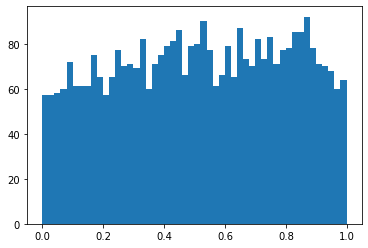

In [22]:
_ = plt.hist((gen_imgs[:,0:-9].flatten()+1)/2, bins=50)

[-0.5051 -0.4481 -0.2254 -0.7707 -0.4355 -0.2983 -0.1144 -0.0563  0.1427]


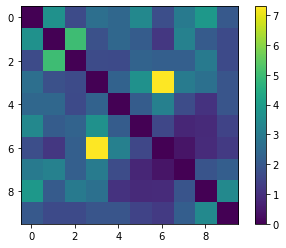

In [24]:
data_new = np.array(gen_imgs[6])

atomidentities = data_new[-9:]
print(np.around(atomidentities, 4))
#data_new = data_new[:-9]*maximum
#new_sample =squareform(pca.inverse_transform([data_new])[0])
#new_sample = scaler.inverse_transform([data_new])[0]
new_sample = squareform(10**(data_new+data_mean))
#new_sample = new_sample-np.min(new_sample)

plt.imshow(new_sample)
plt.colorbar()

In [154]:
def to_M_matrix(D):
    D1j = np.tile(D[0, :], len(D)).reshape(D.shape)
    Di1 = D1j.T
    return .5 * (-D + D1j + Di1)

def setPositions(mol_in, coords):
    conformer = mol_in.GetConformer(0)
    for i in range(mol_in.GetNumAtoms()):
        x,y,z = coords[i]
        conformer.SetAtomPosition(i,Point3D(x,y,z))
    return mol_in

D = new_sample**2
M = to_M_matrix(D)
S, U = np.linalg.eigh(M)

coord = np.matmul(U, np.diag(np.sqrt(np.abs(S))))
X = coord[:, -3:]


In [155]:
def get_proto_mol(atomicNumList):
    mol = Chem.MolFromSmarts("[#"+str(atomicNumList[0])+"]")
    rwMol = Chem.RWMol(mol)
    for i in range(1,len(atomicNumList)):
        a = Chem.Atom(atomicNumList[i])
        rwMol.AddAtom(a)

    mol = rwMol.GetMol()

    return mol


def xyz2AC(atomicNumList,xyz):
    import numpy as np
    mol = get_proto_mol(atomicNumList)

    conf = Chem.Conformer(mol.GetNumAtoms())
    for i in range(mol.GetNumAtoms()):
        conf.SetAtomPosition(i,(float(xyz[i][0]),float(xyz[i][1]),float(xyz[i][2])))
    mol.AddConformer(conf)

    dMat = Chem.Get3DDistanceMatrix(mol)
    pt = Chem.GetPeriodicTable()

    num_atoms = len(atomicNumList)
    AC = np.zeros((num_atoms,num_atoms)).astype(int)

    for i in range(num_atoms):
        a_i = mol.GetAtomWithIdx(i)
        Rcov_i = pt.GetRcovalent(a_i.GetAtomicNum())*1.30
        for j in range(i+1,num_atoms):
            a_j = mol.GetAtomWithIdx(j)
            Rcov_j = pt.GetRcovalent(a_j.GetAtomicNum())*1.30
            if dMat[i,j] <= Rcov_i + Rcov_j:
                AC[i,j] = 1
                AC[j,i] = 1

    return AC,mol


In [156]:
atomicNumList = []
for i in atomidentities:
    if i<0.0:
        atomicNumList.append(6)
    else:
        atomicNumList.append(8)
#atomicNumList= [6]*9


am, mol =xyz2AC(atomicNumList,X)

In [157]:
eMol = Chem.EditableMol(mol)

bonds = np.triu(am)
for j, k in zip(np.where(bonds)[0], np.where(bonds)[1]):
    print(j,k)
    try:
        eMol.AddBond(int(j),int(k))
    except:
        None

0 8
2 3
2 4
2 8
3 4
5 8


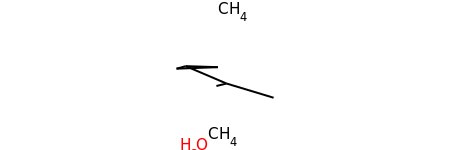

In [158]:
mol = eMol.GetMol()

Chem.rdmolfiles.MolToPDBFile(mol, 'tempmol.pdb', flavor=0)
mol

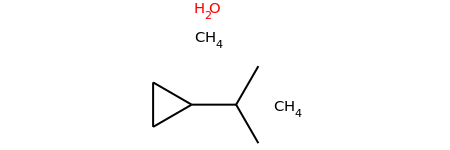

In [159]:
mol.Compute2DCoords()
mol